In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
import math
pd.set_option('display.max_rows', 1000, 'display.max_columns', None)
le = preprocessing.LabelEncoder()
from collections import Counter
import itertools
import warnings
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn import metrics
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

# Data Extraction:
(credit to my colleagues: Archit, Alan and Clinton for the data extraction piece and our professor Basil Singer for the guidance on the datasets)

*   First we are going to read in all the data files and make sense of what is going on.
*   Considering there are multiple datasets, we need to explore them and see if there a common key we can use to join the datasets.



In [3]:
df_app_bureau_balance = pd.read_csv("application_bureau_balance.csv")
df_app_bureau_general = pd.read_csv("application_bureau_general.csv")
df_app_current = pd.read_csv("application_current.csv")
df_app_history = pd.read_csv("application_history.csv")
df_data_dictionary = pd.read_csv("data_dictionary.csv")
df_pd_current_model = pd.read_csv("pd_current_model.csv")

In [4]:
df_data_dictionary

File                      Variable  \
0       application_bureau_balance.csv                     BUREAU_ID   
1       application_bureau_balance.csv                MONTHS_BALANCE   
2       application_bureau_balance.csv                        STATUS   
3       application_bureau_general.csv                   AMT_ANNUITY   
4       application_bureau_general.csv        AMT_CREDIT_MAX_OVERDUE   
5       application_bureau_general.csv                AMT_CREDIT_SUM   
6       application_bureau_general.csv           AMT_CREDIT_SUM_DEBT   
7       application_bureau_general.csv          AMT_CREDIT_SUM_LIMIT   
8       application_bureau_general.csv        AMT_CREDIT_SUM_OVERDUE   
9       application_bureau_general.csv                        APP_ID   
10      application_bureau_general.csv                     BUREAU_ID   
11      application_bureau_general.csv            CNT_CREDIT_PROLONG   
12      application_bureau_general.csv                 CREDIT_ACTIVE   
13      application_bureau_general.csv            CREDIT_DAY_OVERDUE   
14      application_bureau_general.csv                   CREDIT_TYPE   
15      application_bureau_general.csv                   DAYS_CREDIT   
16      application_bureau_general.csv           DAYS_CREDIT_ENDDATE   
17      application_bureau_general.csv            DAYS_CREDIT_UPDATE   
18      application_bureau_general.csv             DAYS_ENDDATE_FACT   
19   application_{history|current}.csv                   AMT_ANNUITY   
20   application_{history|current}.csv                    AMT_CREDIT   
21   application_{history|current}.csv               AMT_GOODS_PRICE   
22   application_{history|current}.csv              AMT_INCOME_TOTAL   
23   application_{history|current}.csv     AMT_REQ_CREDIT_BUREAU_DAY   
24   application_{history|current}.csv    AMT_REQ_CREDIT_BUREAU_HOUR   
25   application_{history|current}.csv     AMT_REQ_CREDIT_BUREAU_MON   
26   application_{history|current}.csv     AMT_REQ_CREDIT_BUREAU_QRT   
27   application_{history|current}.csv    AMT_REQ_CREDIT_BUREAU_WEEK   
28   application_{history|current}.csv    AMT_REQ_CREDIT_BUREAU_YEAR   
29   application_{history|current}.csv                APARTMENTS_AVG   
30   application_{history|current}.csv               APARTMENTS_MEDI   
31   application_{history|current}.csv               APARTMENTS_MODE   
32   application_{history|current}.csv                        APP_ID   
33   application_{history|current}.csv              BASEMENTAREA_AVG   
34   application_{history|current}.csv             BASEMENTAREA_MEDI   
35   application_{history|current}.csv             BASEMENTAREA_MODE   
36   application_{history|current}.csv                     BLU_SCORE   
37   application_{history|current}.csv                  CNT_CHILDREN   
38   application_{history|current}.csv               CNT_FAM_MEMBERS   
39   application_{history|current}.csv                COMMONAREA_AVG   
40   application_{history|current}.csv               COMMONAREA_MEDI   
41   application_{history|current}.csv               COMMONAREA_MODE   
42   application_{history|current}.csv                 DAYS_EMPLOYED   
43   application_{history|current}.csv               DAYS_ID_PUBLISH   
44   application_{history|current}.csv        DAYS_LAST_PHONE_CHANGE   
45   application_{history|current}.csv             DAYS_REGISTRATION   
46   application_{history|current}.csv      DEF_30_CNT_SOCIAL_CIRCLE   
47   application_{history|current}.csv      DEF_60_CNT_SOCIAL_CIRCLE   
48   application_{history|current}.csv                 ELEVATORS_AVG   
49   application_{history|current}.csv                ELEVATORS_MEDI   
50   application_{history|current}.csv                ELEVATORS_MODE   
51   application_{history|current}.csv           EMERGENCYSTATE_MODE   
52   application_{history|current}.csv                 ENTRANCES_AVG   
53   application_{history|current}.csv                ENTRANCES_MEDI   
54   application_{history|current}.csv                ENTRANCES_MODE   
55

## Preparing the Bureau Balance Table

Okay so now we have an idea of what the data types are and what they represent in each dataset (note: of course I don't understand all of the variables, I rather focus on the stuff that is important such as IDs/Keys for joining, the target itself and any timestamps)  We notice the following:

BUREAU_ID represents the unique record for each application meant to join the credit bureau table. Let's take a further look at the application_bureau_general table:

In [5]:
df_app_bureau_balance.head()

BUREAU_ID  MONTHS_BALANCE STATUS
0    5715448               0      C
1    5715448              -1      C
2    5715448              -2      C
3    5715448              -3      C
4    5715448              -4      C

In [6]:
df_app_bureau_balance.STATUS.unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

There are 8 unique status types, active (X), closed (X), and the rest represent days past due (DPD).

focusing on the application bureau balance table, we notice our Bureau_ID has some dups with different balance months, we need to collapse this table by having the bureau_id appear only 1 time, we also need to consider the fact we need to count the largest age so we are not underestimating their months_balance, we do this below by creating a new df specifically for balance_age:

In [7]:
df_app_bureau_balance_age = df_app_bureau_balance.groupby(['BUREAU_ID']).min(['MONTHS_BALANCE']).reset_index() # months_balance is negative so min instead of max balance
df_app_bureau_balance_age.columns = ['BUREAU_ID','AGE']
# days past due or age should be positive for interpreability
df_app_bureau_balance_age.AGE = np.abs(df_app_bureau_balance_age.AGE)
df_app_bureau_balance_age.head()

BUREAU_ID  AGE
0    5001709   96
1    5001710   82
2    5001711    3
3    5001712   18
4    5001713   21

In [8]:
df_app_bureau_balance.groupby(['BUREAU_ID']).min(['MONTHS_BALANCE']).reset_index()

BUREAU_ID  MONTHS_BALANCE
0         5001709             -96
1         5001710             -82
2         5001711              -3
3         5001712             -18
4         5001713             -21
...           ...             ...
817390    6842884             -47
817391    6842885             -23
817392    6842886             -32
817393    6842887             -36
817394    6842888             -61

[817395 rows x 2 columns]

We can also get the balance count and

In [9]:
balance_count = df_app_bureau_balance.groupby(['BUREAU_ID']).count().reset_index()[['BUREAU_ID','MONTHS_BALANCE']]
balance_count.columns = ['BUREAU_ID','COUNT']
balance_count.head()

BUREAU_ID  COUNT
0    5001709     97
1    5001710     83
2    5001711      4
3    5001712     19
4    5001713     22

Creating a merged table of age and count of Bureau ID from the Bureau Balance Table, it is then filtered to 12 months as older data may not be useful.

In [10]:
df_balance = pd.merge(df_app_bureau_balance, df_app_bureau_balance_age, how = 'left', on = 'BUREAU_ID')
df_balance = pd.merge(df_balance, balance_count, how = 'left', on = 'BUREAU_ID')

we can take a look at the distribution of

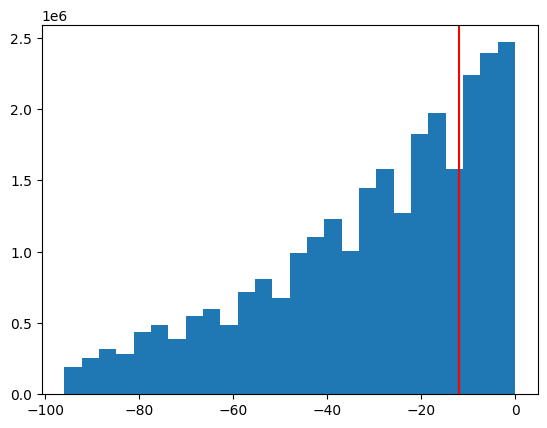

In [11]:
plt.hist(df_balance['MONTHS_BALANCE'], bins = 'sturges')
plt.axvline(x = -12, color = 'r', label = "12 month cut off")
plt.show()

In [12]:
df_balance = df_balance[df_balance['MONTHS_BALANCE'] >= -12]

Let's take a look at the distribution of status, perhaps we can also make a range cut-off or create further binning based on the distribution of the variable.

In [13]:
df_balance.head()

BUREAU_ID  MONTHS_BALANCE STATUS  AGE  COUNT
0    5715448               0      C   26     27
1    5715448              -1      C   26     27
2    5715448              -2      C   26     27
3    5715448              -3      C   26     27
4    5715448              -4      C   26     27

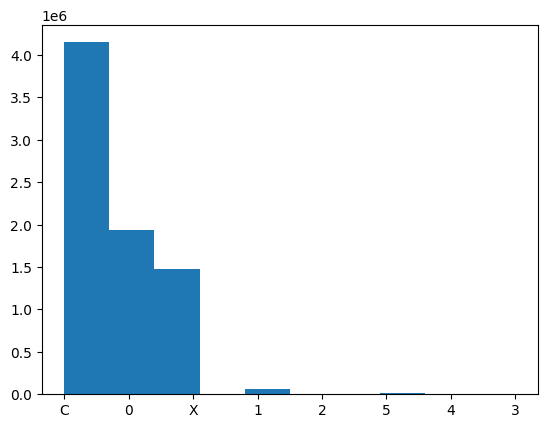

In [14]:
plt.hist(df_balance['STATUS'].astype(str))
plt.show()

In [15]:
# create new col to indicate status is 0 or not, we perform this for what appears to be our majority of values and group minority values
df_balance['IS_STATUS_0'] = np.where(df_balance['STATUS'] == '0', 1, 0)
df_balance['IS_STATUS_C'] = np.where(df_balance['STATUS'] == 'C', 1, 0)
df_balance['IS_STATUS_X'] = np.where(df_balance['STATUS'] == 'X', 1, 0)
df_balance['IS_STATUS_OTHER'] = np.where( (df_balance['STATUS'] != '0') & (df_balance['STATUS'] != 'C') & (df_balance['STATUS'] != 'X') , 1, 0)
del df_balance['STATUS'] # no longer needed
df_balance.head()

BUREAU_ID  MONTHS_BALANCE  AGE  COUNT  IS_STATUS_0  IS_STATUS_C  \
0    5715448               0   26     27            0            1   
1    5715448              -1   26     27            0            1   
2    5715448              -2   26     27            0            1   
3    5715448              -3   26     27            0            1   
4    5715448              -4   26     27            0            1   

   IS_STATUS_X  IS_STATUS_OTHER  
0            0                0  
1            0                0  
2            0                0  
3            0                0  
4            0                0

In [16]:
# We want the most recent values of Age and Count
# inside line first finds the max of months_balance which is latest value, if this value is found in df_balance keep it (filtering out older values)
df_balance_recent = df_balance[df_balance.groupby('BUREAU_ID')['MONTHS_BALANCE'].transform(max) == df_balance['MONTHS_BALANCE']]
df_balance_recent

BUREAU_ID  MONTHS_BALANCE  AGE  COUNT  IS_STATUS_0  IS_STATUS_C  \
0           5715448               0   26     27            0            1   
27          5715449               0   11     12            0            1   
39          5715451              -5   30     26            0            1   
65          5715452               0   32     33            0            1   
98          5715453               0   37     38            0            1   
...             ...             ...  ...    ...          ...          ...   
27299486    5025218               0   66     67            0            1   
27299618    5041120              -4   76     73            0            1   
27299691    5041141               0   24     25            0            1   
27299799    5041172               0   77     78            0            1   
27299877    5041332               0   23     24            0            0   

          IS_STATUS_X  IS_STATUS_OTHER  
0                   0                0  
27                  0                0  
39                  0                0  
65                  0                0  
98                  0                0  
...               ...              ...  
27299486            0                0  
27299618            0                0  
27299691            0                0  
27299799            0                0  
27299877            1                0  

[682164 rows x 8 columns]

To aggregate to the BUREAU level, we take the min,max and mean of IS_STATUS dummy variables.

In [17]:
df_balance_status_agg = df_balance.groupby(['BUREAU_ID'])['IS_STATUS_0','IS_STATUS_C','IS_STATUS_X','IS_STATUS_OTHER'].agg([pd.Series.max,pd.Series.min,np.mean]).reset_index()

In [18]:
df_balance_status_agg

BUREAU_ID IS_STATUS_0               IS_STATUS_C                \
                         max min      mean         max min      mean   
0        5001709           0   0  0.000000           1   1  1.000000   
1        5001710           0   0  0.000000           1   1  1.000000   
2        5001711           1   0  0.750000           0   0  0.000000   
3        5001712           1   0  0.307692           1   0  0.692308   
4        5001713           0   0  0.000000           0   0  0.000000   
...          ...         ...  ..       ...         ...  ..       ...   
682159   6842884           0   0  0.000000           1   1  1.000000   
682160   6842885           1   0  0.076923           0   0  0.000000   
682161   6842886           0   0  0.000000           1   1  1.000000   
682162   6842887           0   0  0.000000           1   1  1.000000   
682163   6842888           0   0  0.000000           1   1  1.000000   

       IS_STATUS_X           IS_STATUS_OTHER                
               max min  mean             max min      mean  
0                0   0  0.00               0   0  0.000000  
1                0   0  0.00               0   0  0.000000  
2                1   0  0.25               0   0  0.000000  
3                0   0  0.00               0   0  0.000000  
4                1   1  1.00               0   0  0.000000  
...            ...  ..   ...             ...  ..       ...  
682159           0   0  0.00               0   0  0.000000  
682160           0   0  0.00               1   0  0.923077  
682161           0   0  0.00               0   0  0.000000  
682162           0   0  0.00               0   0  0.000000  
682163           0   0  0.00               0   0  0.000000  

[682164 rows x 13 columns]

In [19]:
df_balance_status_agg.columns = ['_'.join(col).strip() if ('BUREAU_ID' not in col) else ' '.join(col).strip() for col in df_balance_status_agg.columns.values]
df_balance_status_agg

BUREAU_ID  IS_STATUS_0_max  IS_STATUS_0_min  IS_STATUS_0_mean  \
0         5001709                0                0          0.000000   
1         5001710                0                0          0.000000   
2         5001711                1                0          0.750000   
3         5001712                1                0          0.307692   
4         5001713                0                0          0.000000   
...           ...              ...              ...               ...   
682159    6842884                0                0          0.000000   
682160    6842885                1                0          0.076923   
682161    6842886                0                0          0.000000   
682162    6842887                0                0          0.000000   
682163    6842888                0                0          0.000000   

        IS_STATUS_C_max  IS_STATUS_C_min  IS_STATUS_C_mean  IS_STATUS_X_max  \
0                     1                1          1.000000                0   
1                     1                1          1.000000                0   
2                     0                0          0.000000                1   
3                     1                0          0.692308                0   
4                     0                0          0.000000                1   
...                 ...              ...               ...              ...   
682159                1                1          1.000000                0   
682160                0                0          0.000000                0   
682161                1                1          1.000000                0   
682162                1                1          1.000000                0   
682163                1                1          1.000000                0   

        IS_STATUS_X_min  IS_STATUS_X_mean  IS_STATUS_OTHER_max  \
0                     0              0.00                    0   
1                     0              0.00                    0   
2                     0              0.25                    0   
3                     0              0.00                    0   
4                     1              1.00                    0   
...                 ...               ...                  ...   
682159                0              0.00                    0   
682160                0              0.00                    1   
682161                0              0.00                    0   
682162                0              0.00                    0   
682163                0              0.00                    0   

        IS_STATUS_OTHER_min  IS_STATUS_OTHER_mean  
0                         0              0.000000  
1                         0              0.000000  
2                         0              0.000000  
3                         0              0.000000  
4                         0              0.000000  
...                     ...                   ...  
682159                    0              0.000000  
682160                    0              0.923077  
682161                    0              0.000000  
682162                    0              0.000000  
682163                    0              0.000000  

[682164 rows x 13 columns]

Now we want to create a mapper table, that maps BUREAU_ID to APP_ID. Mapping index between the main application table to the bureau tables. Taken from the bureau_general table.

In [20]:
bureau_app_mapper = df_app_bureau_general.groupby(['BUREAU_ID', 'APP_ID']).count().reset_index()[['APP_ID','BUREAU_ID']]

In [21]:
# now using the mapper lets merge these damn databases: df_balance_recent + df_balance_status_agg on bureau_id
# then merge with mapper, WARNING: SLOW AF RUN ONCE ONLY ONCE UNLESS UR PAID HOURLY
df_balance_recent_agg = pd.merge(df_balance_recent, df_balance_status_agg, how = 'left', on = 'BUREAU_ID')
df_balance_mapped = pd.merge(df_balance_recent_agg, bureau_app_mapper, how = 'left', on = 'BUREAU_ID')

Okay so now we have the Bureau balance table mapped with the mapper which has APP_ID and Bureau_ID aligned so now we have both keys into this table.

In [22]:
df_balance_mapped.columns

Index(['BUREAU_ID', 'MONTHS_BALANCE', 'AGE', 'COUNT', 'IS_STATUS_0',
       'IS_STATUS_C', 'IS_STATUS_X', 'IS_STATUS_OTHER', 'IS_STATUS_0_max',
       'IS_STATUS_0_min', 'IS_STATUS_0_mean', 'IS_STATUS_C_max',
       'IS_STATUS_C_min', 'IS_STATUS_C_mean', 'IS_STATUS_X_max',
       'IS_STATUS_X_min', 'IS_STATUS_X_mean', 'IS_STATUS_OTHER_max',
       'IS_STATUS_OTHER_min', 'IS_STATUS_OTHER_mean', 'APP_ID'],
      dtype='object')

In [23]:
# get the most recent entry based on each APP_ID similar as above.
df_balance_app_first = df_balance_mapped[['APP_ID','BUREAU_ID','MONTHS_BALANCE','AGE','COUNT','IS_STATUS_0','IS_STATUS_C','IS_STATUS_X','IS_STATUS_OTHER']].groupby(['APP_ID']).first().reset_index()

now we want to now we aggregate the values based on APP_ID and calculate the basic descriptive stats (min, max, mean)

In [24]:
df_balance_app_agg = df_balance_mapped[['BUREAU_ID', 'MONTHS_BALANCE', 'AGE', 'COUNT', 'IS_STATUS_0',
       'IS_STATUS_C', 'IS_STATUS_X', 'IS_STATUS_OTHER', 'IS_STATUS_0_max',
       'IS_STATUS_0_min', 'IS_STATUS_0_mean', 'IS_STATUS_C_max',
       'IS_STATUS_C_min', 'IS_STATUS_C_mean', 'IS_STATUS_X_max',
       'IS_STATUS_X_min', 'IS_STATUS_X_mean',
      'IS_STATUS_OTHER_max', 'IS_STATUS_OTHER_min', 'IS_STATUS_OTHER_mean',
      'APP_ID']].groupby(['APP_ID']).agg({'IS_STATUS_0_max':pd.Series.max,'IS_STATUS_0_min':pd.Series.min,'IS_STATUS_0_mean':np.mean,
      'IS_STATUS_C_max':pd.Series.max,'IS_STATUS_C_min':pd.Series.min,'IS_STATUS_C_mean':np.mean,
      'IS_STATUS_X_max':pd.Series.max,'IS_STATUS_X_min':pd.Series.min,'IS_STATUS_X_mean':np.mean,
      'IS_STATUS_OTHER_max':pd.Series.max,'IS_STATUS_OTHER_min':pd.Series.min,'IS_STATUS_OTHER_min':np.mean}).reset_index()

In [25]:
df_balance_app_agg.head()

APP_ID  IS_STATUS_0_max  IS_STATUS_0_min  IS_STATUS_0_mean  \
0  100001.0                1                0          0.302198   
1  100002.0                1                0          0.250000   
2  100005.0                1                0          0.735043   
3  100010.0                0                0          0.000000   
4  100013.0                0                0          0.000000   

   IS_STATUS_C_max  IS_STATUS_C_min  IS_STATUS_C_mean  IS_STATUS_X_max  \
0                1                0          0.571429                1   
1                1                0          0.500000                1   
2                1                0          0.128205                1   
3                1                1          1.000000                0   
4                1                0          0.750000                1   

   IS_STATUS_X_min  IS_STATUS_X_mean  IS_STATUS_OTHER_max  IS_STATUS_OTHER_min  
0                0          0.115385                    1                  0.0  
1                0          0.250000                    0                  0.0  
2                0          0.136752                    0                  0.0  
3                0          0.000000                    0                  0.0  
4                0          0.250000                    0                  0.0

collapse the bureau balance table

In [26]:
df_app_balance = pd.merge(df_balance_app_agg, df_balance_app_first, how = 'left', on = 'APP_ID')
df_app_balance['APP_ID'] = df_app_balance['APP_ID'].astype(int) # key should not be float
df_app_balance.head()

APP_ID  IS_STATUS_0_max  IS_STATUS_0_min  IS_STATUS_0_mean  \
0  100001                1                0          0.302198   
1  100002                1                0          0.250000   
2  100005                1                0          0.735043   
3  100010                0                0          0.000000   
4  100013                0                0          0.000000   

   IS_STATUS_C_max  IS_STATUS_C_min  IS_STATUS_C_mean  IS_STATUS_X_max  \
0                1                0          0.571429                1   
1                1                0          0.500000                1   
2                1                0          0.128205                1   
3                1                1          1.000000                0   
4                1                0          0.750000                1   

   IS_STATUS_X_min  IS_STATUS_X_mean  IS_STATUS_OTHER_max  \
0                0          0.115385                    1   
1                0          0.250000                    0   
2                0          0.136752                    0   
3                0          0.000000                    0   
4                0          0.250000                    0   

   IS_STATUS_OTHER_min  BUREAU_ID  MONTHS_BALANCE  AGE  COUNT  IS_STATUS_0  \
0                  0.0    5896630               0   28     29            0   
1                  0.0    6158905               0   15     16            0   
2                  0.0    6735200               0   12     13            0   
3                  0.0    5576630              -2   37     36            0   
4                  0.0    5922083               0   65     66            0   

   IS_STATUS_C  IS_STATUS_X  IS_STATUS_OTHER  
0            1            0                0  
1            1            0                0  
2            1            0                0  
3            1            0                0  
4            1            0                0

## Preparing the Bureau General Table

We are going to re-perform similiar steps we did for collapsing the Bureau Balane table but now for the Bureau General Table.

In [27]:
df_app_bureau_general.head()

APP_ID  BUREAU_ID CREDIT_ACTIVE  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0  215354    5714462        Closed         -497                   0   
1  215354    5714463        Active         -208                   0   
2  215354    5714464        Active         -203                   0   
3  215354    5714465        Active         -203                   0   
4  215354    5714466        Active         -629                   0   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0               -153.0             -153.0                     NaN   
1               1075.0                NaN                     NaN   
2                528.0                NaN                     NaN   
3                  NaN                NaN                     NaN   
4               1197.0                NaN                 77674.5   

   CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
0                   0         91323.0                  0.0   
1                   0        225000.0             171342.0   
2                   0        464323.5                  NaN   
3                   0         90000.0                  NaN   
4                   0       2700000.0                  NaN   

   AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  \
0                   NaN                     0.0  Consumer credit   
1                   NaN                     0.0      Credit card   
2                   NaN                     0.0  Consumer credit   
3                   NaN                     0.0      Credit card   
4                   NaN                     0.0  Consumer credit   

   DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0                -131          NaN  
1                 -20          NaN  
2                 -16          NaN  
3                 -16          NaN  
4                 -21          NaN

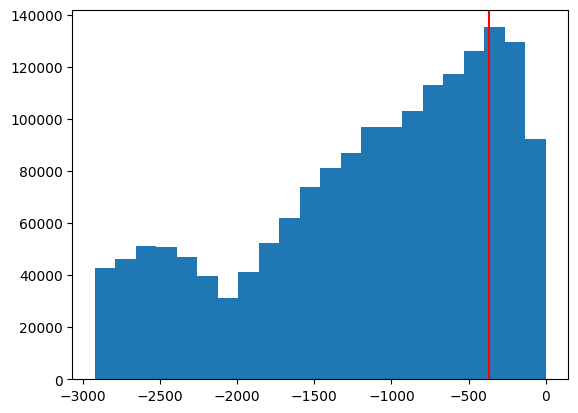

In [28]:
plt.hist(df_app_bureau_general['DAYS_CREDIT'], bins = 'sturges')
plt.axvline(x = -365, color = 'r', label = " 365 days (12 month) cut off")
plt.show()

In [29]:
df_app_bureau_general_age = df_app_bureau_general.groupby('APP_ID').agg({'DAYS_CREDIT':pd.Series.min}).reset_index()
df_app_bureau_general_age['DAYS_CREDIT'] = np.abs(df_app_bureau_general_age['DAYS_CREDIT']) # same thing we did with age above
df_bureau_general_count = df_app_bureau_general.groupby(['APP_ID']).size().reset_index(name='COUNT')
df_bureau_general_count # occurances

APP_ID  COUNT
0       100001      7
1       100002      8
2       100003      4
3       100004      2
4       100005      3
...        ...    ...
305806  456249     13
305807  456250      3
305808  456253      4
305809  456254      1
305810  456255     11

[305811 rows x 2 columns]

There are some variables which provide the number of days overdue, prolonged, Status of the Credit Bureau (CB) reported credits which may serve better as binary variables. lets take a look at them.

In [30]:
df_app_bureau_general['CNT_CREDIT_PROLONG'].unique()

array([0, 2, 1, 4, 3, 5, 9, 8, 6, 7])

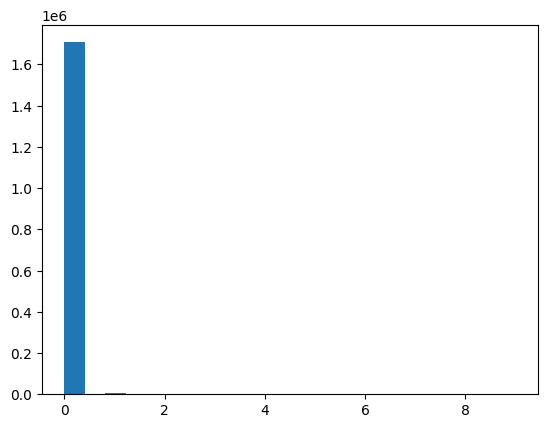

In [31]:
plt.hist(df_app_bureau_general['CNT_CREDIT_PROLONG'], bins = 'sturges')
plt.show()

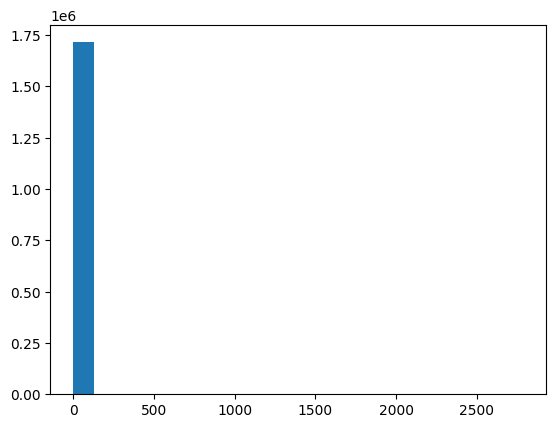

In [32]:
plt.hist(df_app_bureau_general['CREDIT_DAY_OVERDUE'], bins = 'sturges')
plt.show()

SO we will convert these variables into binary variables as there is a staggering concentration in 1 category versus the others.

In [33]:
# dedicated binary-ification function
def count_to_binary(df,col):
  return df[col].apply(lambda x: 0 if x ==0 else 1)

In [34]:
turn2binary = ['CREDIT_DAY_OVERDUE','CNT_CREDIT_PROLONG','CREDIT_ACTIVE']

In [35]:
df_bureau_general_binary = df_app_bureau_general[['APP_ID','BUREAU_ID','CREDIT_DAY_OVERDUE','CNT_CREDIT_PROLONG','CREDIT_ACTIVE']]
for col in turn2binary:
  if col == 'CREDIT_ACTIVE':
    df_bureau_general_binary[col] = df_bureau_general_binary['CREDIT_ACTIVE'].apply(lambda x: 1 if x== 'Active' else 0 )
  else:
    df_bureau_general_binary[col] = count_to_binary(df_bureau_general_binary, col)

df_bureau_general_binary.columns = ['APP_ID','BUREAU_ID','IS_CREDIT_OVERDUE','IS_CREDIT_PROLONG','IS_ACTIVE']
df_bureau_general_binary = df_bureau_general_binary.groupby(['APP_ID']).first().reset_index()
df_bureau_general_binary = df_bureau_general_binary[['APP_ID','IS_CREDIT_OVERDUE','IS_CREDIT_PROLONG','IS_ACTIVE']]

In [36]:
df_bureau_general_binary

APP_ID  IS_CREDIT_OVERDUE  IS_CREDIT_PROLONG  IS_ACTIVE
0       100001                  0                  0          0
1       100002                  0                  0          0
2       100003                  0                  0          0
3       100004                  0                  0          0
4       100005                  0                  0          0
...        ...                ...                ...        ...
305806  456249                  0                  0          0
305807  456250                  0                  0          0
305808  456253                  0                  0          0
305809  456254                  0                  0          0
305810  456255                  0                  0          0

[305811 rows x 4 columns]

Now we should take a look at the numerical values.

In [37]:
df_bureau_general_numeric = df_app_bureau_general[['APP_ID', 'BUREAU_ID',
       'CREDIT_DAY_OVERDUE','AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']]

In [38]:
# taking advance of fact avging values out may remove some NaNs
df_bureau_general_numeric = df_bureau_general_numeric.groupby(['APP_ID']).mean().reset_index()
df_bureau_general_numeric

APP_ID    BUREAU_ID  CREDIT_DAY_OVERDUE  AMT_CREDIT_MAX_OVERDUE  \
0       100001  5896633.000                 0.0                     NaN   
1       100002  6153272.125                 0.0                1681.029   
2       100003  5885878.500                 0.0                   0.000   
3       100004  6829133.500                 0.0                   0.000   
4       100005  6735201.000                 0.0                   0.000   
...        ...          ...                 ...                     ...   
305806  456249  5371700.000                 0.0                6147.000   
305807  456250  6817237.000                 0.0                   0.000   
305808  456253  5885018.500                 0.0                     NaN   
305809  456254  6669849.000                 0.0                     NaN   
305810  456255  5126332.000                 0.0               12056.481   

        AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
0         2.076236e+05         85240.928571               0.00000   
1         1.081319e+05         49156.200000            7997.14125   
2         2.543501e+05             0.000000          202500.00000   
3         9.451890e+04             0.000000               0.00000   
4         2.190420e+05        189469.500000               0.00000   
...                ...                  ...                   ...   
305806    2.841430e+05         16307.100000               0.00000   
305807    1.028820e+06        744013.365000           19422.79500   
305808    9.900000e+05        448958.250000               0.00000   
305809    4.500000e+04             0.000000                   NaN   
305810    3.456290e+05        191864.126250               0.00000   

        AMT_CREDIT_SUM_OVERDUE    AMT_ANNUITY  
0                          0.0    3545.357143  
1                          0.0       0.000000  
2                          0.0            NaN  
3                          0.0            NaN  
4                          0.0    1420.500000  
...                        ...            ...  
305806                     0.0            NaN  
305807                     0.0  154567.965000  
305808                     0.0   58369.500000  
305809                     0.0       0.000000  
305810                     0.0    1081.500000  

[305811 rows x 9 columns]

There are a few ways to fill in missing data:

*   Dropping NA values
*   Filling value with mean or median depending on distribution (if categorical then mode) - this is only done after analysis which suggests the NA value is correlated highly with other variable(s) and thus we can group by the correlated ones and then take the mode/median based on that grouping.
*   Regressing on the remaining variables to fill in the missing data. Typically overkill imo (atleast in my very little experience).
* labelling them with -1 or -999999999999999999 (if numerical) as missing data is also information about the observation (our likely approach we will take in step 2). -> This is what I've heard/seen in the industry.

we will work on this later on step 2 (Data Treatment)







In [39]:
count_NAN = df_bureau_general_numeric.isnull().sum()
percent_NAN =  count_NAN / len(df_bureau_general_numeric)
# we can turn this into a data frame as well
NAN_df = pd.DataFrame( {'Variable' : df_bureau_general_numeric.columns, 'NaN count' : count_NAN ,'NaN %': round(percent_NAN,4) } )
NAN_df

Variable  NaN count   NaN %
APP_ID                                  APP_ID          0  0.0000
BUREAU_ID                            BUREAU_ID          0  0.0000
CREDIT_DAY_OVERDUE          CREDIT_DAY_OVERDUE          0  0.0000
AMT_CREDIT_MAX_OVERDUE  AMT_CREDIT_MAX_OVERDUE      92840  0.3036
AMT_CREDIT_SUM                  AMT_CREDIT_SUM          2  0.0000
AMT_CREDIT_SUM_DEBT        AMT_CREDIT_SUM_DEBT       8372  0.0274
AMT_CREDIT_SUM_LIMIT      AMT_CREDIT_SUM_LIMIT      25308  0.0828
AMT_CREDIT_SUM_OVERDUE  AMT_CREDIT_SUM_OVERDUE          0  0.0000
AMT_ANNUITY                        AMT_ANNUITY     187587  0.6134

 main bureau table filtered for accounts less than or equal to cutt off since

In [40]:
df_bureau_general = pd.merge(df_bureau_general_numeric, df_bureau_general_binary, how = 'left', on = 'APP_ID' )
df_bureau_general = df_bureau_general_numeric[['APP_ID', 'BUREAU_ID',
       'CREDIT_DAY_OVERDUE','AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
                                                'AMT_ANNUITY']]
df_bureau_general = pd.merge(df_bureau_general, df_app_bureau_general_age, how = 'left', on = 'APP_ID')
df_bureau_general = pd.merge(df_bureau_general, df_bureau_general_count, how = 'left',  on = 'APP_ID')
df_bureau_general = df_bureau_general[df_bureau_general['DAYS_CREDIT']<= 365]
df_bureau_general.head()

APP_ID  BUREAU_ID  CREDIT_DAY_OVERDUE  AMT_CREDIT_MAX_OVERDUE  \
27  100033  5943236.0                 0.0                     NaN   
39  100048  5295749.0                 0.0                     0.0   
77  100090  5800445.5                 0.0                     NaN   
91  100107  6566321.0                 0.0                     0.0   
94  100110  5531774.0                 0.0                     0.0   

    AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
27       675000.00                0.000                   0.0   
39        22905.00                0.000                   0.0   
77        56520.90            31085.415                   NaN   
91       124195.68           124195.680                   0.0   
94        65511.00            52820.595                   0.0   

    AMT_CREDIT_SUM_OVERDUE  AMT_ANNUITY  DAYS_CREDIT  COUNT  
27                     0.0          NaN          195      1  
39                     0.0          NaN           75      1  
77                     0.0          NaN          315      2  
91                     0.0     10031.76           17      1  
94                     0.0          NaN           86      1

## Combining all datasets



In [41]:
dataset_current = pd.merge(df_app_current, df_bureau_general, how = 'left', on = 'APP_ID')
dataset_current = pd.merge(dataset_current, df_app_balance, how = 'left', on = 'APP_ID')

dataset_historical = pd.merge(df_app_history,df_bureau_general, how = 'left', on = 'APP_ID' )
dataset_historical = pd.merge(df_app_history,df_app_balance, how = 'left', on = 'APP_ID' )

In [42]:
df_app_history.head().IS_DEFAULT

0    0
1    0
2    0
3    0
4    0
Name: IS_DEFAULT, dtype: int64

downloading these datasets so i dont have to re-run extraction and joining process

In [43]:
dataset_current.to_csv('dataset_current.csv', index = False)
dataset_historical.to_csv('dataset_historical.csv', index = False)

# Data Treatement

Here we will perform the following:



1.   Addressing NA values.
2.   Addressing Outliers.
3. Binning observations (including numerical -> helps logistic regression model)
4. Computing Weight of Evidence to later be used for information value.
5. Splitting the Dataset into testing and training.

PLEASE NOTE: Although we put splitting the dataset at the end. we will actually apply the treatment to determine outliers, binning etc by using the training dataset and apply that analysis to the testing dataset. you should NEVER re-determine your criteria on the testing dataset (by definition of what testing should mean).

For NA values, we are going to bin them into their own category.



In [2]:
df_main_history = pd.read_csv('dataset_historical.csv')
df_main_current = pd.read_csv('dataset_current.csv')

Now we have prepared the datasets. Considering this is a classification problem, one of our primary models we will use is the logistic regression, so we need to perform outlier treatment.

For numerical values:


1. Flagging outliers by using the Z score approach and a 99.9% cut-off. $ \frac{\hat{x} - \bar{x}}{std(x)} $ where any value that exceeds $Z_{0.01\%, 99.9\%} = \pm 3.291 $ is flagged as an outlier.
2. Cap and Floor values using the 1% and 99% (percentiles).
3. Apply this logic to training, backtesting and impact datasets (we will just apply this to the aggregate main dataframe and then split the datasets).



In [3]:
count_NAN = df_main_history.isnull().sum()
percent_NAN =  count_NAN / len(df_main_history)
# we can turn this into a data frame as well
NAN_df = pd.DataFrame( {'Variable' : df_main_history.columns, 'NaN count' : count_NAN ,'NaN %': round(percent_NAN,4) } )
NAN_df

Variable  NaN count   NaN %
APP_ID                                              APP_ID          0  0.0000
IS_DEFAULT                                      IS_DEFAULT          0  0.0000
NAME_CONTRACT_TYPE                      NAME_CONTRACT_TYPE          0  0.0000
FLAG_OWN_CAR                                  FLAG_OWN_CAR          0  0.0000
FLAG_OWN_REALTY                            FLAG_OWN_REALTY          0  0.0000
CNT_CHILDREN                                  CNT_CHILDREN          0  0.0000
AMT_INCOME_TOTAL                          AMT_INCOME_TOTAL          0  0.0000
AMT_CREDIT                                      AMT_CREDIT          0  0.0000
AMT_ANNUITY                                    AMT_ANNUITY          1  0.0000
AMT_GOODS_PRICE                            AMT_GOODS_PRICE         42  0.0010
NAME_TYPE_SUITE                            NAME_TYPE_SUITE        179  0.0041
NAME_INCOME_TYPE                          NAME_INCOME_TYPE          0  0.0000
NAME_EDUCATION_TYPE                    NAME_EDUCATION_TYPE          0  0.0000
NAME_FAMILY_STATUS                      NAME_FAMILY_STATUS          0  0.0000
NAME_HOUSING_TYPE                        NAME_HOUSING_TYPE          0  0.0000
REGION_POPULATION_RELATIVE      REGION_POPULATION_RELATIVE          0  0.0000
DAYS_EMPLOYED                                DAYS_EMPLOYED          0  0.0000
DAYS_REGISTRATION                        DAYS_REGISTRATION          0  0.0000
DAYS_ID_PUBLISH                            DAYS_ID_PUBLISH          0  0.0000
OWN_CAR_AGE                                    OWN_CAR_AGE      28922  0.6622
FLAG_MOBIL                                      FLAG_MOBIL          0  0.0000
FLAG_EMP_PHONE                              FLAG_EMP_PHONE          0  0.0000
FLAG_WORK_PHONE                            FLAG_WORK_PHONE          0  0.0000
FLAG_CONT_MOBILE                          FLAG_CONT_MOBILE          0  0.0000
FLAG_PHONE                                      FLAG_PHONE          0  0.0000
FLAG_EMAIL                                      FLAG_EMAIL          0  0.0000
OCCUPATION_TYPE                            OCCUPATION_TYPE      13745  0.3147
CNT_FAM_MEMBERS                            CNT_FAM_MEMBERS          0  0.0000
REGION_RATING_CLIENT                  REGION_RATING_CLIENT          0  0.0000
REGION_RATING_CLIENT_W_CITY    REGION_RATING_CLIENT_W_CITY          0  0.0000
WEEKDAY_APPR_PROCESS_START      WEEKDAY_APPR_PROCESS_START          0  0.0000
HOUR_APPR_PROCESS_START            HOUR_APPR_PROCESS_START          0  0.0000
REG_REGION_NOT_LIVE_REGION      REG_REGION_NOT_LIVE_REGION          0  0.0000
REG_REGION_NOT_WORK_REGION      REG_REGION_NOT_WORK_REGION          0  0.0000
LIVE_REGION_NOT_WORK_REGION    LIVE_REGION_NOT_WORK_REGION          0  0.0000
REG_CITY_NOT_LIVE_CITY              REG_CITY_NOT_LIVE_CITY          0  0.0000
REG_CITY_NOT_WORK_CITY              REG_CITY_NOT_WORK_CITY          0  0.0000
LIVE_CITY_NOT_WORK_CITY            LIVE_CITY_NOT_WORK_CITY          0  0.0000
ORGANIZATION_TYPE                        ORGANIZATION_TYPE          0  0.0000
BLU_SCORE                                        BLU_SCORE       8736  0.2000
APARTMENTS_AVG                              APARTMENTS_AVG      22220  0.5087
BASEMENTAREA_AVG                          BASEMENTAREA_AVG      25589  0.5859
YEARS_BEGINEXPLUATATION_AVG    YEARS_BEGINEXPLUATATION_AVG      21371  0.4893
YEARS_BUILD_AVG                            YEARS_BUILD_AVG      29092  0.6661
COMMONAREA_AVG                              COMMONAREA_AVG      30563  0.6998
ELEVATORS_AVG                                ELEVATORS_AVG      23340  0.5344
ENTRANCES_AVG                                ENTRANCES_AVG      22067  0.5052
FLOORSMAX_AVG                                FLOORSMAX_AVG      21827  0.4997
FLOORSMIN_AVG                                FLOORSMIN_AVG      29666  0.6792
LANDAREA_AVG                                  LANDAREA_AVG      25981  0.5948
LIVINGAPARTMENTS_AVG                  LIVINGAPARTMENTS_AVG      29925  0

In [4]:
df_main_history.dtypes

APP_ID                            int64
IS_DEFAULT                        int64
NAME_CONTRACT_TYPE               object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64
FLAG_CONT_MOBILE                  int64
FLAG_PHONE                        int64


there are some features/variables that are categorical and others that are numerical, we use regrex and their types to determine which are which to then perform our appropriate data treatment.

IMPORTANT: We choose to edit the dataset itself instead of creating copies in the function due to RAM limitations, otherwise this is bad practice, you should create and edit copies of your dataset. For me on my potato pc, I need to be careful when creating multiple copies of these datasets or else i crash. may change later

In [5]:
#THIS IS GLOBAL
# we know which variables should be categorical and thus converted to int
categorical_vars = '^DEF_|^OBS_|CNT_FAM_MEMBERS$|IS_STATUS_0$|IS_STATUS_C$|IS_STATUS_X$|IS_STATUS_OTHER$|IS_STATUS_0 max$|IS_STATUS_0 min$|IS_STATUS_C max$|IS_STATUS_C min$|IS_STATUS_X max$|IS_STATUS_X min$|IS_STATUS_OTHER max$|IS_STATUS_OTHER min$'

# same idea with numerical var
numerical_cols2float = ['DAYS_ID_PUBLISH', 'DAYS_EMPLOYED']

In [6]:
def num_outlier_treatment(df_num, df_cat):
  means = df_num.mean()
  std_devs = df_num.std()
  Z = (df_num - means) / std_devs
  index = (abs(Z) > 3.29).sum(axis=1) == 0
  # flag the outlier in categorical df
  df_cat['Outlier'] = np.where(index ==True, 0, 1)
  df_cat['Outlier'] = df_cat['Outlier'].astype(int)

  # quantiles, capping and flooring to [1%,99%]
  quantiles = df_num.quantile([0.01,0.99], axis = 0 )


  for i in range(df_num.shape[1]):
    df_num.loc[df_num.iloc[:,i] < quantiles.iloc[0,i] , df_num.columns[i]] = quantiles.iloc[0,i]
    df_num.loc[df_num.iloc[:,i] > quantiles.iloc[1,i], df_num.columns[i]] = quantiles.iloc[1,i]

  return df_num, df_cat, quantiles, means, std_devs

def outlier_helper(df):
  # seperate numericals and categortical
  for col in df.columns:
    #first we need to treat the NA values and convert
    if col in df.filter(regex = categorical_vars):
      df[col] = np.abs(df[col])
      df[col] = df[col].fillna(-1)
      df[col] = df[col].astype(int)
    elif col in numerical_cols2float:
      # MIGHT WANT TO NP.ABS VALUES TO POSITIVE AS -1 IS LABEL FOR NaN
      df[col] = df[col].astype(float)
  return df

def outlier_treatment_train (df):
  df2 = outlier_helper(df)
   # extract labels
  df_label = df2.filter(regex = 'APP_ID|IS_DEFAULT')
  # extract cat cols
  df_cat = df2.select_dtypes(include = [object, int]).drop(columns = ['APP_ID', 'IS_DEFAULT'])
  # extract continous cols
  df_num = df2.select_dtypes(include = float)

  df_num, df_cat, quantiles, means, std_devs = num_outlier_treatment(df_num, df_cat)

  return df_num, df_cat, df_label, quantiles, means, std_devs

def outlier_treatment_test(df, df_mean, df_std, percentiles, dftype = 'test'):
  # USE ON TEST SET ONLY
  df2 = outlier_helper(df)
  df_cat = df2.select_dtypes(include = [object, int])
  df_label = df_cat.filter(regex = 'APP_ID|IS_DEFAULT')
  if dftype == 'test':
    df_cat = df_cat.drop(columns = ['APP_ID', 'IS_DEFAULT'])
  else: # impact dataset
    df_cat = df_cat.drop(columns = ['APP_ID'])

  df_num = df2.select_dtypes(include = float)

  Z_test = (df_num - df_mean ) / df_std
  i = (abs(Z_test) > 3.29).sum(axis=1) == 0

  df_cat['Outlier'] = np.where(i == True, 0, 1)
  df_cat['Outlier'] = df_cat['Outlier'].astype(int)

  for i in range(df_num.shape[1]):
    # credit to teammate, may redo later in my own way

    df_num.loc[df_num.iloc[:,i] < percentiles.iloc[0,i] , df_num.columns[i]] = percentiles.iloc[0,i]
    df_num.loc[df_num.iloc[:,i] > percentiles.iloc[1,i], df_num.columns[i]] = percentiles.iloc[1,i]

  return df_num, df_cat, df_label

We are going to be using WOE binning for all variables using the training datasets and binning variables based on their quartiles, missing values will have a custom bin.

In [7]:
def binning_num_helper(df_num, bins):
    # perform the binning
  for col in bins.columns:
    df_num[col] = pd.cut(df_num[col], bins = bins[col], right= False,
                         labels = [1,2,3,4])

  # we fill with special value to mark NA, category var cant use fill na

  df_num = df_num.astype(object).fillna(-1)

  df_num = df_num.astype(float)

  return df_num

def binning_numerical_training(df_num):

  # define quartiles
  bins = df_num.quantile([0,0.25, 0.5, 0.75,1], axis = 0)
  bins.iloc[4,:] = bins.iloc[4,:] + 0.01
  # quartiles need to be unique for cut(), add epsilon if quartiles are not unique.

  for col in bins.columns:
    if bins[col].nunique() < 5:
        # we add this scaled epsilon to make each bin unique
        bins[col] = bins[col]+ 0.001*np.linspace(1,bins.shape[0], bins.shape[0])

  df_num = binning_num_helper(df_num,bins)

  return df_num, bins


def bin_numerical_testing(df, bins):
   df = binning_num_helper(df,bins)
   return df


In [8]:
def binning_categorical_train(df, n_freq = 3):

  # keep track of # of unique values for binning
  unique_counter = df.nunique()
  df_cat = df.copy()
  # training will determine bins, keep unique bins in hashmap
  bin_map = {}

  for col in df_cat:

    if (df_cat[col].dtypes == object):
      # converts to numeric value, may not want this as no monoticity of values
      # we can always one hot encode if these categoricals were useful..
      #df_cat[col], uniques = pd.factorize(df_cat[col], use_na_sentinel = True )

      if (unique_counter[col] >  5):

        topn_freq = df_cat[col].value_counts().nlargest(n_freq)

        # make sure not to overwrite missing label for large NA variables
        df_cat[col][~df_cat[col].isin(topn_freq.index[:n_freq ]) & (df_cat[col].notnull())] = 'other'

      df_cat[col] = df_cat[col].fillna('missing')

    elif (df_cat[col].dtypes == int):
        # we can use pd.factorize here as it will relabel negative values to positive labels
        # and then assign missing values the -1 label mitigating any confusion
        # BUT IT RELABELS destroying the order of ordinal data so we dont.


        if (unique_counter[col] >  5):
          topn_freq = df_cat[col].value_counts().nlargest(n_freq)
          df_cat[col][~df_cat[col].isin(topn_freq.index[:n_freq ]) & (df_cat[col].notnull())] = 4

        df_cat[col] = df_cat[col].fillna(-1)


    bin_map[col] = df_cat[col].value_counts().index.tolist()

  return df_cat, bin_map

def binning_categorical_test(df, bins):
  df_test = df.copy()

  for col in df_test.columns:

    if (df_test[col].dtypes == object):
      # handle missing data:
      df_test[col] = df_test[col].fillna('missing')
      for row in range(len(df_test[col])):
        # if the value is not in our map/bins, it is outside our bins
        # so it falls into other
        if df_test[col].iloc[row] not in bins[col]:
          df_test[col].iloc[row] = 'other'
        # otherwise we leave the value alone, already in our bin
    # int dtype treatment below (same)
    else:
      df_test[col] = df_test[col].fillna(-1)
      for row in range(len(df_test[col])):
        if df_test[col].iloc[row] not in bins[col]:
          df_test[col].iloc[row] = 4
  return df_test
'''
see criticism of one_hot_encoding

def onehotencoder (df_cat):
    # We also need to one-hot encode our non-ordinal data:
    select_features = df_cat.select_dtypes(include = object).columns

    encode_temp = pd.get_dummies(df_cat[col], prefix= col)
    df = pd.concat([df_cat, encode_temp], axis = 1)
    # don't need original features after transforming them into usable
    df = df.drop(select_features, axis = 1)
    return df

'''

"\nsee criticism of one_hot_encoding\n\ndef onehotencoder (df_cat):\n    # We also need to one-hot encode our non-ordinal data:\n    select_features = df_cat.select_dtypes(include = object).columns\n\n    encode_temp = pd.get_dummies(df_cat[col], prefix= col)\n    df = pd.concat([df_cat, encode_temp], axis = 1)\n    # don't need original features after transforming them into usable\n    df = df.drop(select_features, axis = 1)\n    return df\n\n"

the treatment for categorical data will be in the following way:

* create a missing value category if there are missing values
* for the most common 3 values, create seperate bins
* for the 4th most common value and onward, we will put them in a catch all bin.

 I expect a lot of numerical variables to do the heavy lifting. From experience typically LTV and DSR are all you need for most models (and vendor scorecards if available).

# Variable Selection



We bin categorical cariables as stated above, regarding one hot encoding (from lecture):

* One-valued variables pose no use to modelling since they
don’t vary across the dataset
* Can exist due to results of preliminary filtrations and haven’t
been removed (e.g., you put together a dataset for Ontario
customers and have a column called “Province”, which you
didn’t remove)
* Highly concentrated variables (e.g., 99% or more of the
same value) could suggest potential mistakes in putting
together the dataset

Now we create a function to compute the weight of evidence.

WoE is a measure of strength between the relationship of the independent variable and the dependent binary variable, we calculate this by:
$ \operatorname{WoE} = \operatorname{ln}(\frac{P_{i0}}{P_{i1}}) $

* $P_{i0}$ is the proportion of observations in non-default for $i^{th}$ bin
* $P_{i1}$ is the proportion of observations in default for the $i^{th}$ bin

WoE is used in calculating the information value which will be done in the variable selection phase.

We compute Information Value which measures the predictive power of an independent variable for binary classification problems:

$\operatorname{IV} = \sum^{n}_{i = 1} P_{i0} - P_{i1} \times \operatorname{WoE_i}$

take sum of all bins or categories formed by the independent variables.



In [9]:
def WOE_train(df_data, df_labels):
  df_woe = df_data.copy
  Target = df_labels['IS_DEFAULT'].value_counts()
  woe_map = {}
  for col in df_data.columns:
    # create temp df of two dim to compute WOE and Information Value
    # CREDIT: https://stackoverflow.com/questions/60892714/how-to-get-the-weight-of-evidence-woe-and-information-value-iv-in-python-pan
    # cleanest implementation ^
    temp = pd.crosstab(df_data[col], df_labels['IS_DEFAULT'], normalize= 'columns')
    df_woe = temp.assign(WoE_i = lambda dfx: np.log(dfx[0] / dfx[1] ) ).replace([np.inf, -np.inf], 0).assign(IV = lambda dfx: np.sum(dfx['WoE_i'] * (dfx[0] - dfx[1]) ) )
    woe_map[col] = df_woe
  return woe_map
# note to self: wtf quantile values and WoE computations provide same values

def WOE_replacer(df, df_woe):
  df_testing = df.copy()
  for col in df_testing.columns:
    # replace the quantil values with WOE values determined in training WOE
    df_testing[col] = df_testing[col].replace(df_woe[col].index.values, df_woe[col]['WoE_i'])
  return df_testing

Now we are FINALLY, going to split the datasets:

In [10]:
df_train, df_validate = train_test_split(df_main_history, stratify = df_main_history['IS_DEFAULT'], test_size = 0.2, train_size = 0.8, random_state = 420698008 )
df_impact = df_main_current

In [11]:
df_train_num, df_train_cat, df_train_labels, df_train_quantiles, df_train_means, df_train_std_devs = outlier_treatment_train(df_train)
df_test_num, df_test_cat, df_test_labels = outlier_treatment_test(df_validate, df_train_means, df_train_std_devs, df_train_quantiles)
#df_impact_num, df_impact_cat, df_impact_labels = outlier_treatment_test(df_impact, df_train_means, df_train_std_devs, df_train_quantiles, 'impact')

In [12]:
df_train_num_binned, df_num_bins = binning_numerical_training(df_train_num)
df_train_cat_binned, df_cat_bins = binning_categorical_train(df_train_cat)

df_test_num_binned = bin_numerical_testing(df_test_num, df_num_bins)
df_test_cat_binned = binning_categorical_test(df_test_cat, df_cat_bins)

In [13]:
df_num_woes = WOE_train(df_train_num_binned, df_train_labels)
df_cat_woes = WOE_train(df_train_cat_binned, df_train_labels)

# replace all values with WOE for all datasets.

df_num_woes_train = WOE_replacer(df_train_num_binned, df_num_woes)
df_cat_woes_train = WOE_replacer(df_train_cat_binned, df_cat_woes)

df_num_woes_test = WOE_replacer(df_test_num_binned, df_num_woes)
df_cat_woes_test = WOE_replacer(df_test_cat_binned, df_cat_woes)


In [14]:
df_train = pd.concat([df_num_woes_train, df_cat_woes_train, df_train_labels], axis = 1).reindex(df_train_labels.index)
df_test = pd.concat([df_num_woes_test, df_cat_woes_test,df_test_labels], axis = 1).reindex(df_test_labels.index)

Below is an example of our WOE_mapper, note we already calculated Information Value, we simply need to access it by col name of variable and then col name IV.

In [15]:
df_num_woes['MAESTRO_SCORE']

IS_DEFAULT            0         1     WoE_i       IV
MAESTRO_SCORE                                       
-1.0           0.011809  0.097330 -2.109267  0.54616
 1.0           0.229350  0.416022 -0.595488  0.54616
 2.0           0.244244  0.250176 -0.023997  0.54616
 3.0           0.254308  0.153900  0.502240  0.54616
 4.0           0.260290  0.082572  1.148124  0.54616

Now we will first graph some variables to see their relationship with the IS_DEFAULT variable to see any significant visual relationships. Then we must deal with no multicollinearty assumption of logistic regression by calculating the Variance Inflation Factor and eliminating all variables with a VIF > 5 (as rule of thumb).

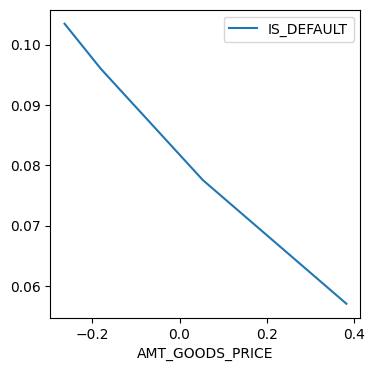

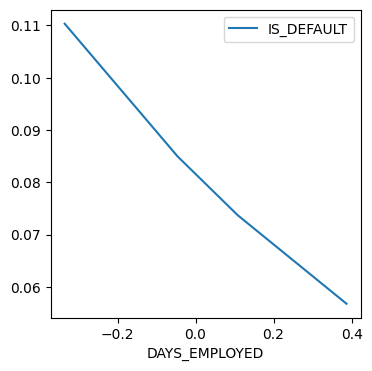

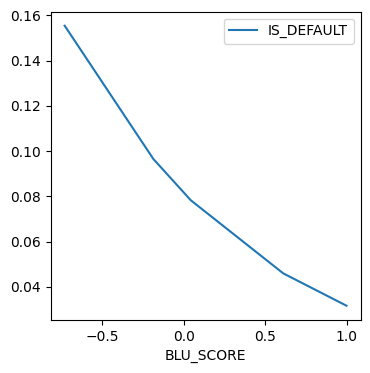

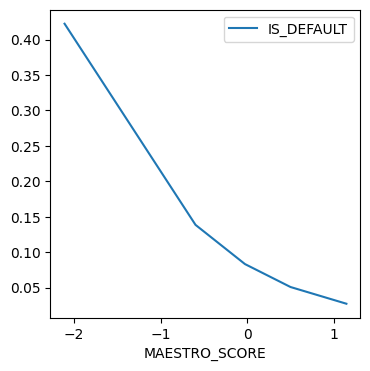

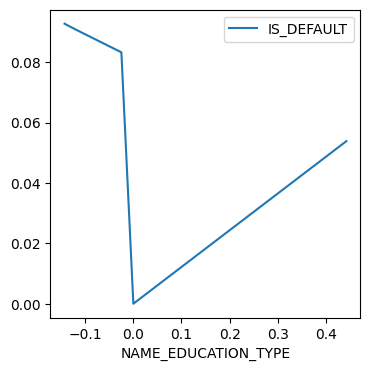

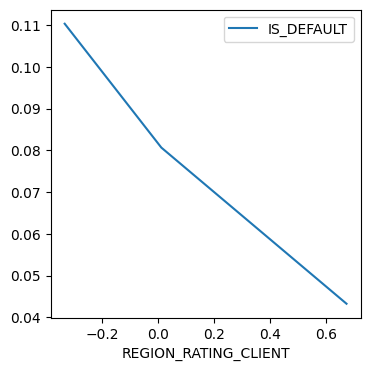

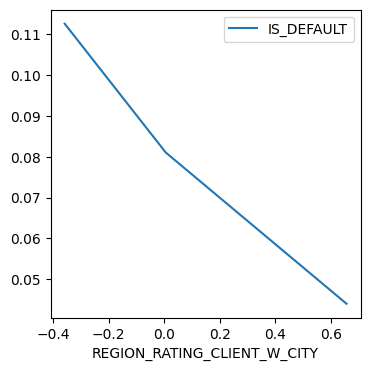

In [16]:
possible_features = []
for key in df_num_woes:
  if df_num_woes[key]['IV'].iloc[0] > 0.05:
    possible_features.append(key)

for key in df_cat_woes:
  if df_cat_woes[key]['IV'].iloc[0] > 0.05:
    possible_features.append(key)


for col in possible_features:
  df_train[[col, 'IS_DEFAULT']].groupby(col).mean().plot(figsize=(4,4))


In [17]:
df_train.head()

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
20943         -0.113333   -0.181629    -0.141312        -0.185100   
8261           0.163282    0.248298     0.072453         0.382273   
31805          0.039403    0.248298     0.072453        -0.185100   
3554          -0.092047    0.248298     0.072453         0.382273   
18393          0.163282   -0.181629    -0.141312        -0.185100   

       REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  DAYS_REGISTRATION  \
20943                   -0.043288       0.108517          -0.042989   
8261                    -0.115536       0.387030          -0.042989   
31805                   -0.115536      -0.046189          -0.081833   
3554                    -0.043288      -0.335466          -0.081833   
18393                   -0.052825       0.387030           0.204070   

       DAYS_ID_PUBLISH  OWN_CAR_AGE  BLU_SCORE  APARTMENTS_AVG  \
20943         0.254181    -0.061809   0.610583        0.187827   
8261         -0.243361    -0.061809   0.998717       -0.123529   
31805        -0.243361    -0.061809  -0.186555       -0.123529   
3554         -0.243361    -0.061809   0.610583        0.220757   
18393        -0.243361     0.383802  -0.186555       -0.123529   

       BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  \
20943          0.075114                     0.185546        -0.073638   
8261          -0.092603                    -0.130489        -0.073638   
31805         -0.092603                    -0.130489        -0.073638   
3554           0.292086                     0.212344         0.207024   
18393         -0.092603                    -0.130489        -0.073638   

       COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
20943       -0.065855      -0.065611       0.152533       0.041461   
8261        -0.065855      -0.065611      -0.123552      -0.128322   
31805       -0.065855      -0.065611      -0.123552      -0.128322   
3554         0.168031       0.354452       0.244442       0.271793   
18393       -0.065855      -0.065611      -0.123552      -0.128322   

       FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
20943      -0.065729      0.098317             -0.071137        0.160218   
8261       -0.065729     -0.090458             -0.071137       -0.125369   
31805      -0.065729     -0.090458             -0.071137       -0.125369   
3554        0.332434      0.230638              0.201435        0.332521   
18393      -0.065729     -0.090458             -0.071137       -0.125369   

       NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
20943                -0.027143          -0.060327         0.149599   
8261                 -0.027143          -0.060327        -0.123529   
31805                -0.027143          -0.060327        -0.123529   
3554                  0.264766           0.158915         0.232659   
18393                -0.027143          -0.060327        -0.123529   

       BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
20943           0.091320                      0.169591         -0.073638   
8261           -0.092603                     -0.130489         -0.073638   
31805          -0.092603                     -0.130489         -0.073638   
3554            0.261315                      0.140926          0.207897   
18393          -0.092603                     -0.130489         -0.073638   

       COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
20943        -0.065855       -0.058314        0.155610        0.053884   
8261         -0.065855       -0.058314       -0.123552       -0.126647   
31805        -0.065855       -0.058314       -0.123552       -0.126647   
3554          0.168442        0.350987        0.247345        0.246024   
18393        -0.065855       -0.058314       -0.123552       -0.126647   

       FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
20943       -0.065729       0.081358            

The Variance Inflation Factor quantifies the extend of multi-collinearity in a set of predictor variables via linear regression. Multicollinearity occurs when two or more independent variables in a regression model are highly correlated, making it challenging to isolate the individual effect of each variable on the dependent variable. VIF is used to assess how much the variance of an estimated regression coefficient increases due to multicollinearity.

$VIF_I = \frac{1}{1 - R_i^2} $

where $R_i^2$ is the $R^2$ value obtained by regressing ith predictor variable against all other predictors. (VIF is additive). We re-calculate VIF after removing all highly correlated variables and confirm other variables are okay (independent).


In [18]:
df_train_VIF = df_train.drop(columns = 'APP_ID')
features = "+".join(df_train_VIF.drop(columns = 'IS_DEFAULT').columns)
y, X = dmatrices('IS_DEFAULT ~' + features, df_train_VIF, return_type = 'dataframe')

In [19]:
VIF_features = pd.DataFrame()
VIF_features["VIF"] = [variance_inflation_factor(X.values, i ) for i in range(X.shape[1])]
VIF_features['Features'] = X.columns

In [20]:
VIF_features.sort_values(by = 'VIF', ascending = False)

VIF                      Features
41   590.760339  YEARS_BEGINEXPLUATATION_MEDI
42   425.788173              YEARS_BUILD_MEDI
13   406.886782   YEARS_BEGINEXPLUATATION_AVG
20   393.301048                  LANDAREA_AVG
14   389.305083               YEARS_BUILD_AVG
15   345.464810                COMMONAREA_AVG
39   289.646450               APARTMENTS_MEDI
43   275.894324               COMMONAREA_MEDI
11   267.837086                APARTMENTS_AVG
45   259.788515                ENTRANCES_MEDI
47   250.262210                FLOORSMIN_MEDI
48   242.332068                 LANDAREA_MEDI
27   240.704123  YEARS_BEGINEXPLUATATION_MODE
46   211.475940                FLOORSMAX_MEDI
17   195.537112                 ENTRANCES_AVG
49   180.220493         LIVINGAPARTMENTS_MEDI
40   177.670055             BASEMENTAREA_MEDI
18   160.449615                 FLOORSMAX_AVG
21   159.497644          LIVINGAPARTMENTS_AVG
115  151.285689                   IS_STATUS_X
12   147.908143              BASEMENTAREA_AVG
29   133.822278               COMMONAREA_MODE
33   128.409243                FLOORSMIN_MODE
28   127.625735              YEARS_BUILD_MODE
31   121.983903                ENTRANCES_MODE
22   121.165024                LIVINGAREA_AVG
50   111.498191               LIVINGAREA_MEDI
19   105.502705                 FLOORSMIN_AVG
44    95.044857                ELEVATORS_MEDI
114   91.592533                   IS_STATUS_C
74    77.320984                MONTHS_BALANCE
16    73.641204                 ELEVATORS_AVG
32    65.751342                FLOORSMAX_MODE
113   64.394055                   IS_STATUS_0
34    59.988980                 LANDAREA_MODE
26    49.740070             BASEMENTAREA_MODE
35    48.346450         LIVINGAPARTMENTS_MODE
25    40.972424               APARTMENTS_MODE
30    31.341079                ELEVATORS_MODE
36    25.341631               LIVINGAREA_MODE
52    23.240227            NONLIVINGAREA_MEDI
62    19.655365               IS_STATUS_0_max
24    19.004042             NONLIVINGAREA_AVG
53    16.309715                TOTALAREA_MODE
75    13.080232                           AGE
76    12.830005                         COUNT
94    12.247838          REGION_RATING_CLIENT
95    11.853600   REGION_RATING_CLIENT_W_CITY
109   10.711672      OBS_30_CNT_SOCIAL_CIRCLE
111   10.623261      OBS_60_CNT_SOCIAL_CIRCLE
99     9.891155    REG_REGION_NOT_WORK_REGION
38     9.330297            NONLIVINGAREA_MODE
65     8.469950               IS_STATUS_C_max
100    8.008867   LIVE_REGION_NOT_WORK_REGION
108    7.724817           EMERGENCYSTATE_MODE
102    7.491436        REG_CITY_NOT_WORK_CITY
51     7.178632      NONLIVINGAPARTMENTS_MEDI
106    7.117638                HOUSETYPE_MODE
116    6.607852               IS_STATUS_OTHER
103    5.946038       LIVE_CITY_NOT_WORK_CITY
68     5.841321               IS_STATUS_X_max
23     5.770817       NONLIVINGAPARTMENTS_AVG
66     5.262906               IS_STATUS_C_min
64     4.961960              IS_STATUS_0_mean
107    4.429611            WALLSMATERIAL_MODE
67     4.073854              IS_STATUS_C_mean
87     3.669688                FLAG_EMP_PHONE
37     3.378859      NONLIVINGAPARTMENTS_MODE
110    2.950412      DEF_30_CNT_SOCIAL_CIRCLE
112    2.879445      DEF_60_CNT_SOCIAL_CIRCLE
104    2.678970             ORGANIZATION_TYPE
98     2.608428    REG_REGION_NOT_LIVE_REGION
4      2.506967               AMT_GOODS_PRICE
69     2.491715               IS_STATUS_X_min
2      2.489795                    AMT_CREDIT
101    2.463683        REG_CITY_NOT_LIVE_CITY
105    2.402190            FONDKAPREMONT_MODE
80     2.165039                  CNT_CHILDREN
82     2.154014              NAME_INCOME_TYPE
73     2.149065                     BUREAU_ID
93     2.093517               CNT_FAM_MEMBERS
63     1.941670               IS_STATUS_0_min
78     1.840364                  FLAG_OWN_CAR
9      1.824510                   OWN_CAR_AGE
70     1.658896              IS_STATUS_X_mean
117    1.622506                       Outlier
5      1.3

In [21]:
VIF_features_cleaned = VIF_features[VIF_features['VIF'] < 5 ]
VIF_features_cleaned.sort_values('VIF', ascending = False)

VIF                    Features
64   4.961960            IS_STATUS_0_mean
107  4.429611          WALLSMATERIAL_MODE
67   4.073854            IS_STATUS_C_mean
87   3.669688              FLAG_EMP_PHONE
37   3.378859    NONLIVINGAPARTMENTS_MODE
110  2.950412    DEF_30_CNT_SOCIAL_CIRCLE
112  2.879445    DEF_60_CNT_SOCIAL_CIRCLE
104  2.678970           ORGANIZATION_TYPE
98   2.608428  REG_REGION_NOT_LIVE_REGION
4    2.506967             AMT_GOODS_PRICE
69   2.491715             IS_STATUS_X_min
2    2.489795                  AMT_CREDIT
101  2.463683      REG_CITY_NOT_LIVE_CITY
105  2.402190          FONDKAPREMONT_MODE
80   2.165039                CNT_CHILDREN
82   2.154014            NAME_INCOME_TYPE
73   2.149065                   BUREAU_ID
93   2.093517             CNT_FAM_MEMBERS
63   1.941670             IS_STATUS_0_min
78   1.840364                FLAG_OWN_CAR
9    1.824510                 OWN_CAR_AGE
70   1.658896            IS_STATUS_X_mean
117  1.622506                     Outlier
5    1.384246  REGION_POPULATION_RELATIVE
71   1.357601         IS_STATUS_OTHER_max
92   1.357094             OCCUPATION_TYPE
57   1.238568  AMT_REQ_CREDIT_BUREAU_WEEK
88   1.204009             FLAG_WORK_PHONE
0    1.197385                   Intercept
77   1.167420          NAME_CONTRACT_TYPE
3    1.160716                 AMT_ANNUITY
83   1.146369         NAME_EDUCATION_TYPE
8    1.141151             DAYS_ID_PUBLISH
90   1.138819                  FLAG_PHONE
6    1.115633               DAYS_EMPLOYED
10   1.112924                   BLU_SCORE
7    1.100747           DAYS_REGISTRATION
85   1.088790           NAME_HOUSING_TYPE
1    1.084219            AMT_INCOME_TOTAL
84   1.083910          NAME_FAMILY_STATUS
79   1.078500             FLAG_OWN_REALTY
54   1.067166      DAYS_LAST_PHONE_CHANGE
91   1.039859                  FLAG_EMAIL
58   1.038362   AMT_REQ_CREDIT_BUREAU_MON
60   1.030594  AMT_REQ_CREDIT_BUREAU_YEAR
59   1.020885   AMT_REQ_CREDIT_BUREAU_QRT
89   1.016696            FLAG_CONT_MOBILE
81   1.014754             NAME_TYPE_SUITE
97   1.006660     HOUR_APPR_PROCESS_START
96   1.005734  WEEKDAY_APPR_PROCESS_START
61   1.005280               MAESTRO_SCORE

Re-Run VIF after eliminating initial correlated variables, this is to confirm we eliminated all necessary variables. Note this is for analysis purposes, we just write out the script, one should probably encompass these calculations below into a function or multiple functions for re-usability.

In [22]:
df_train_VIF_v2 = df_train_VIF[VIF_features_cleaned['Features'][1:-1]]
df_train_VIF_v2['IS_DEFAULT'] = df_train_VIF['IS_DEFAULT']
features = "+".join(df_train_VIF_v2.drop(columns = 'IS_DEFAULT').columns)
y2, X2 = dmatrices('IS_DEFAULT ~' + features, df_train_VIF_v2, return_type = 'dataframe')

In [23]:
VIF_features_v2 = pd.DataFrame()
VIF_features_v2["VIF"] = [variance_inflation_factor(X2.values, i ) for i in range(X2.shape[1])]
VIF_features_v2['Features'] = X2.columns

In [24]:
VIF_features_v2.sort_values(by = 'VIF', ascending = False)

VIF                    Features
34  3.584819              FLAG_EMP_PHONE
48  2.841760    DEF_30_CNT_SOCIAL_CIRCLE
49  2.840577    DEF_60_CNT_SOCIAL_CIRCLE
19  2.721951            IS_STATUS_0_mean
45  2.666001           ORGANIZATION_TYPE
4   2.495750             AMT_GOODS_PRICE
2   2.484519                  AMT_CREDIT
20  2.444957            IS_STATUS_C_mean
28  2.156866                CNT_CHILDREN
30  2.133640            NAME_INCOME_TYPE
40  2.086805             CNT_FAM_MEMBERS
26  1.818596                FLAG_OWN_CAR
9   1.810836                 OWN_CAR_AGE
46  1.520370          FONDKAPREMONT_MODE
47  1.456762          WALLSMATERIAL_MODE
21  1.429715             IS_STATUS_X_min
39  1.351548             OCCUPATION_TYPE
24  1.299704                   BUREAU_ID
22  1.212962            IS_STATUS_X_mean
35  1.195349             FLAG_WORK_PHONE
0   1.190200                   Intercept
44  1.190027      REG_CITY_NOT_LIVE_CITY
11  1.185729    NONLIVINGAPARTMENTS_MODE
3   1.156625                 AMT_ANNUITY
25  1.152232          NAME_CONTRACT_TYPE
23  1.152125         IS_STATUS_OTHER_max
43  1.147148  REG_REGION_NOT_LIVE_REGION
8   1.136582             DAYS_ID_PUBLISH
31  1.131962         NAME_EDUCATION_TYPE
37  1.127015                  FLAG_PHONE
18  1.119678             IS_STATUS_0_min
6   1.105417               DAYS_EMPLOYED
10  1.103994                   BLU_SCORE
33  1.084772           NAME_HOUSING_TYPE
7   1.083712           DAYS_REGISTRATION
32  1.080696          NAME_FAMILY_STATUS
27  1.076194             FLAG_OWN_REALTY
12  1.061683      DAYS_LAST_PHONE_CHANGE
1   1.059365            AMT_INCOME_TOTAL
38  1.031446                  FLAG_EMAIL
5   1.028170  REGION_POPULATION_RELATIVE
16  1.027030  AMT_REQ_CREDIT_BUREAU_YEAR
14  1.025241   AMT_REQ_CREDIT_BUREAU_MON
36  1.013279            FLAG_CONT_MOBILE
29  1.011267             NAME_TYPE_SUITE
15  1.010568   AMT_REQ_CREDIT_BUREAU_QRT
13  1.008973  AMT_REQ_CREDIT_BUREAU_WEEK
42  1.004568     HOUR_APPR_PROCESS_START
17  1.003588               MAESTRO_SCORE
41  1.001906  WEEKDAY_APPR_PROCESS_START

So from the above table, we see VIF for the selected features is below 5 as desired. We now select the these variables (ignoring BUREAU_ID) and look up their information value from the WOE_mapper.

In [25]:
def IV_select_features (features, woe_mapper):
  # from the mapper, select the IV
  IV_df = {}
  for feature in features:
    if feature not in ['BUREAU_ID', 'Intercept']:
      IV_df[feature] = woe_mapper[feature]['IV'].iloc[0]
  return IV_df

In [26]:
df_num_woes.update(df_cat_woes)
woe_mapper = df_num_woes
desired_features_iv = IV_select_features(VIF_features_cleaned['Features'], woe_mapper)


In [27]:
# prompt: convert dictionary to dataframe
dict = {'Variable' : list(desired_features_iv.keys()), 'Information Value' : list(desired_features_iv.values()) }
IV_df = pd.DataFrame(dict)
IV_df = IV_df.sort_values(by = 'Information Value', ascending = False)
IV_df

Variable  Information Value
16               MAESTRO_SCORE           0.546160
9                    BLU_SCORE           0.342471
5                DAYS_EMPLOYED           0.067620
29         NAME_EDUCATION_TYPE           0.050932
3              AMT_GOODS_PRICE           0.050827
28            NAME_INCOME_TYPE           0.046789
37             OCCUPATION_TYPE           0.042362
11      DAYS_LAST_PHONE_CHANGE           0.042077
43           ORGANIZATION_TYPE           0.040130
7              DAYS_ID_PUBLISH           0.034906
30          NAME_FAMILY_STATUS           0.029783
1                   AMT_CREDIT           0.029428
45          WALLSMATERIAL_MODE           0.023751
32              FLAG_EMP_PHONE           0.022808
19            IS_STATUS_C_mean           0.022282
42      REG_CITY_NOT_LIVE_CITY           0.020451
8                  OWN_CAR_AGE           0.019958
18            IS_STATUS_0_mean           0.018560
23          NAME_CONTRACT_TYPE           0.017520
4   REGION_POPULATION_RELATIVE           0.017025
31           NAME_HOUSING_TYPE           0.016593
46    DEF_30_CNT_SOCIAL_CIRCLE           0.015032
44          FONDKAPREMONT_MODE           0.014479
2                  AMT_ANNUITY           0.013846
0             AMT_INCOME_TOTAL           0.012745
6            DAYS_REGISTRATION           0.012612
35                  FLAG_PHONE           0.012136
47    DEF_60_CNT_SOCIAL_CIRCLE           0.009149
33             FLAG_WORK_PHONE           0.008798
48                     Outlier           0.008556
24                FLAG_OWN_CAR           0.008120
22         IS_STATUS_OTHER_max           0.007938
15  AMT_REQ_CREDIT_BUREAU_YEAR           0.005732
13   AMT_REQ_CREDIT_BUREAU_MON           0.004869
10    NONLIVINGAPARTMENTS_MODE           0.004549
26                CNT_CHILDREN           0.002211
38             CNT_FAM_MEMBERS           0.002033
27             NAME_TYPE_SUITE           0.001661
39  WEEKDAY_APPR_PROCESS_START           0.001504
25             FLAG_OWN_REALTY           0.001001
20             IS_STATUS_X_min           0.000811
41  REG_REGION_NOT_LIVE_REGION           0.000573
14   AMT_REQ_CREDIT_BUREAU_QRT           0.000484
40     HOUR_APPR_PROCESS_START           0.000361
12  AMT_REQ_CREDIT_BUREAU_WEEK           0.000168
17             IS_STATUS_0_min           0.000159
21            IS_STATUS_X_mean           0.000157
36                  FLAG_EMAIL           0.000026
34            FLAG_CONT_MOBILE           0.000011

# Model Selection

Now we have gone through tedious and PAINFUL part of data extraction and data treatment, we can play around with models.

The problem at hand is a classification problem for the banking, loan approval, IFRS9,etc space. Here, interpretability is extremely important. This is a major reason we treated our data in a way to best suit logisitic regression (i.e. binning all variables, performing WoE, removing multicollinearity, treatment of outliers).

We will train the following models and see their performance.



1.   Logistic Regression (minimum 3 to max 12 variables)
2.   XGBoost Logistic Regression
3.   Random Forest Classifier (3 to 12 variables)
4.   Boosted Random Forest Classifier + hyper parameter tuning




Before we start, we are actually going to split the train dataset again into a train and validate dataset using the same random stratified sampling approach, utilizing a 80%/20% split.

In [28]:
df_train_train, df_train_validate = train_test_split(df_train, stratify = df_train['IS_DEFAULT'], test_size = 0.2, train_size = 0.8, random_state = 420698008 )

## Model Metrics:

* Area Under the Reciever Operator Curve (AUROC)
* Kolmogorov-Smirnov 2 sample statistic

Other considerations could be CAP, Accuracy Ratio, empirical distribution plots.


In [29]:
def get_metrics(model_map, data, test_data = None):
  stat_models = {}

  for key in model_map:
    actual_key = key.split('+')
    Y_data = data.IS_DEFAULT
    X_data = data[actual_key]

    if type(test_data) != None:
      Y_test = test_data.IS_DEFAULT
      X_test = test_data[actual_key]
      stat_models[key] = model_metrics(model_map[key], X_data, Y_data, key, X_test, Y_test)
    else:
      stat_models[key] = model_metrics(model_map[key], X_data, Y_data, key)

  return stat_models



def model_metrics(model, X_data, Y_data, key,  X_test = None, Y_test = None):
  model_pred_prob = model.predict_proba(X_data)[::,1]
  fpr, tpr, _ = metrics.roc_curve(np.array(Y_data), model_pred_prob)

  if (type(X_test) != None) and (type(Y_test) != None):
    test_pred_proba = model.predict_proba(X_test)[::,1]
    fpr_test, tpr_test, _ = metrics.roc_curve(np.array(Y_test), test_pred_proba)
    auc_test = metrics.roc_auc_score(np.array(Y_test), test_pred_proba)
    KS_test_df = pd.DataFrame({'IS_DEFAULT': Y_test, 'X_probability': test_pred_proba} )
    KS_test_stat = stats.ks_2samp(KS_test_df[KS_test_df['IS_DEFAULT'] == 0 ].X_probability, KS_test_df[KS_test_df['IS_DEFAULT'] == 1].X_probability )
  # AUROC
  plt.title("Area under ROC for " + key)
  auc = metrics.roc_auc_score(np.array(Y_data),model_pred_prob)
  plt.plot(fpr,tpr, label = "dataset 1 AUC: "+str(round(auc, 6)))
  plt.axline((0,0), slope=1, c = 'b', linestyle = '--', label = 'Random Model')
  if (type(X_test) != None) and (type(Y_test) != None):
    plt.plot(fpr_test,tpr_test, label = "dataset 2 AUC: "+str(round(auc_test, 6)))
  plt.legend(loc=4)
  plt.show()

  # Kolmogorov-Smirnov 2 sample test
  KS_df = pd.DataFrame({'IS_DEFAULT': Y_data, 'X_probability': model_pred_prob} )
  KS_stat = stats.ks_2samp(KS_df[KS_df['IS_DEFAULT'] == 0 ].X_probability, KS_df[KS_df['IS_DEFAULT'] == 1].X_probability )
  print('KS 2 sample test: ' + str(KS_stat) )
  if (type(X_test) != None) and (type(Y_test) != None):
    print('KS 2 sample test: ' + str(KS_test_stat) )
    return {'AUC': [auc,auc_test], 'FPR': [fpr,fpr_test], 'TPR': [tpr,tpr_test], 'Model_prediction_probabilities': [model_pred_prob,test_pred_proba], 'KS_2sample' : [KS_stat, KS_test_stat] }

  # return everything in case we need it.
  return {'AUC': auc, 'FPR': fpr, 'TPR': tpr, 'Model_prediction_probabilities': model_pred_prob, 'KS_2sample' : KS_stat}

## Logistic Regression

In [30]:
def logistic_fitter (feature_list, dataset, n):
  # keep dict of model features (key) and model fit (value)
  maps = {}
  for i in range(len(feature_list[0:n]) ):
    var = '+'.join( variable for variable in feature_list[0:i+1] )

    temp = LogisticRegression()
    temp.fit(dataset[feature_list[0:i+1]] , dataset.IS_DEFAULT)

    maps[var] = temp
  return maps


def logistic_preds(models, X_data):
  # use dict of models to create dict of model preds
  model_pred_map = {}
  for key in models:
    var_list = key.split('+')
    model_pred_map[key] = models[key].predict(X_data[var_list])
  return model_pred_map


In [31]:
top_features = list(IV_df['Variable'])

top_12_log_regs = logistic_fitter(top_features, df_train_train, 12)

top_12_log_regs_pred = logistic_preds(top_12_log_regs, df_train_train)



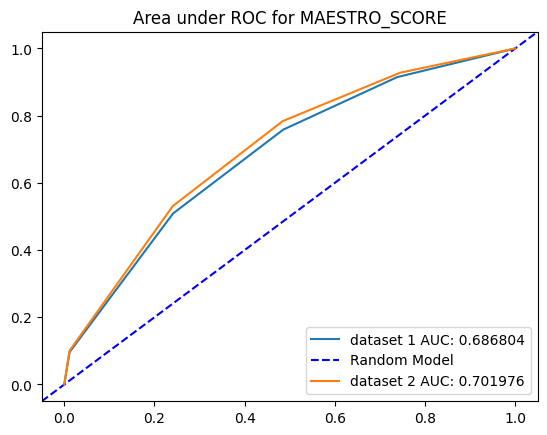

KS 2 sample test: KstestResult(statistic=0.2728065892402711, pvalue=4.688026228642501e-138, statistic_location=0.05153783658700166, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.2994076069400873, pvalue=5.507353801487158e-42, statistic_location=0.05153783658700166, statistic_sign=1)


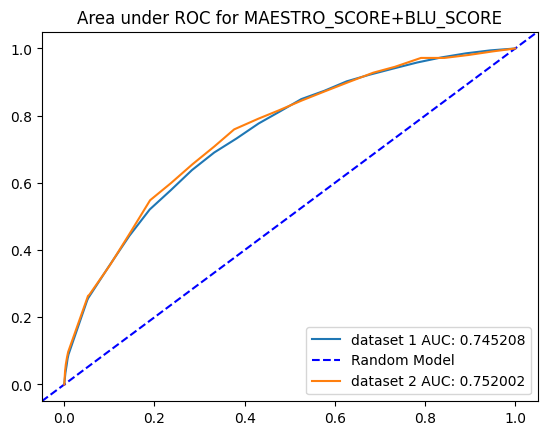

KS 2 sample test: KstestResult(statistic=0.35780175062508573, pvalue=3.0010228184772165e-240, statistic_location=0.07987610947303558, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3824354362739462, pvalue=4.506717358543176e-69, statistic_location=0.06167609972390298, statistic_sign=1)


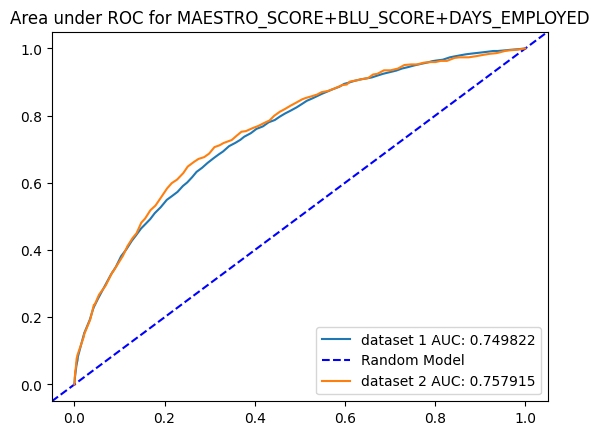

KS 2 sample test: KstestResult(statistic=0.3662091299515625, pvalue=4.940973599298864e-252, statistic_location=0.07591579242593034, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.39714534434899723, pvalue=1.1913116074297339e-74, statistic_location=0.09244878952345424, statistic_sign=1)


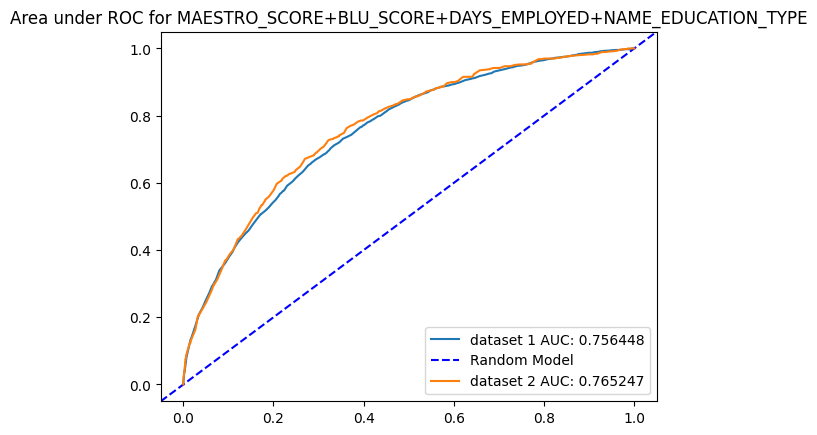

KS 2 sample test: KstestResult(statistic=0.37754713213161206, pvalue=2.0279108779902025e-268, statistic_location=0.07868886214737995, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.4048508341135183, pvalue=1.1434368104714308e-77, statistic_location=0.08091891598843448, statistic_sign=1)


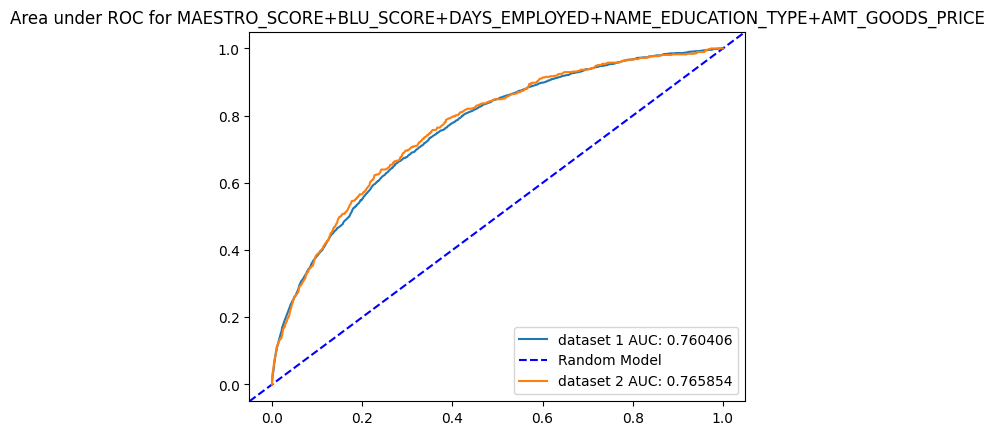

KS 2 sample test: KstestResult(statistic=0.38360818292573934, pvalue=2.0465313798847066e-277, statistic_location=0.07541232907632023, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.4015206762697852, pvalue=2.353882825869504e-76, statistic_location=0.06661423278616432, statistic_sign=1)


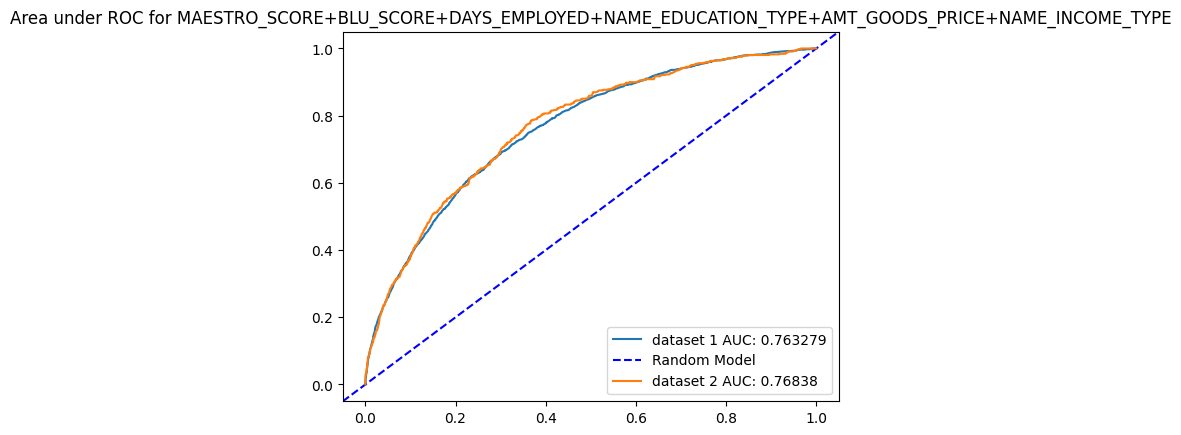

KS 2 sample test: KstestResult(statistic=0.38983881403253995, pvalue=7.765944626938221e-287, statistic_location=0.08292080343529733, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.41814326933079293, pvalue=4.946264517045274e-83, statistic_location=0.07051852872987616, statistic_sign=1)


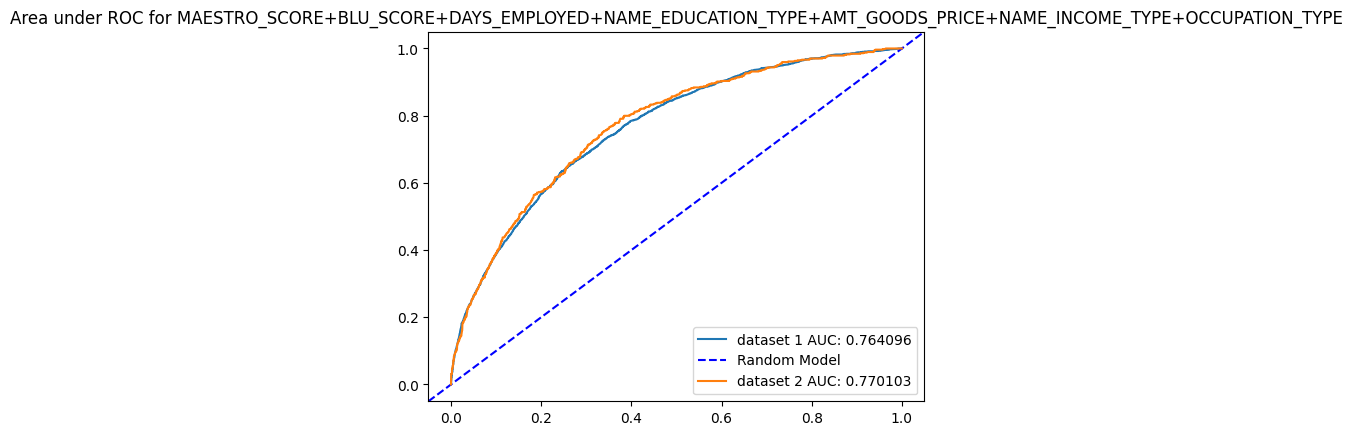

KS 2 sample test: KstestResult(statistic=0.38991289637409615, pvalue=5.985759358880195e-287, statistic_location=0.09158950567860126, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.41569211985830745, pvalue=4.9915774269926074e-82, statistic_location=0.06637869389686504, statistic_sign=1)


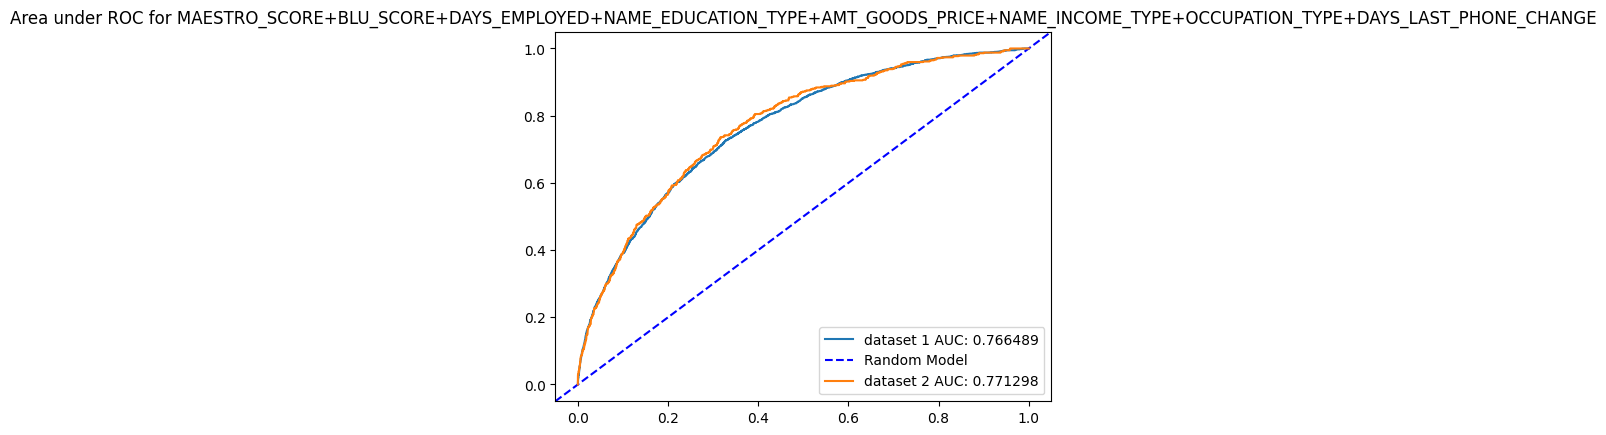

KS 2 sample test: KstestResult(statistic=0.3989270290646185, pvalue=6.777730161994199e-301, statistic_location=0.07724190239285249, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.419868709929975, pvalue=9.577390095548008e-84, statistic_location=0.08134722678090321, statistic_sign=1)


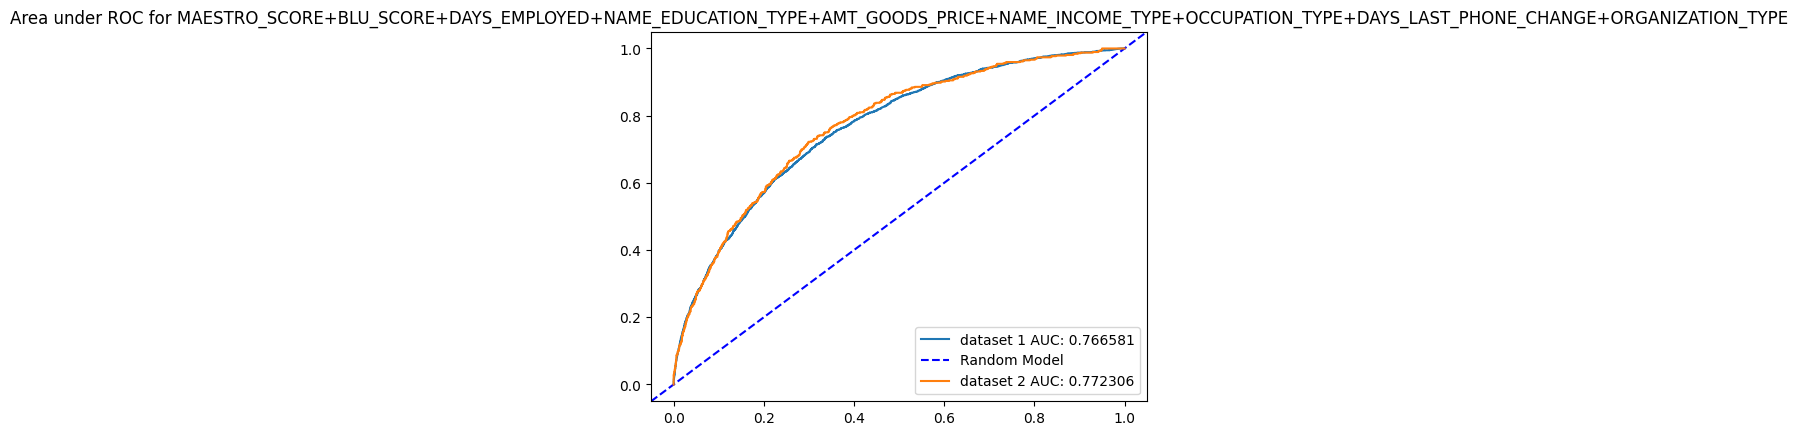

KS 2 sample test: KstestResult(statistic=0.3979923360440697, pvalue=1.9702037183329895e-299, statistic_location=0.08033162912556384, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.42278714912208665, pvalue=5.89408941193295e-85, statistic_location=0.08384130708098653, statistic_sign=1)


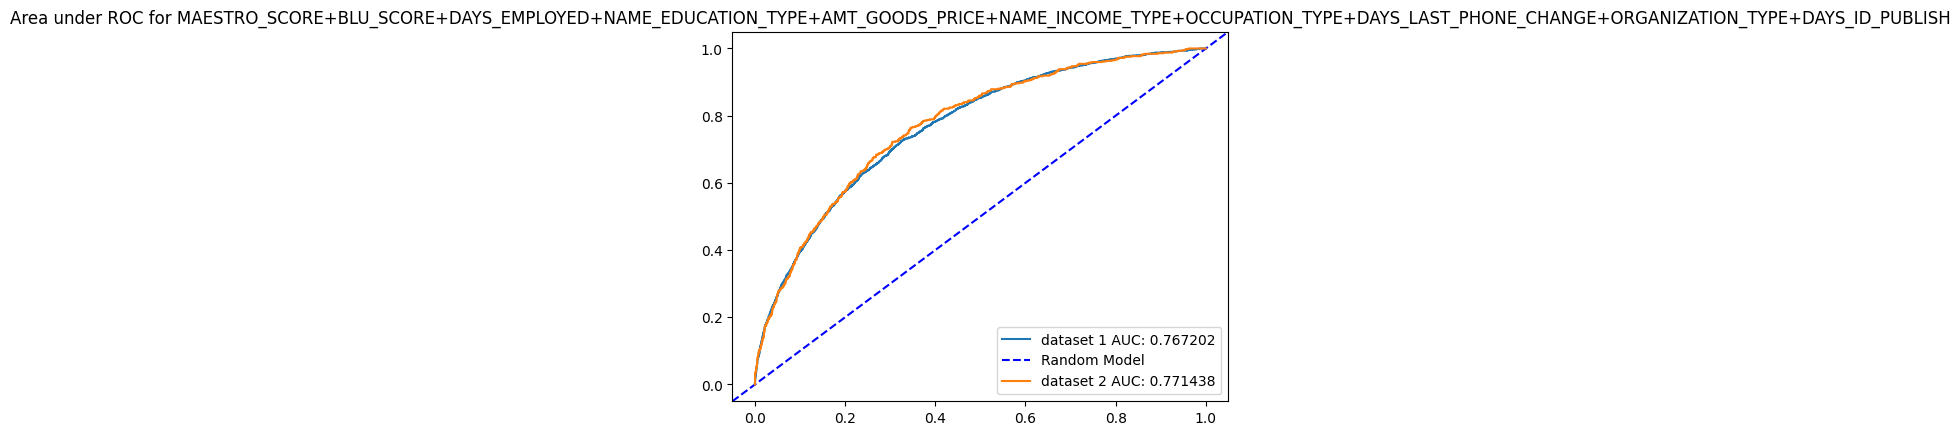

KS 2 sample test: KstestResult(statistic=0.39963482246366117, pvalue=5.250838123895397e-302, statistic_location=0.07771915239124592, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.41886049198188874, pvalue=2.5038452991671296e-83, statistic_location=0.0744514767877246, statistic_sign=1)


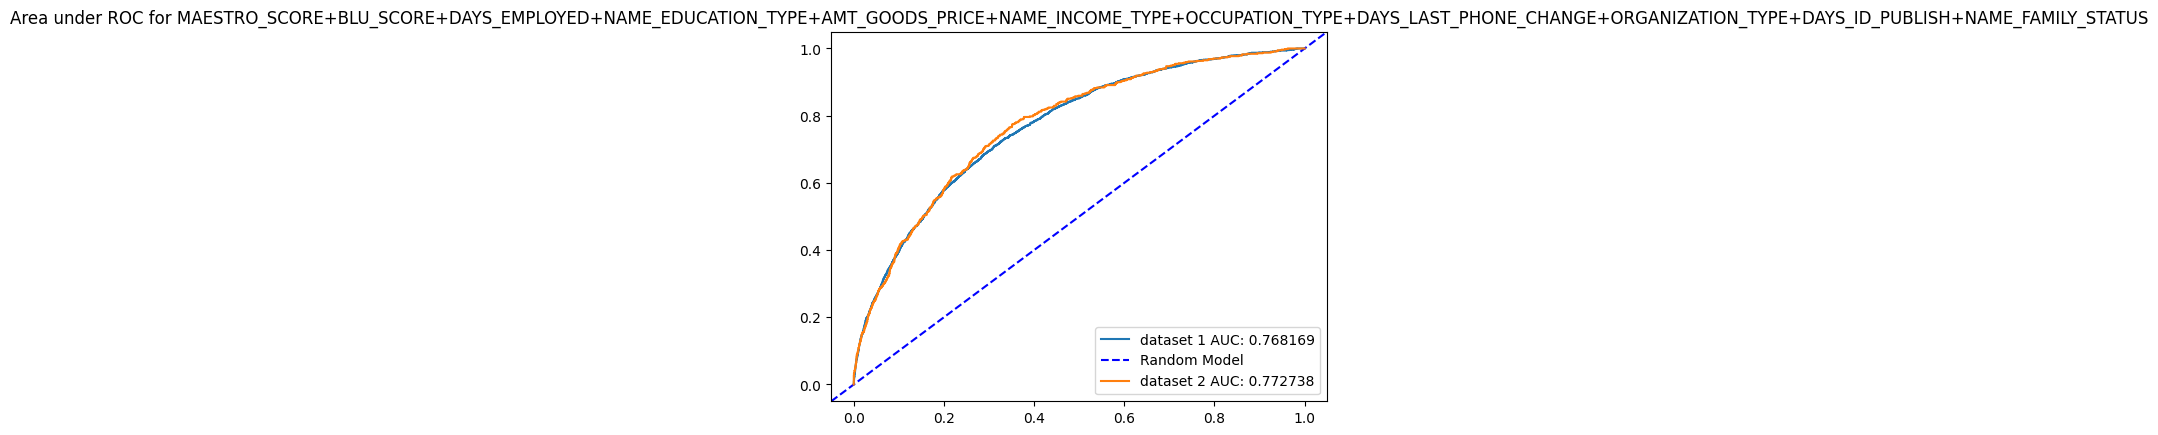

KS 2 sample test: KstestResult(statistic=0.39759481269662894, pvalue=8.235391692209933e-299, statistic_location=0.07990228151340914, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.42286325137285175, pvalue=5.49618833444344e-85, statistic_location=0.07290207729821621, statistic_sign=1)


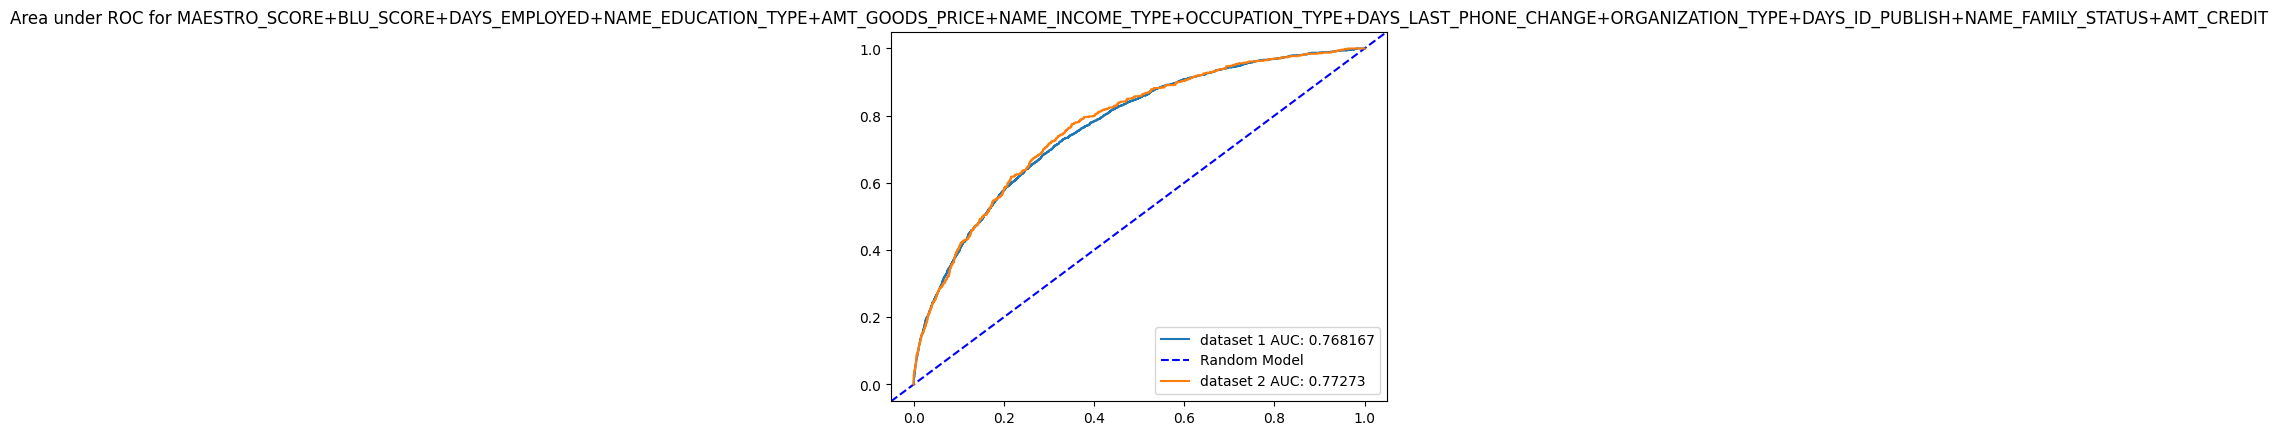

KS 2 sample test: KstestResult(statistic=0.3982514617407298, pvalue=7.748318522577735e-300, statistic_location=0.07643564603330483, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.4234863043323533, pvalue=3.0210541909596305e-85, statistic_location=0.0730953885680104, statistic_sign=1)


In [32]:
top_12_log_metrics = get_metrics(top_12_log_regs, df_train_train, df_train_validate )

We note that for the development and validating dataset that both the AUROC and KS test display stable results showing no sign of overfitting. We want to pick the smallest model that has good results. Therefore we pick the model with 4 to 5 variables. Finally, we use our testing dataset to look at how the models would perform:

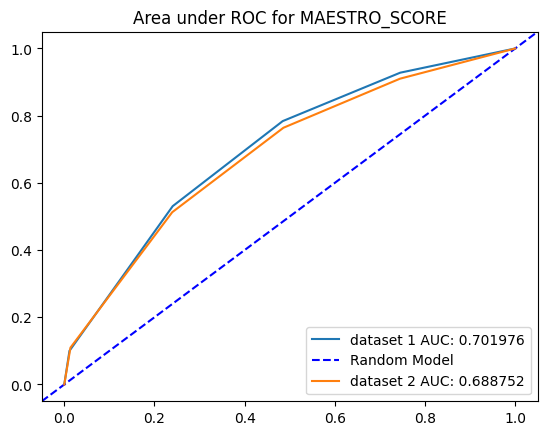

KS 2 sample test: KstestResult(statistic=0.2994076069400873, pvalue=5.507353801487158e-42, statistic_location=0.05153783658700166, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.27800306944335534, pvalue=4.002870442523542e-45, statistic_location=0.05153783658700166, statistic_sign=1)


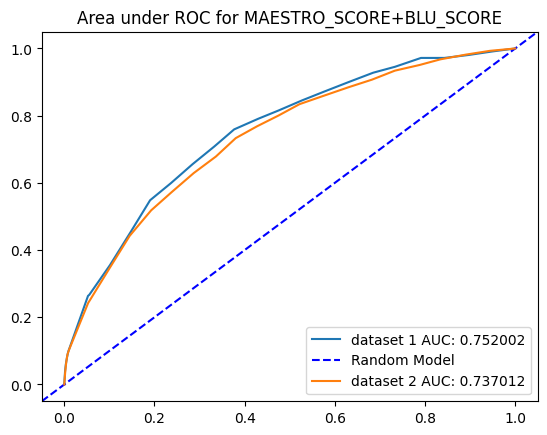

KS 2 sample test: KstestResult(statistic=0.3824354362739462, pvalue=4.506717358543176e-69, statistic_location=0.06167609972390298, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.35291177030705634, pvalue=3.425074307669958e-73, statistic_location=0.06167609972390298, statistic_sign=1)


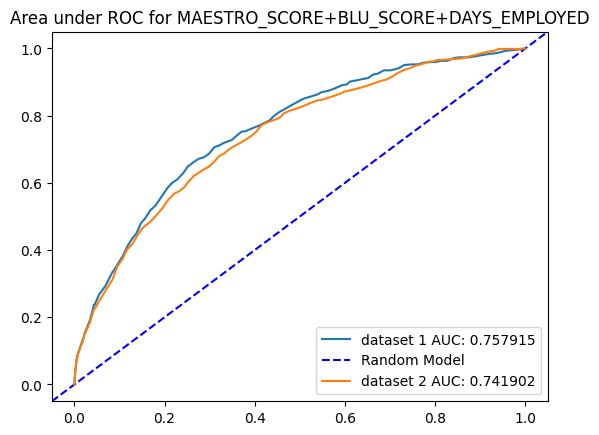

KS 2 sample test: KstestResult(statistic=0.39714534434899723, pvalue=1.1913116074297339e-74, statistic_location=0.09244878952345424, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.35886301768850754, pvalue=9.742976810938525e-76, statistic_location=0.07659098377368677, statistic_sign=1)


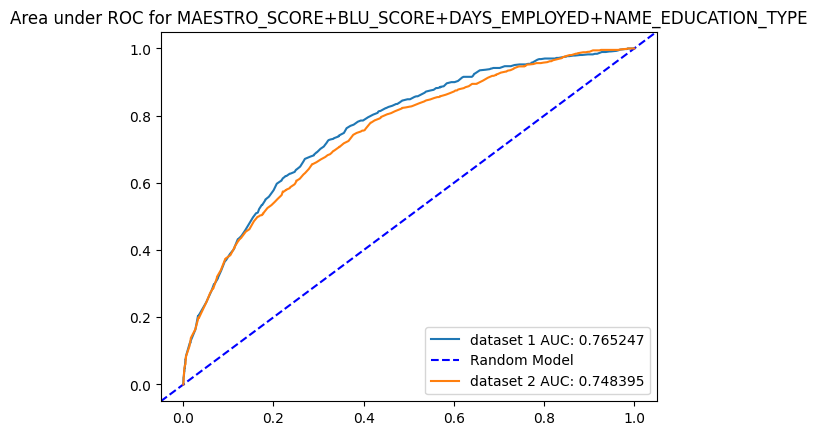

KS 2 sample test: KstestResult(statistic=0.4048508341135183, pvalue=1.1434368104714308e-77, statistic_location=0.08091891598843448, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3700065533735871, pvalue=1.2377584796706099e-80, statistic_location=0.08572054676091602, statistic_sign=1)


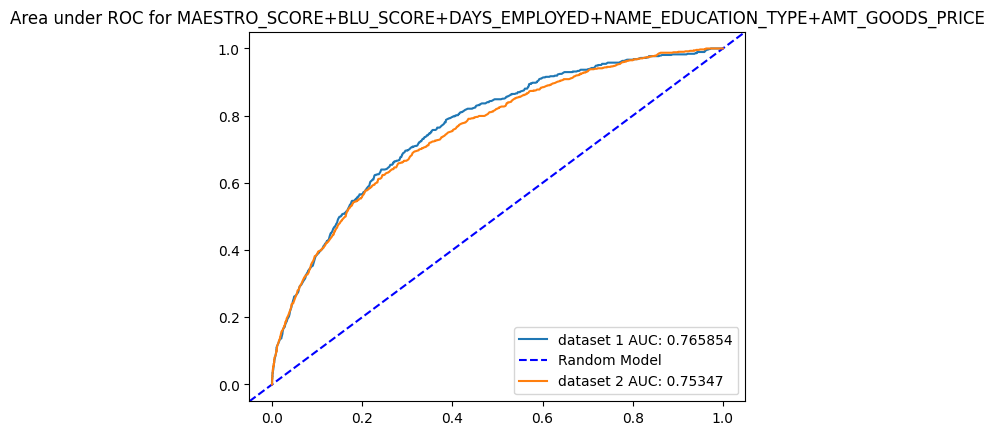

KS 2 sample test: KstestResult(statistic=0.4015206762697852, pvalue=2.353882825869504e-76, statistic_location=0.06661423278616432, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3780820459968409, pvalue=2.7509383410742067e-84, statistic_location=0.09781845028379181, statistic_sign=1)


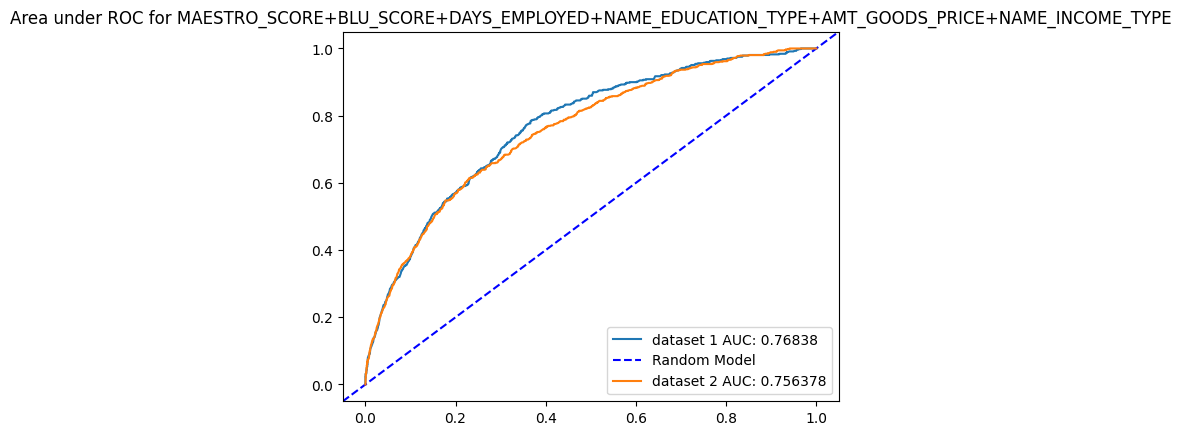

KS 2 sample test: KstestResult(statistic=0.41814326933079293, pvalue=4.946264517045274e-83, statistic_location=0.07051852872987616, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3838288505270705, pvalue=6.093187080305237e-87, statistic_location=0.10119871851585596, statistic_sign=1)


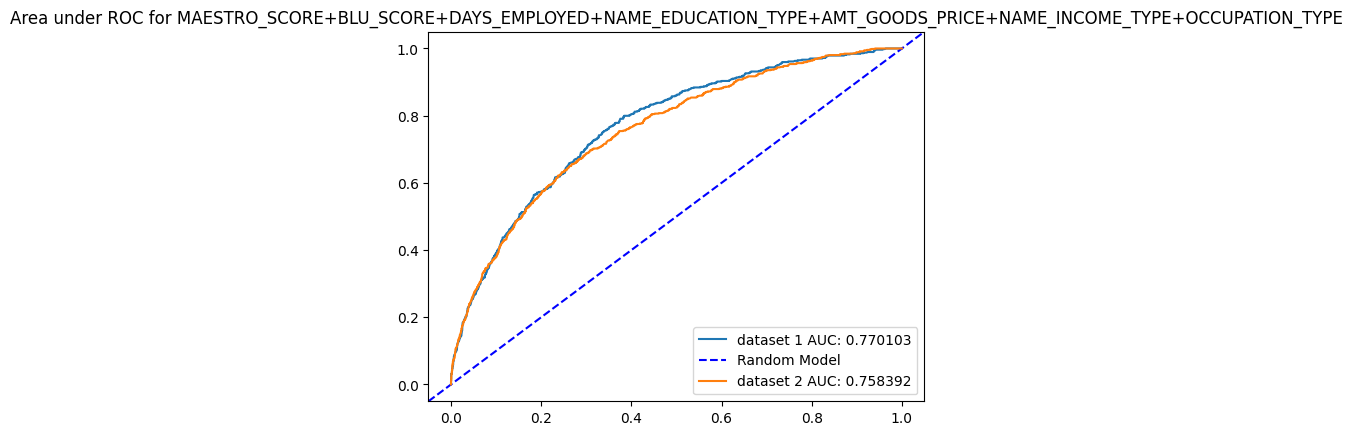

KS 2 sample test: KstestResult(statistic=0.41569211985830745, pvalue=4.9915774269926074e-82, statistic_location=0.06637869389686504, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.38880269304446213, pvalue=2.8157932242247366e-89, statistic_location=0.08132438403011331, statistic_sign=1)


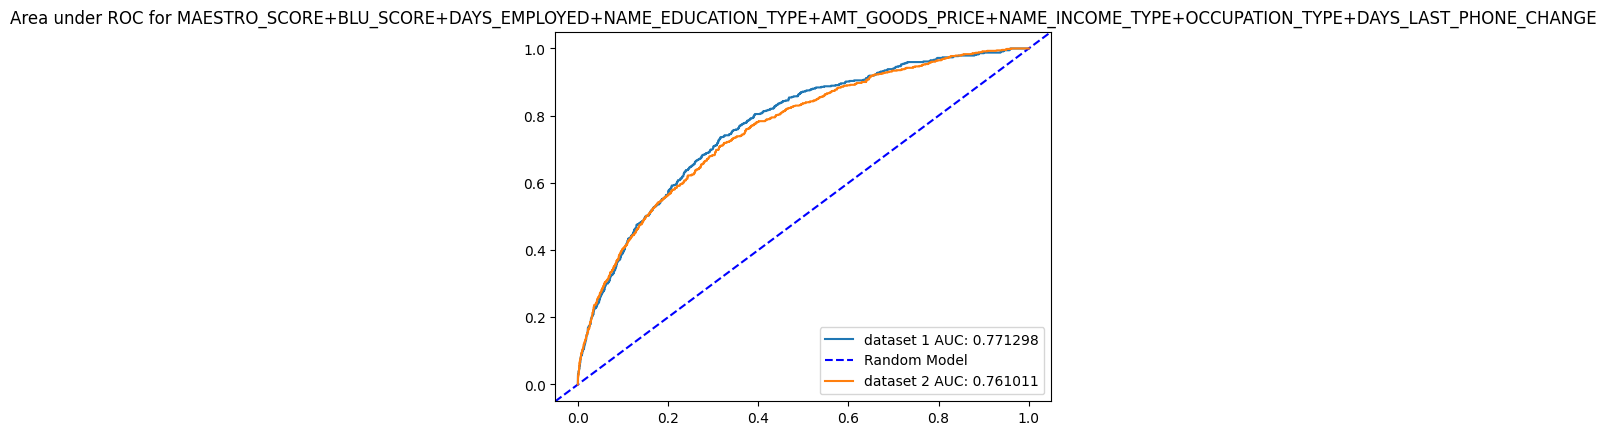

KS 2 sample test: KstestResult(statistic=0.419868709929975, pvalue=9.577390095548008e-84, statistic_location=0.08134722678090321, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3943254506144488, pvalue=6.562247371123399e-92, statistic_location=0.07745599570382256, statistic_sign=1)


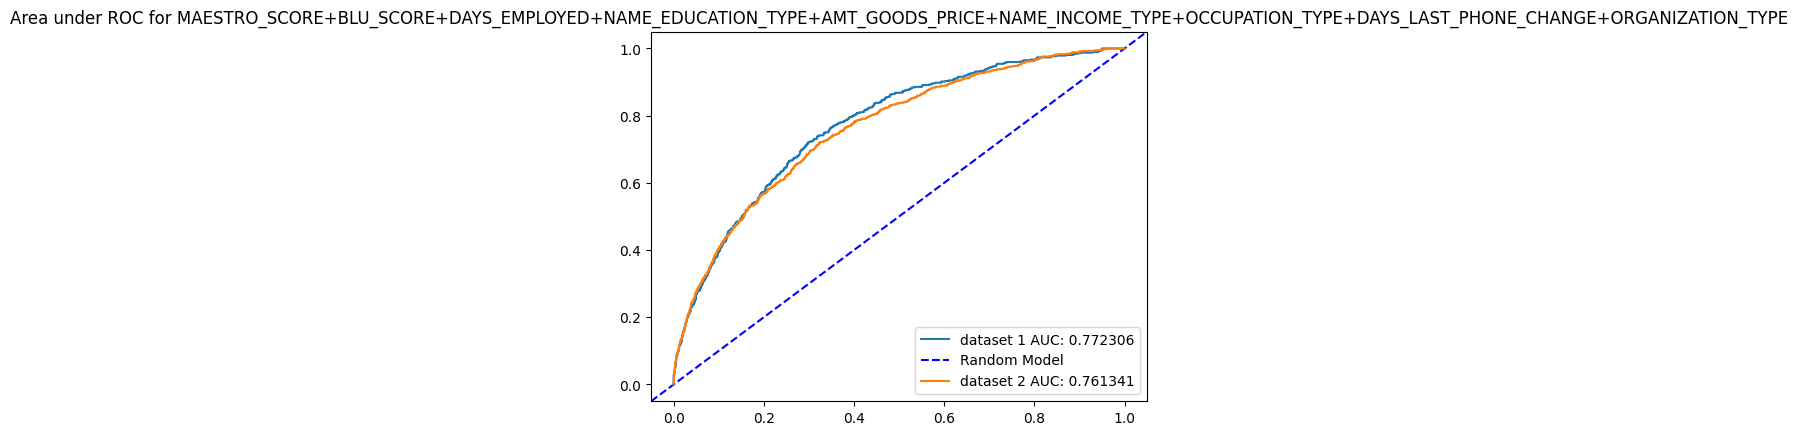

KS 2 sample test: KstestResult(statistic=0.42278714912208665, pvalue=5.89408941193295e-85, statistic_location=0.08384130708098653, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3968851871352235, pvalue=3.821623293028563e-93, statistic_location=0.07732637458929781, statistic_sign=1)


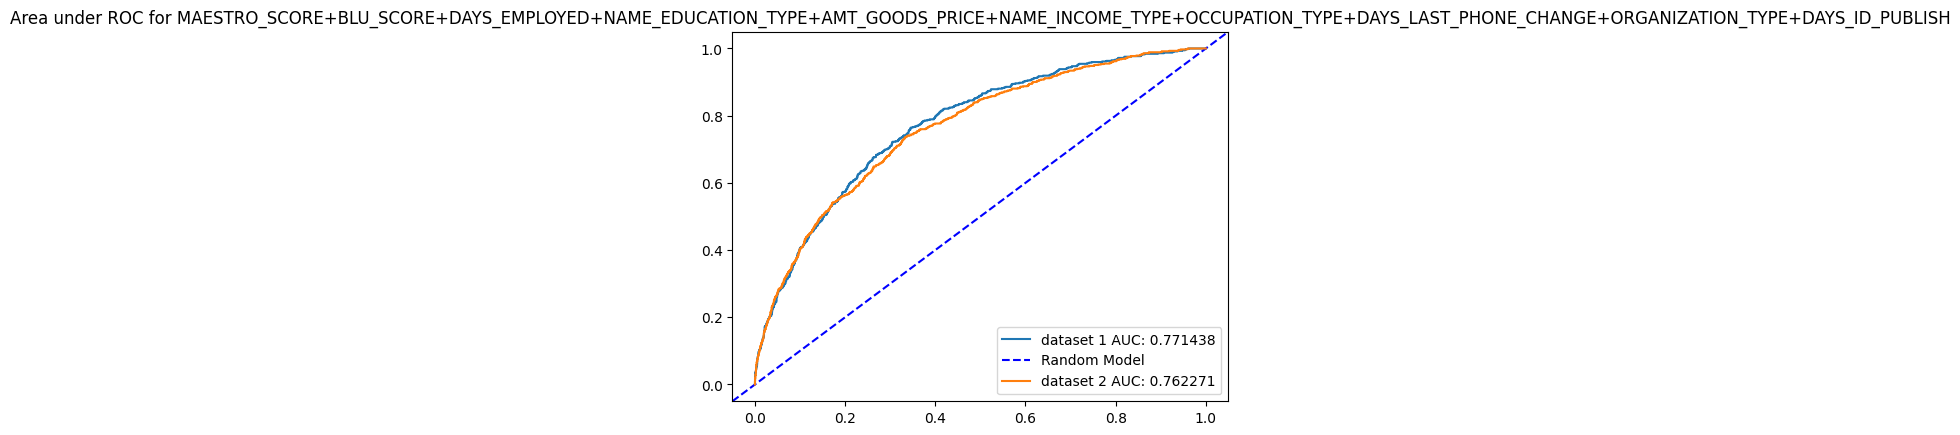

KS 2 sample test: KstestResult(statistic=0.41886049198188874, pvalue=2.5038452991671296e-83, statistic_location=0.0744514767877246, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.4026810019380062, pvalue=5.653859189601856e-96, statistic_location=0.0745454341484652, statistic_sign=1)


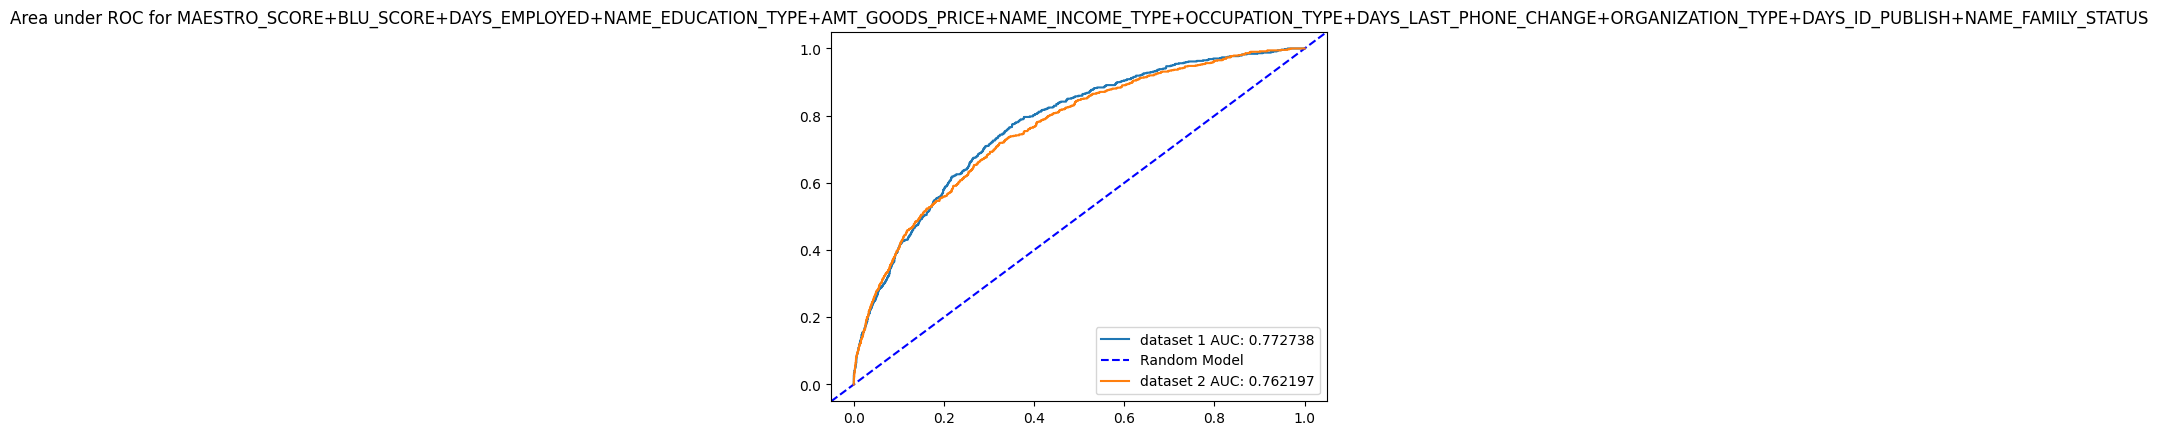

KS 2 sample test: KstestResult(statistic=0.42286325137285175, pvalue=5.49618833444344e-85, statistic_location=0.07290207729821621, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.39532245958752954, pvalue=2.1735958404306717e-92, statistic_location=0.0774127922146744, statistic_sign=1)


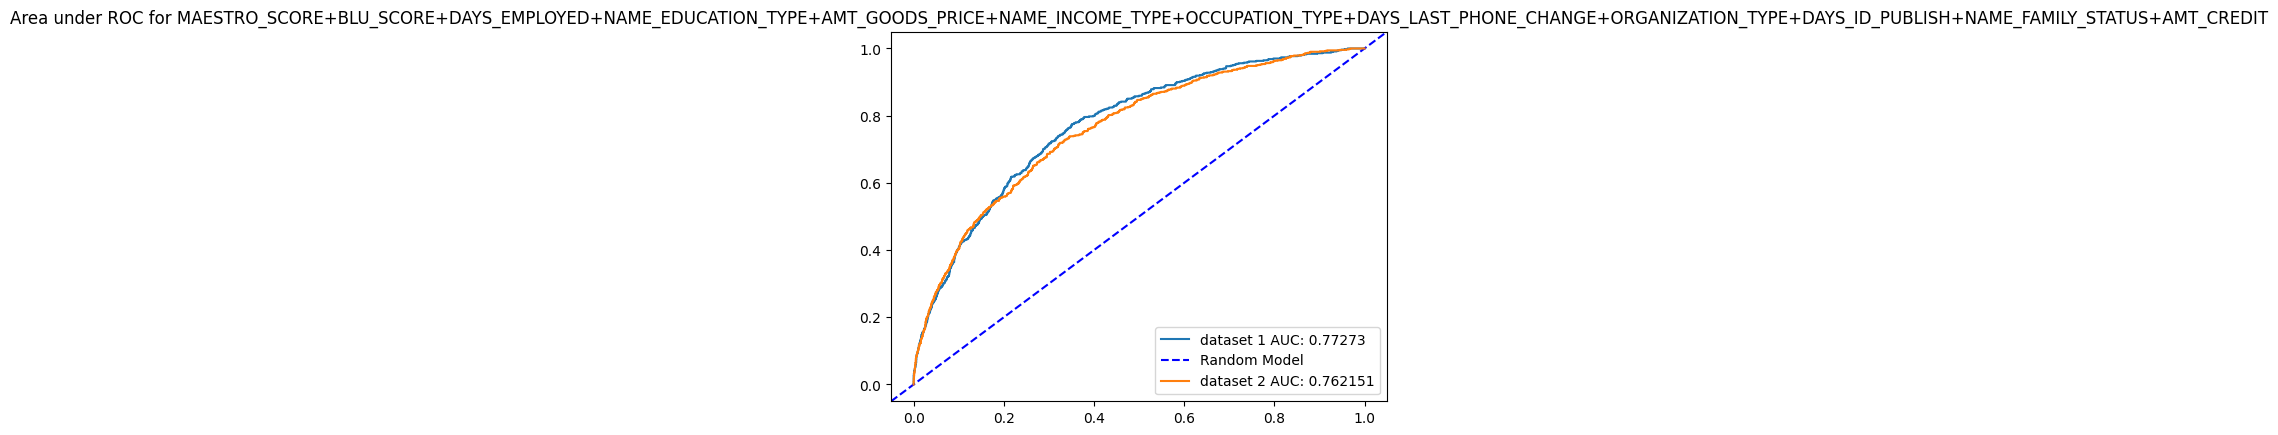

KS 2 sample test: KstestResult(statistic=0.4234863043323533, pvalue=3.0210541909596305e-85, statistic_location=0.0730953885680104, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.39482395510098917, pvalue=3.778247513828854e-92, statistic_location=0.07741616155564685, statistic_sign=1)


In [33]:
top_12_log_metrics = get_metrics(top_12_log_regs, df_train_validate, df_test )

Looking at the final model performance, we are happy with the 5 variable model: 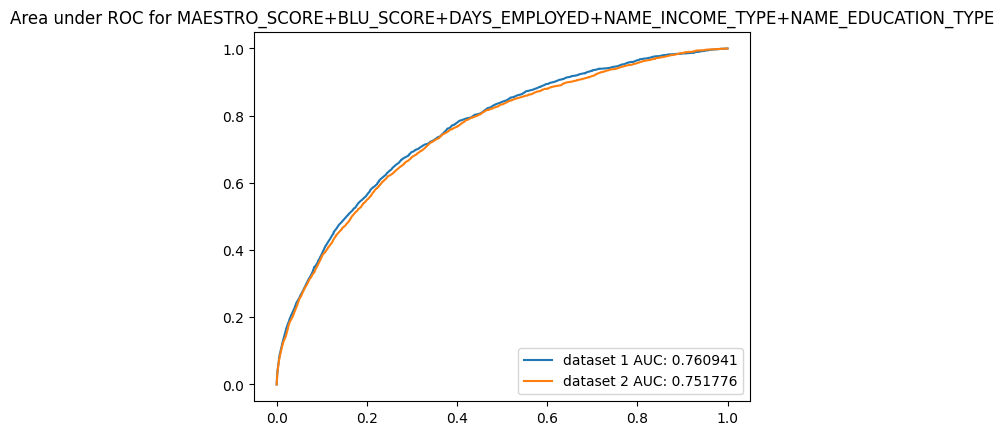
This model provides a decent accruacy of 75% on the testing data with a KS statistic of
* KS 2 sample validation results: (statistic=0.3926898737494295, pvalue=2.4876213008707004e-261, statistic_location=0.08147886437037177, statistic_sign=1)
* KS 2 sample testing: (statistic=0.37860979815981755, pvalue=1.055555901171456e-302, statistic_location=0.0767166256278786, statistic_sign=1)
* Note our threshold is KS > 0.30

In [34]:
def XGBlogistic_fitter (feature_list, dataset, n):
  # keep dict of model features (key) and model fit (value)
  maps = {}
  for i in range(len(feature_list[0:n]) ):
    var = '+'.join( variable for variable in feature_list[0:i+1] )

    temp = XGBClassifier(objective='binary:logistic')
    temp.fit(dataset[feature_list[0:i+1]] , dataset.IS_DEFAULT)

    maps[var] = temp
  return maps


def XGBlogistic_preds(models, X_data):
  # use dict of models to create dict of model preds
  model_pred_map = {}
  for key in models:
    var_list = key.split('+')
    model_pred_map[key] = models[key].predict(X_data[var_list])
  return model_pred_map

## XGBoost Logistic Regression

In [35]:
xbglog_regs = XGBlogistic_fitter(top_features, df_train_train, 12)

xgblog_regs_pred = XGBlogistic_preds(xbglog_regs, df_train_train)


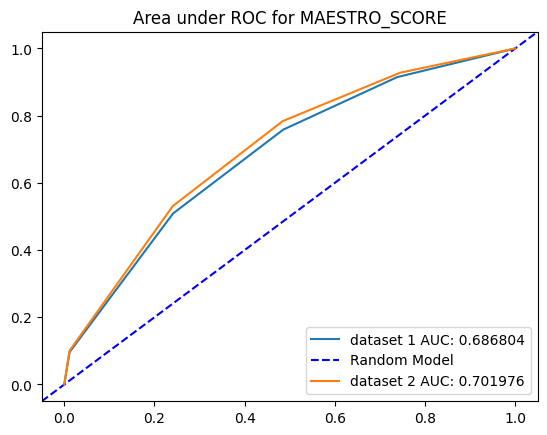

KS 2 sample test: KstestResult(statistic=0.2728065892402711, pvalue=4.688026228642501e-138, statistic_location=0.05200985, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.2994076069400873, pvalue=5.507353801487158e-42, statistic_location=0.05200985, statistic_sign=1)


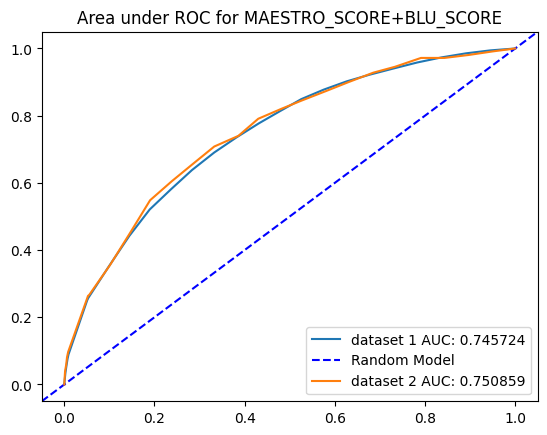

KS 2 sample test: KstestResult(statistic=0.35780175062508573, pvalue=3.0010228184772165e-240, statistic_location=0.07472618, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3755498250743229, pvalue=1.5149598986054348e-66, statistic_location=0.07472618, statistic_sign=1)


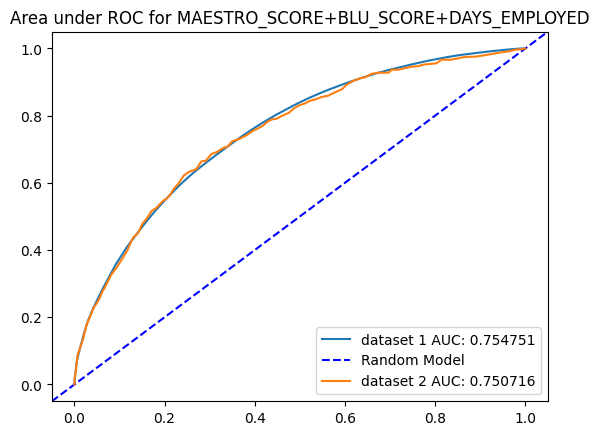

KS 2 sample test: KstestResult(statistic=0.36858643588417944, pvalue=2.0197056982747497e-255, statistic_location=0.08036219, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.38223614692661884, pvalue=5.329139135925209e-69, statistic_location=0.08738824, statistic_sign=1)


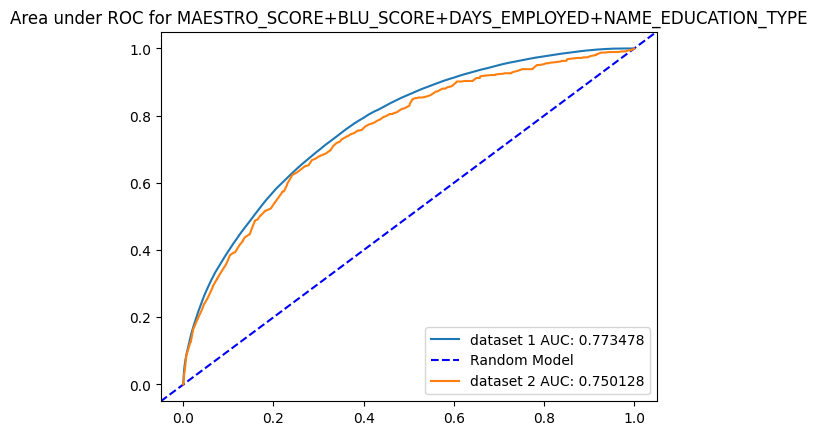

KS 2 sample test: KstestResult(statistic=0.39889598324380937, pvalue=7.581526234649311e-301, statistic_location=0.08158729, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.38279158385756284, pvalue=3.3166107633226767e-69, statistic_location=0.09213336, statistic_sign=1)


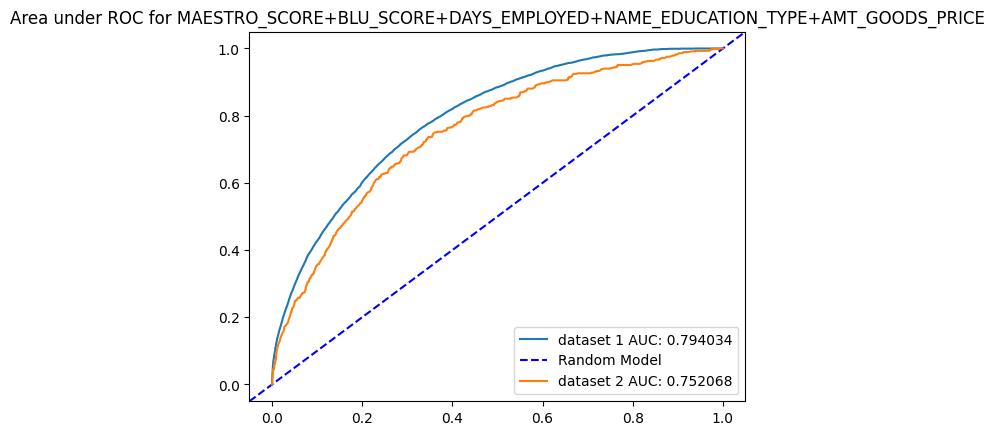

KS 2 sample test: KstestResult(statistic=0.43189864865153804, pvalue=0.0, statistic_location=0.07860424, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.38965064139414946, pvalue=8.87550684090406e-72, statistic_location=0.07782725, statistic_sign=1)


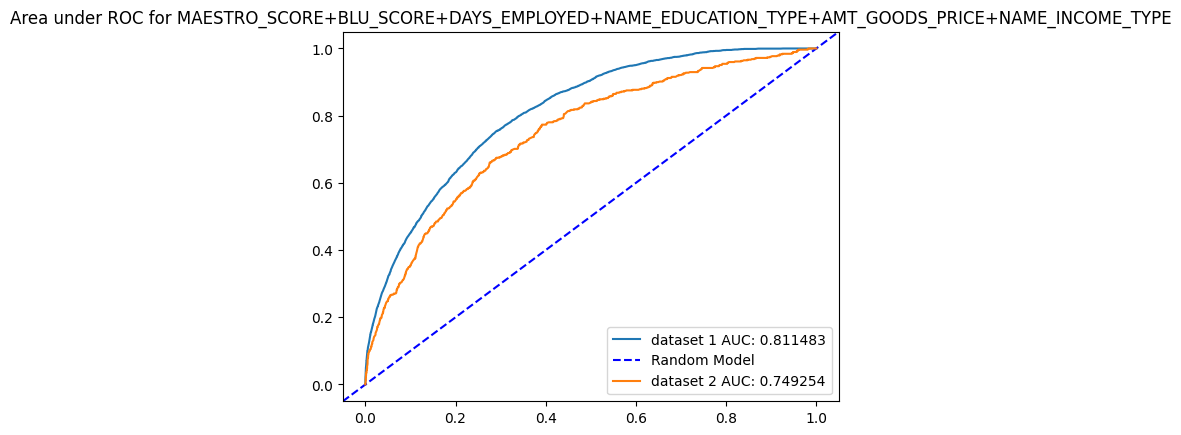

KS 2 sample test: KstestResult(statistic=0.4633797609471798, pvalue=0.0, statistic_location=0.08575027, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.38495173803305793, pvalue=5.1975089804591465e-70, statistic_location=0.09286632, statistic_sign=1)


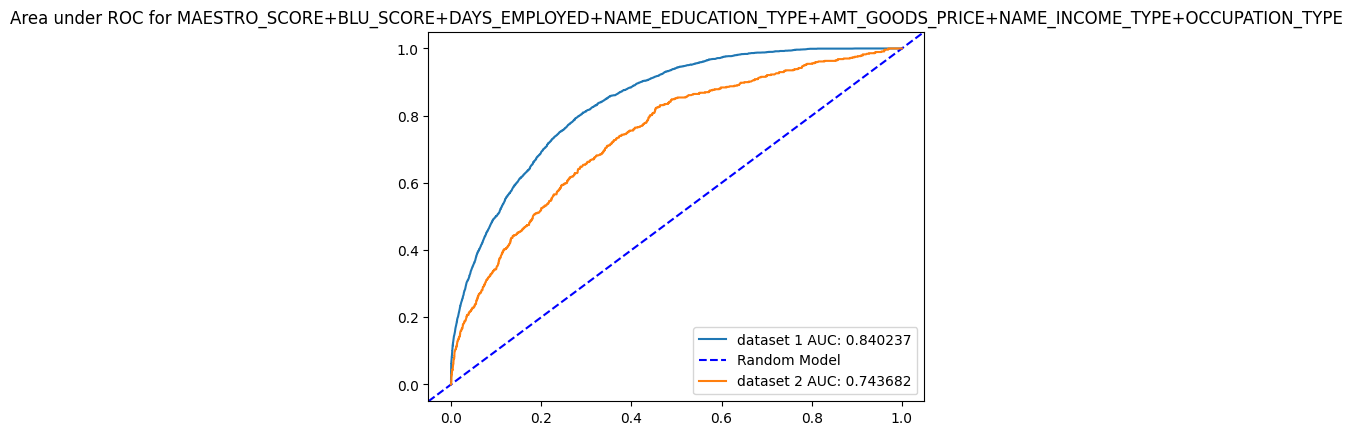

KS 2 sample test: KstestResult(statistic=0.5166662946299709, pvalue=0.0, statistic_location=0.08538462, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.36844576209012914, pvalue=5.421086391986268e-64, statistic_location=0.052494805, statistic_sign=1)


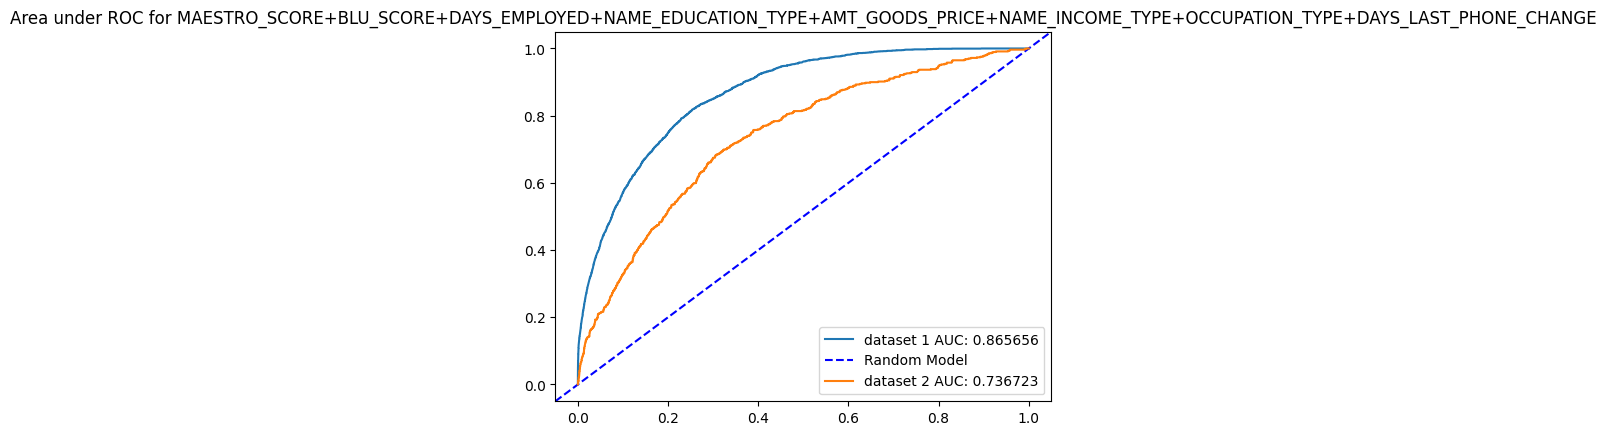

KS 2 sample test: KstestResult(statistic=0.5644263130008865, pvalue=0.0, statistic_location=0.09095032, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.37711347995335315, pvalue=4.085140831265822e-67, statistic_location=0.08016578, statistic_sign=1)


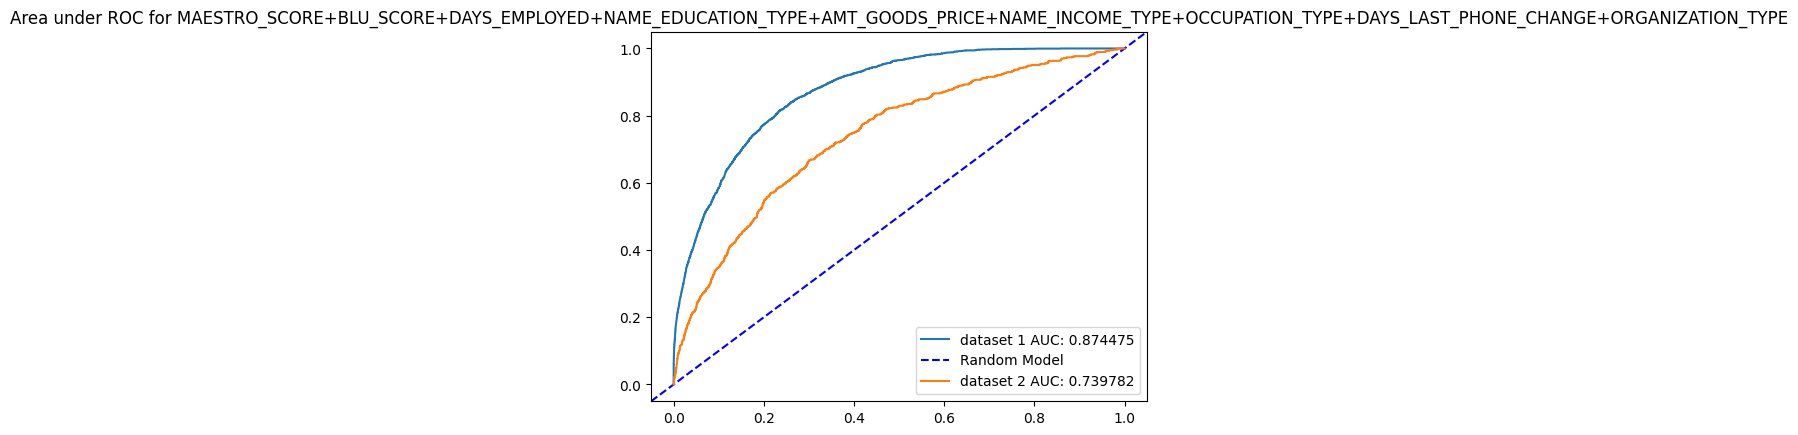

KS 2 sample test: KstestResult(statistic=0.5806167855259765, pvalue=0.0, statistic_location=0.09533797, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.36690373339027316, pvalue=1.908911995785274e-63, statistic_location=0.080300614, statistic_sign=1)


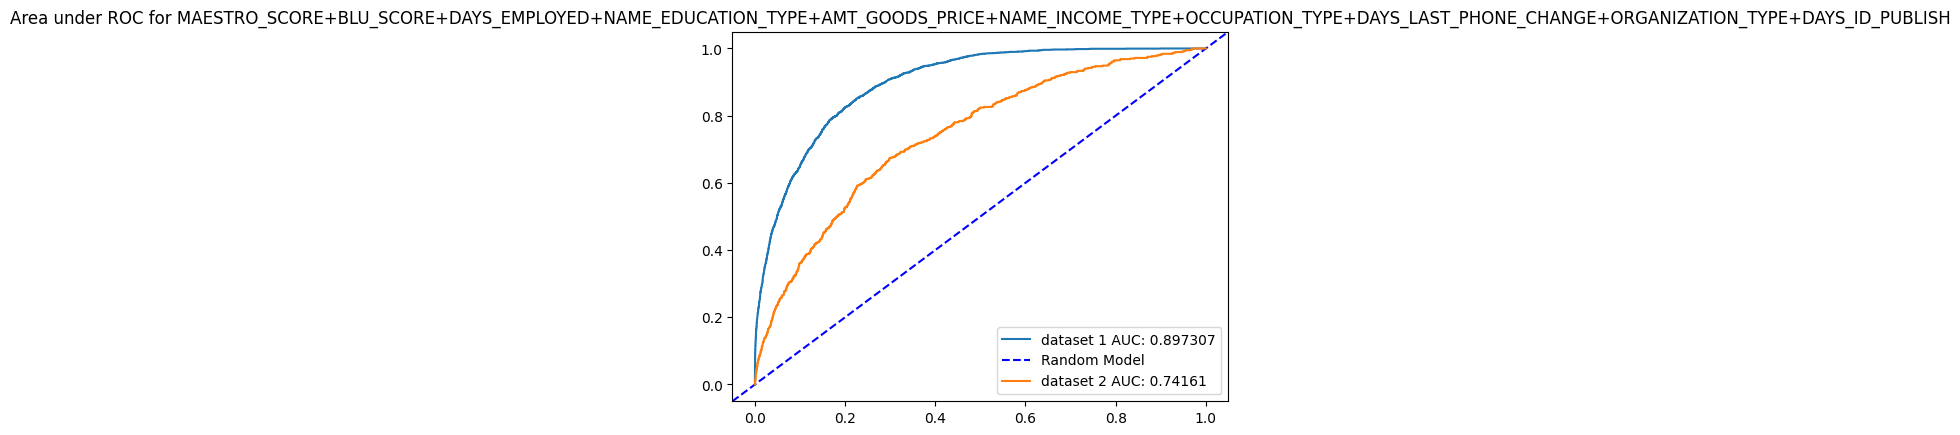

KS 2 sample test: KstestResult(statistic=0.62542067728639, pvalue=0.0, statistic_location=0.095489234, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3753354795263045, pvalue=1.8133933541820142e-66, statistic_location=0.078954615, statistic_sign=1)


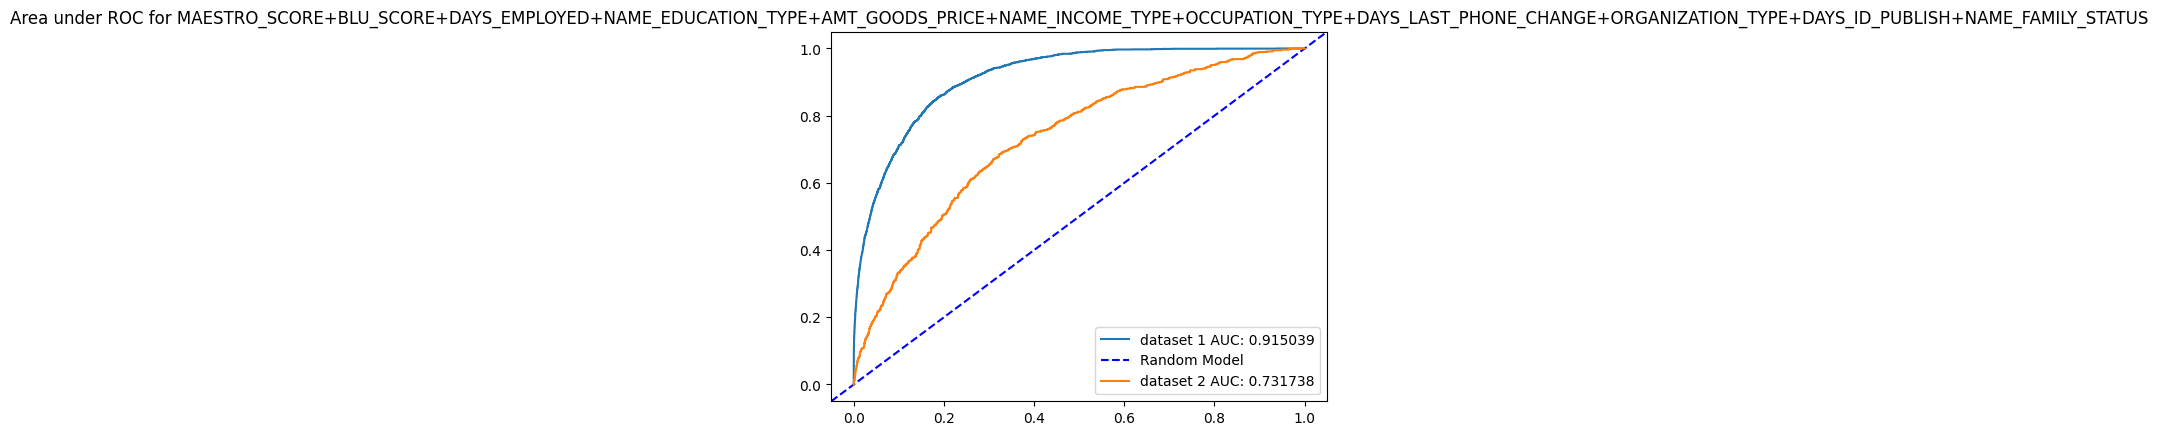

KS 2 sample test: KstestResult(statistic=0.6678650011396297, pvalue=0.0, statistic_location=0.10609547, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.36345038844997785, pvalue=3.1344508282135652e-62, statistic_location=0.07080472, statistic_sign=1)


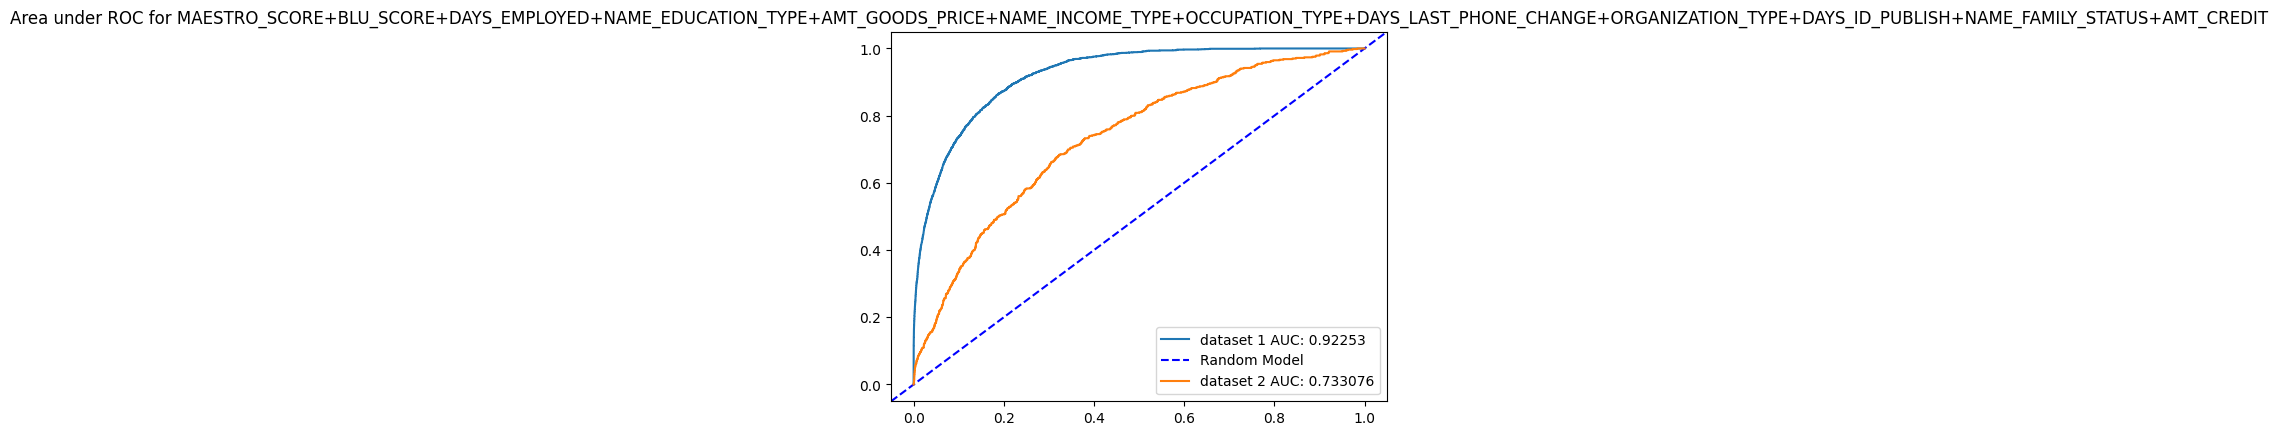

KS 2 sample test: KstestResult(statistic=0.6773925273650094, pvalue=0.0, statistic_location=0.10533129, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.36106986624618803, pvalue=2.1208168241851636e-61, statistic_location=0.067975804, statistic_sign=1)


In [36]:
top_12_xbglog_metrics = get_metrics(xbglog_regs, df_train_train, df_train_validate )

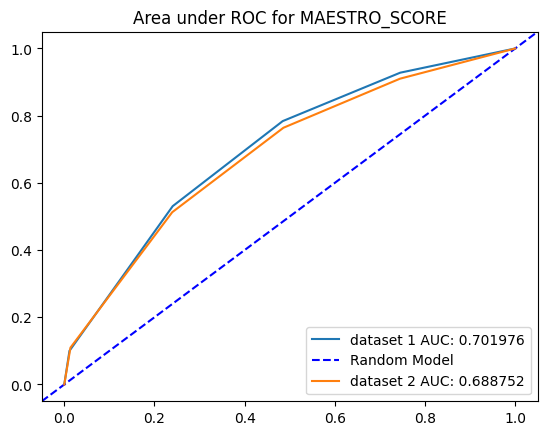

KS 2 sample test: KstestResult(statistic=0.2994076069400873, pvalue=5.507353801487158e-42, statistic_location=0.05200985, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.27800306944335534, pvalue=4.002870442523542e-45, statistic_location=0.05200985, statistic_sign=1)


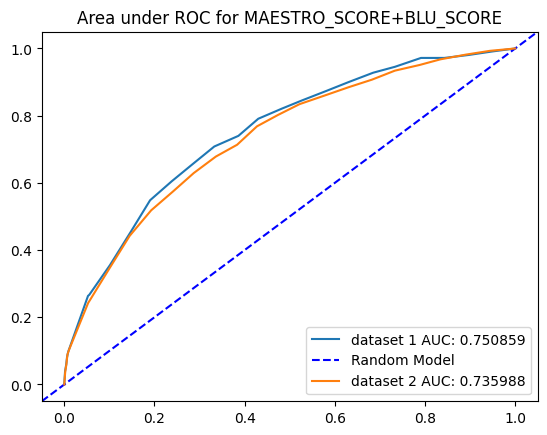

KS 2 sample test: KstestResult(statistic=0.3755498250743229, pvalue=1.5149598986054348e-66, statistic_location=0.07472618, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.34212951034536837, pvalue=1.0618923493465799e-68, statistic_location=0.07472618, statistic_sign=1)


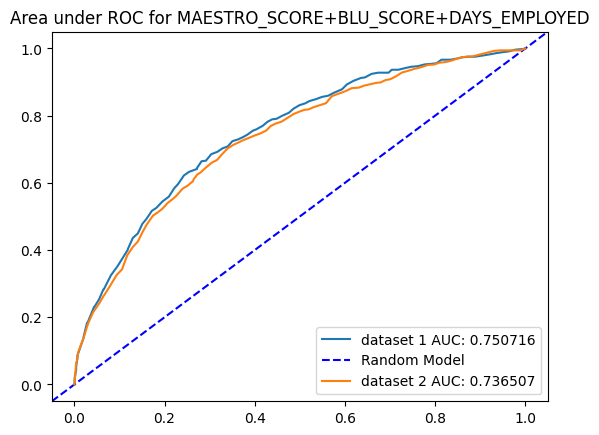

KS 2 sample test: KstestResult(statistic=0.38223614692661884, pvalue=5.329139135925209e-69, statistic_location=0.08738824, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.36251638343396775, pvalue=2.526439314905632e-77, statistic_location=0.07993455, statistic_sign=1)


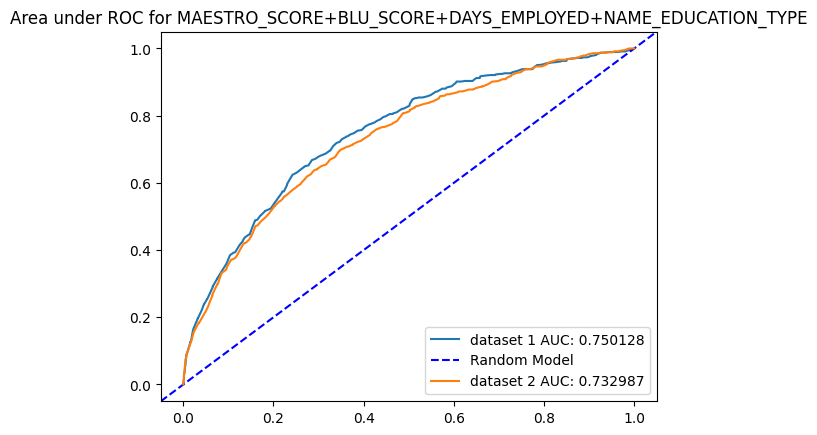

KS 2 sample test: KstestResult(statistic=0.38279158385756284, pvalue=3.3166107633226767e-69, statistic_location=0.09213336, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.349952950138349, pvalue=6.064065683651466e-72, statistic_location=0.08171097, statistic_sign=1)


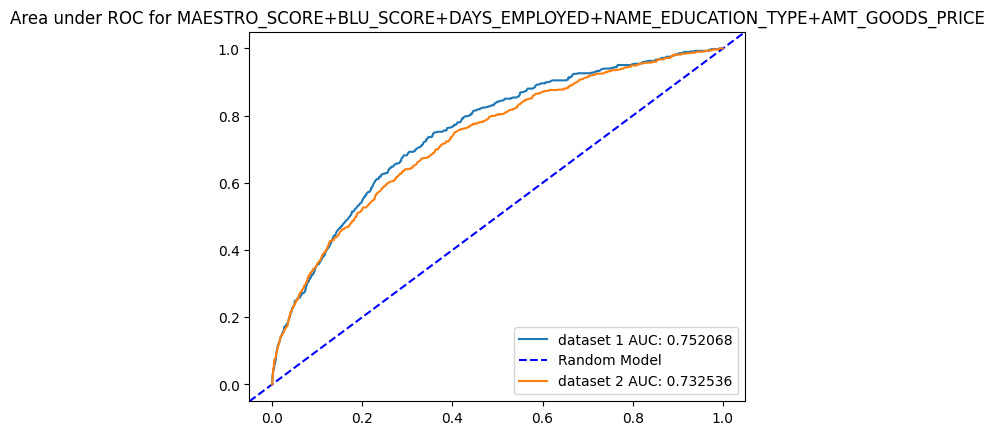

KS 2 sample test: KstestResult(statistic=0.38965064139414946, pvalue=8.87550684090406e-72, statistic_location=0.07782725, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3453347821703429, pvalue=5.08965660976239e-70, statistic_location=0.08929121, statistic_sign=1)


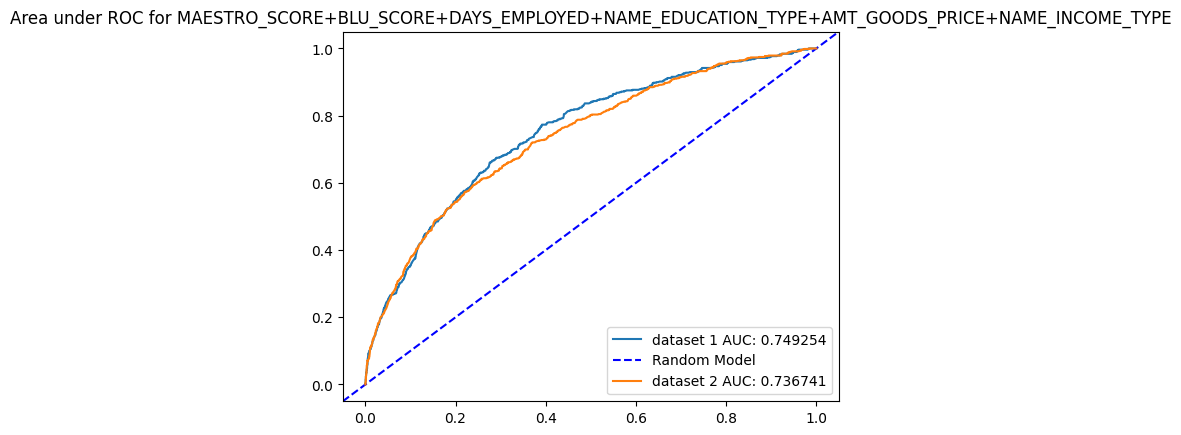

KS 2 sample test: KstestResult(statistic=0.38495173803305793, pvalue=5.1975089804591465e-70, statistic_location=0.09286632, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3541342265338815, pvalue=1.0364958698059771e-73, statistic_location=0.097929455, statistic_sign=1)


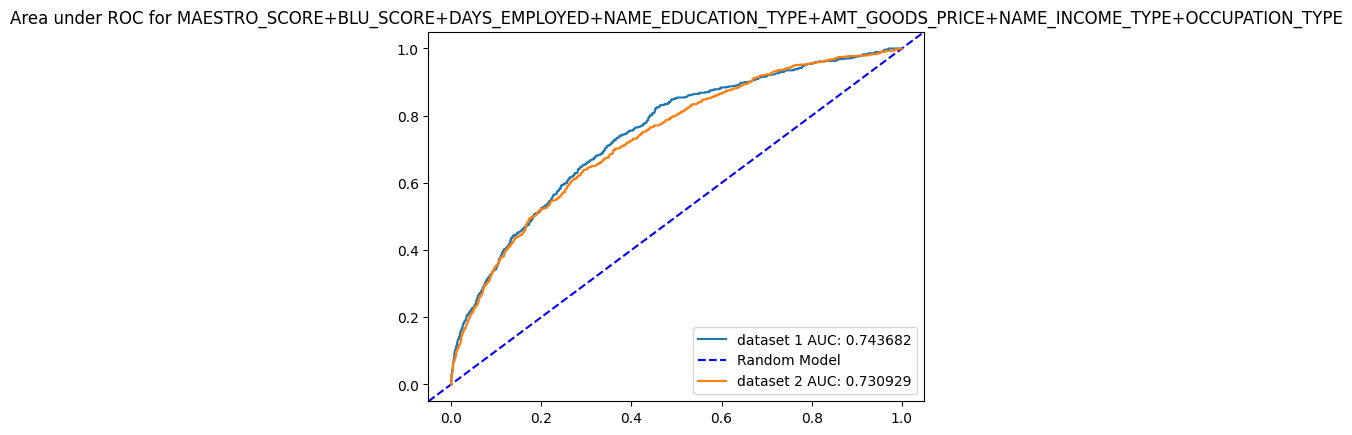

KS 2 sample test: KstestResult(statistic=0.36844576209012914, pvalue=5.421086391986268e-64, statistic_location=0.052494805, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.34451981135245946, pvalue=1.1049918629544308e-69, statistic_location=0.085010745, statistic_sign=1)


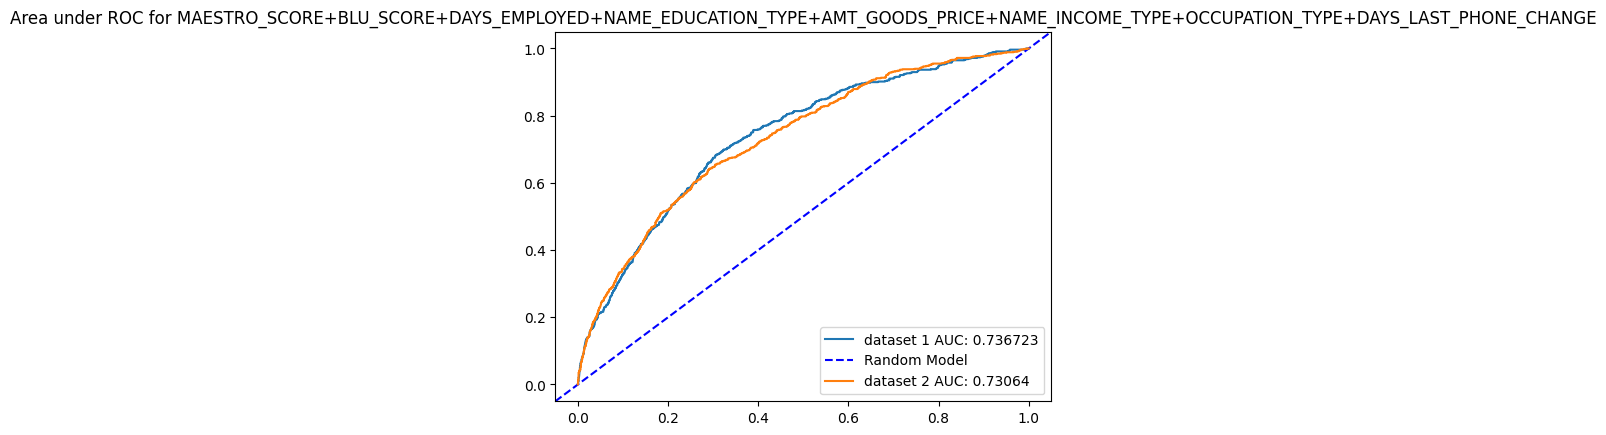

KS 2 sample test: KstestResult(statistic=0.37711347995335315, pvalue=4.085140831265822e-67, statistic_location=0.08016578, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.35035343407978314, pvalue=4.111018422768485e-72, statistic_location=0.08270163, statistic_sign=1)


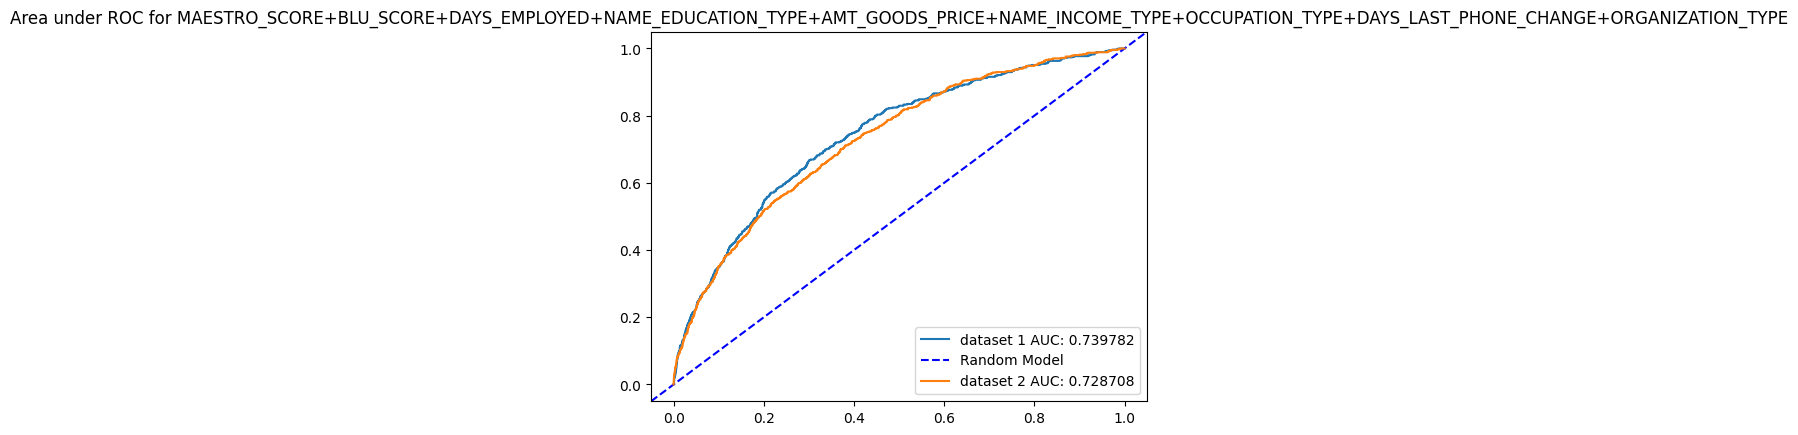

KS 2 sample test: KstestResult(statistic=0.36690373339027316, pvalue=1.908911995785274e-63, statistic_location=0.080300614, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3308137385596021, pvalue=3.7499481650488406e-64, statistic_location=0.06205301, statistic_sign=1)


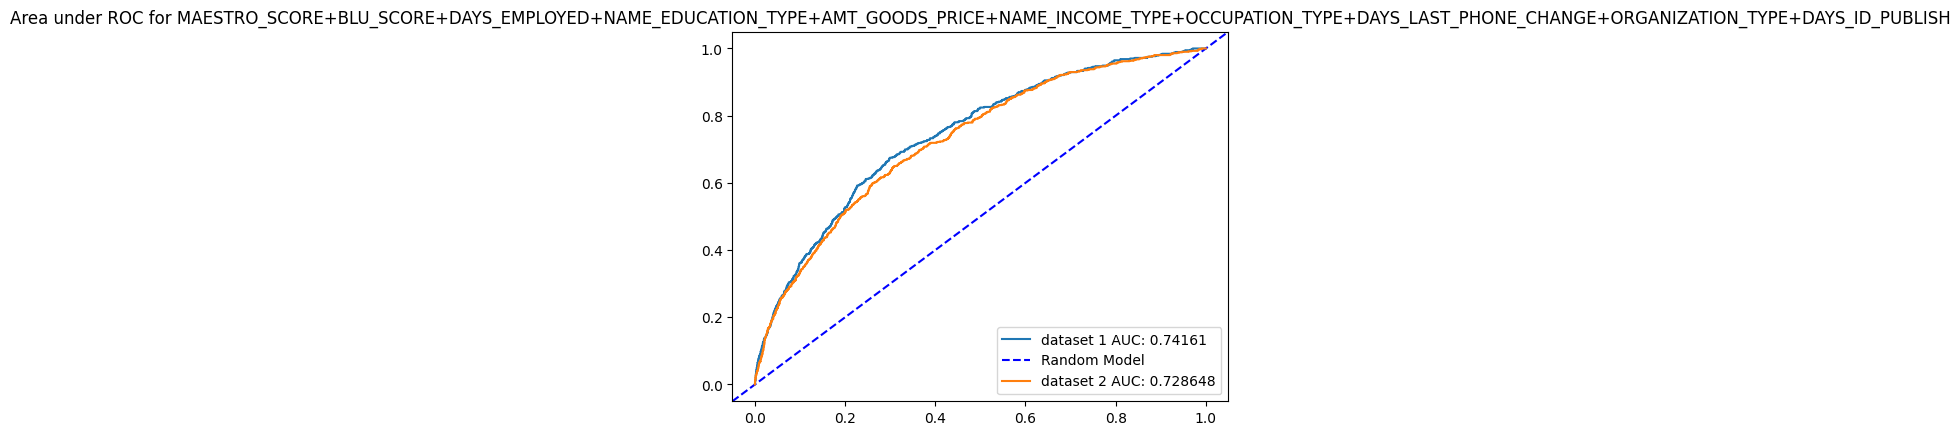

KS 2 sample test: KstestResult(statistic=0.3753354795263045, pvalue=1.8133933541820142e-66, statistic_location=0.078954615, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.34089165089002654, pvalue=3.3999740091249707e-68, statistic_location=0.07654052, statistic_sign=1)


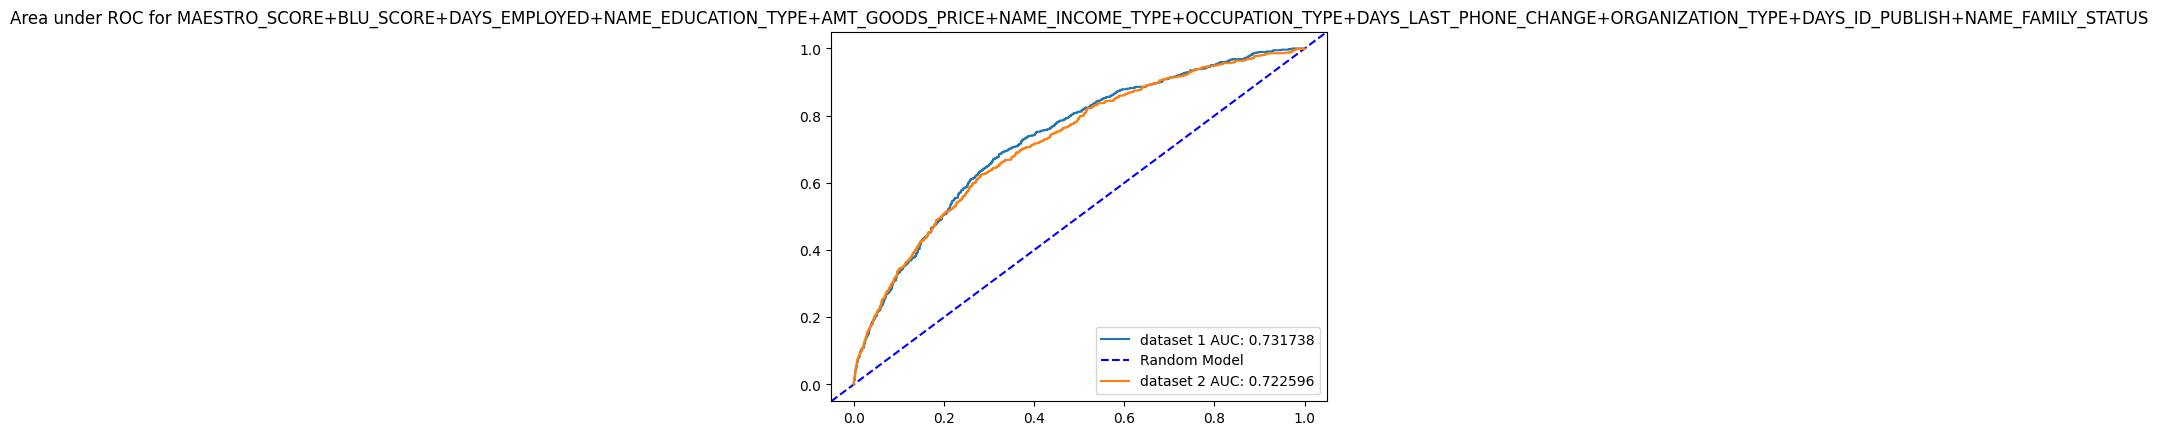

KS 2 sample test: KstestResult(statistic=0.36345038844997785, pvalue=3.1344508282135652e-62, statistic_location=0.07080472, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3424725822532403, pvalue=7.678211486472582e-69, statistic_location=0.081651084, statistic_sign=1)


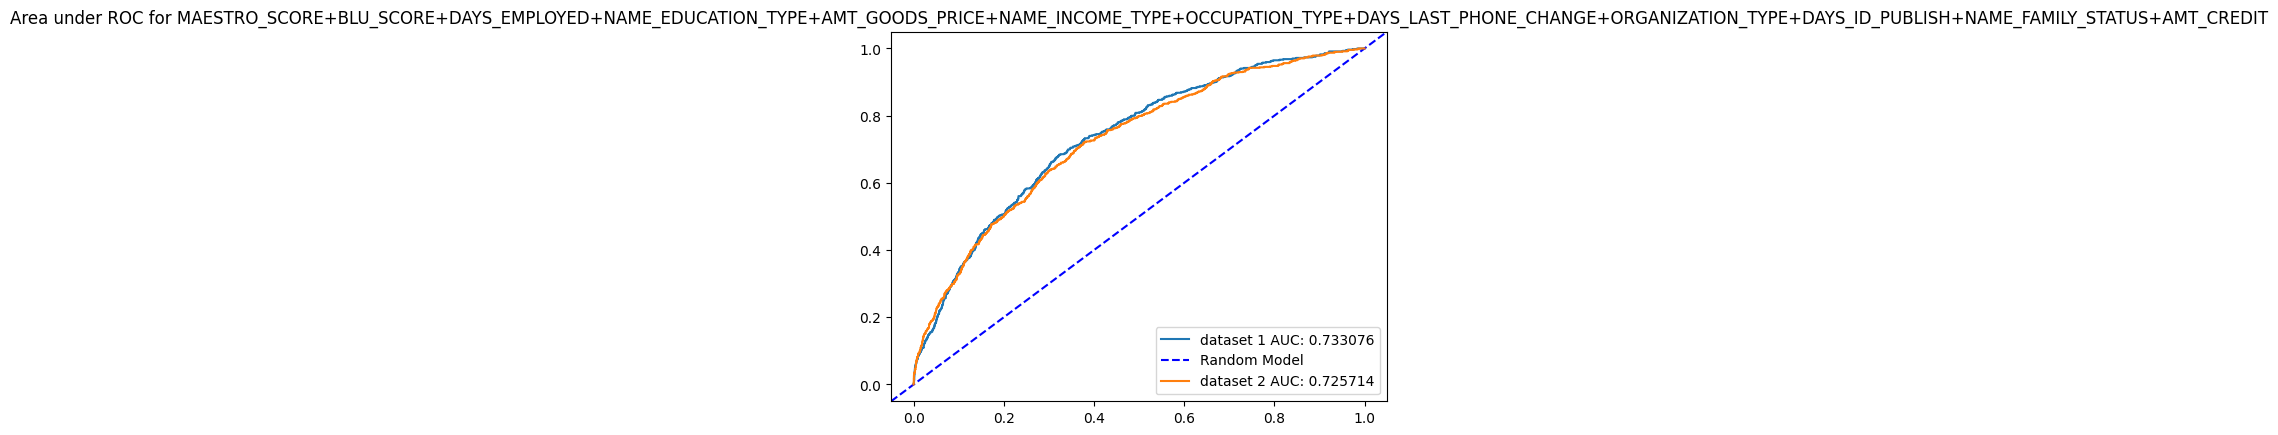

KS 2 sample test: KstestResult(statistic=0.36106986624618803, pvalue=2.1208168241851636e-61, statistic_location=0.067975804, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.342763843301556, pvalue=5.838171940913501e-69, statistic_location=0.056425467, statistic_sign=1)


In [37]:
top_12_xbglog_metrics = get_metrics(xbglog_regs, df_train_validate, df_test )

As expected, XGBoosting provides overfitted results, compare the performance of this model against the the plain logistic regression. This is seen in the validation and the testing data.

##  Random Forest Classifier

We will continue to use our top 12 variables and add them iteratively, this will atleast provide some transparency in how important features could be:

In [38]:
def RF_fitter (feature_list, dataset, n, estimators):
  # keep dict of model features (key) and model fit (value)
  maps = {}
  for i in range(len(feature_list[0:n]) ):
    var = '+'.join( variable for variable in feature_list[0:i+1] )

    temp = RandomForestClassifier()
    temp.fit(dataset[feature_list[0:i+1]] , dataset.IS_DEFAULT)

    maps[var] = temp
  return maps


def RF_preds(models, X_data):
  # use dict of models to create dict of model preds
  model_pred_map = {}
  for key in models:
    var_list = key.split('+')
    model_pred_map[key] = models[key].predict(X_data[var_list])
  return model_pred_map

In [39]:
RF_models = RF_fitter(top_features, df_train_train, 20, 100)

RF_fitted_models = RF_preds(RF_models, df_train_train)

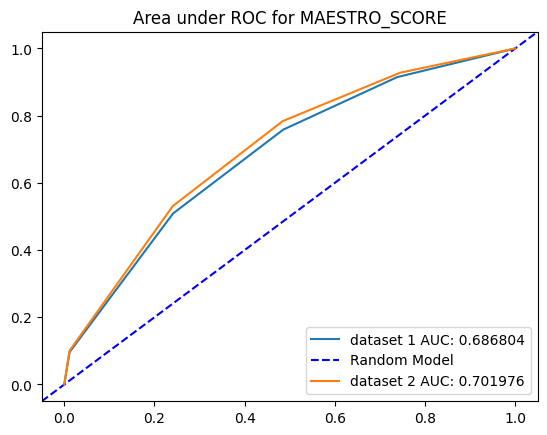

KS 2 sample test: KstestResult(statistic=0.2728065892402711, pvalue=4.688026228642501e-138, statistic_location=0.052143935479551116, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.2994076069400873, pvalue=5.507353801487158e-42, statistic_location=0.052143935479551116, statistic_sign=1)


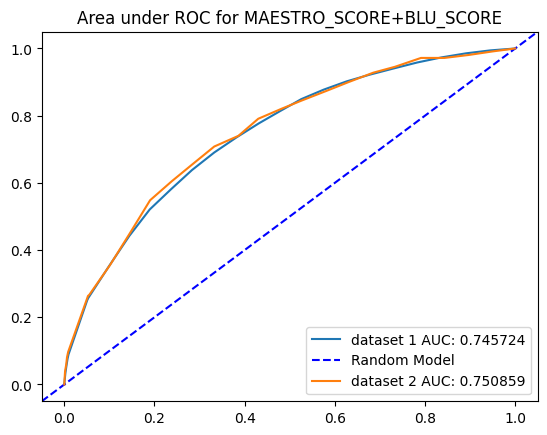

KS 2 sample test: KstestResult(statistic=0.35780175062508573, pvalue=3.0010228184772165e-240, statistic_location=0.07437746003431772, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3755498250743229, pvalue=1.5149598986054348e-66, statistic_location=0.07437746003431772, statistic_sign=1)


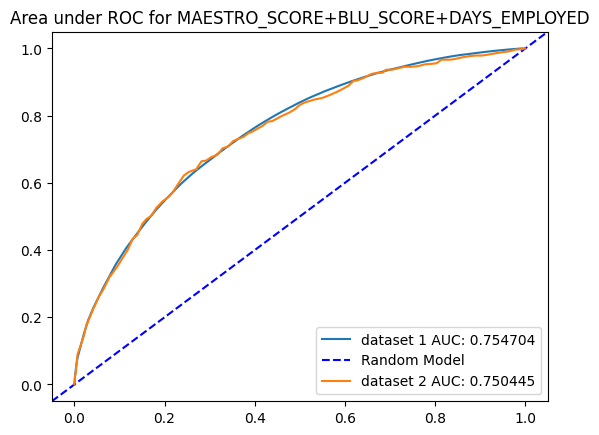

KS 2 sample test: KstestResult(statistic=0.36858643588417944, pvalue=2.0197056982747497e-255, statistic_location=0.08186570941326594, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.38223614692661884, pvalue=5.329139135925209e-69, statistic_location=0.08673875745856988, statistic_sign=1)


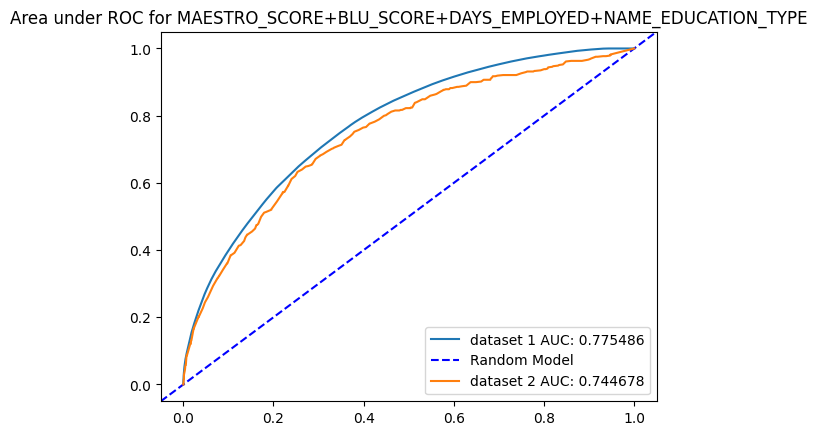

KS 2 sample test: KstestResult(statistic=0.4015283951662598, pvalue=5.457096735093857e-305, statistic_location=0.08116307165088144, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3794178999063778, pvalue=5.835178618596234e-68, statistic_location=0.10206015714137268, statistic_sign=1)


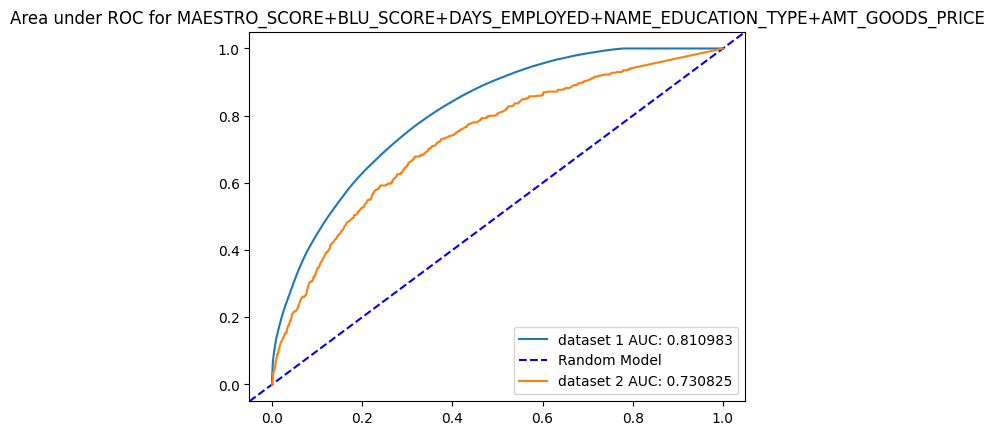

KS 2 sample test: KstestResult(statistic=0.45239756268925235, pvalue=0.0, statistic_location=0.08120122781507988, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3609376454292112, pvalue=2.3576854741313664e-61, statistic_location=0.0850908694848323, statistic_sign=1)


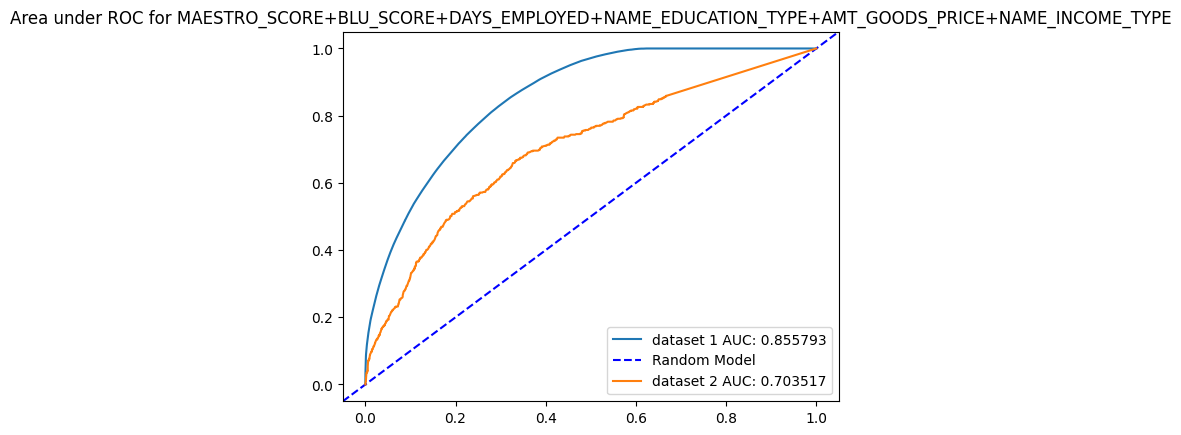

KS 2 sample test: KstestResult(statistic=0.5328900366434763, pvalue=0.0, statistic_location=0.08063135454157123, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.33290327349177934, pvalue=4.8976373562682946e-52, statistic_location=0.08215391389656093, statistic_sign=1)


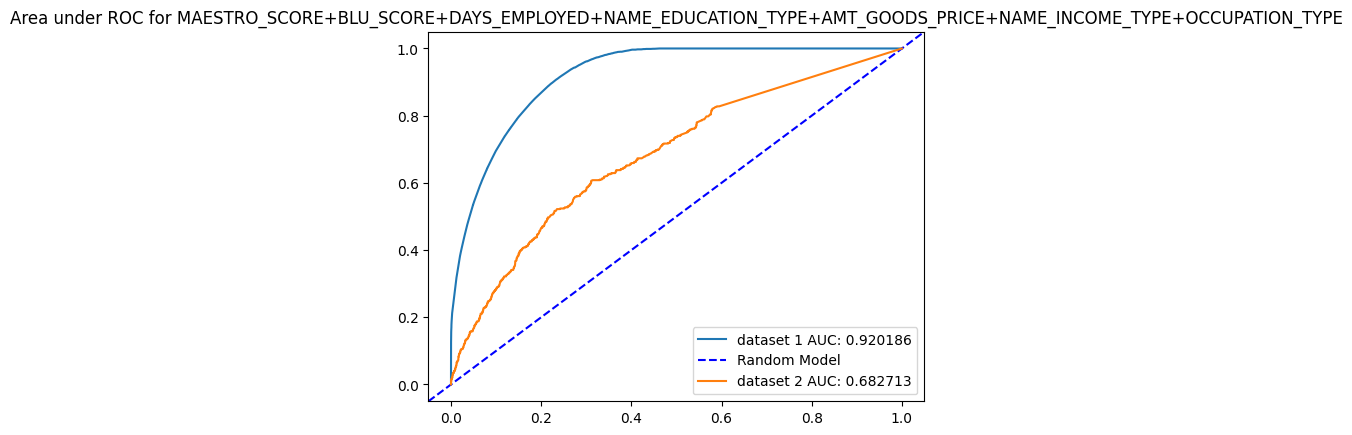

KS 2 sample test: KstestResult(statistic=0.6741931486235283, pvalue=0.0, statistic_location=0.09017857142857144, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.29526769924828494, pvalue=7.989111442223899e-41, statistic_location=0.06975017925382969, statistic_sign=1)


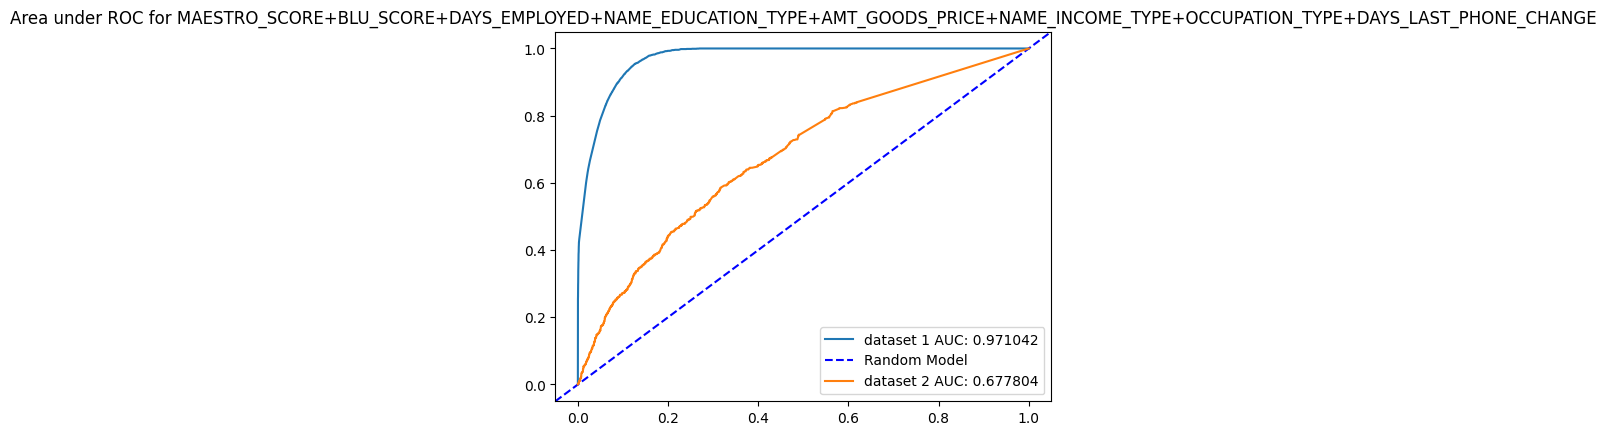

KS 2 sample test: KstestResult(statistic=0.8278993824618481, pvalue=0.0, statistic_location=0.12, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.2693494078806892, pvalue=6.077426580399044e-34, statistic_location=0.05011904761904762, statistic_sign=1)


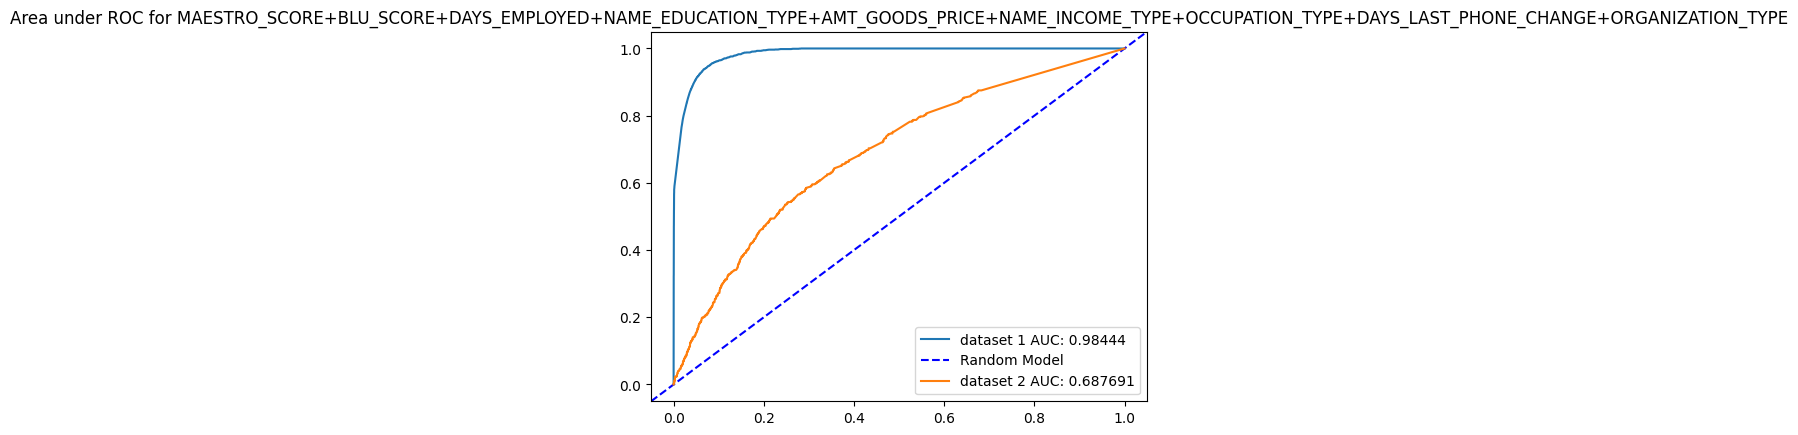

KS 2 sample test: KstestResult(statistic=0.87127992169269, pvalue=0.0, statistic_location=0.165, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.2913120247031191, pvalue=9.91777628876718e-40, statistic_location=0.07011904761904762, statistic_sign=1)


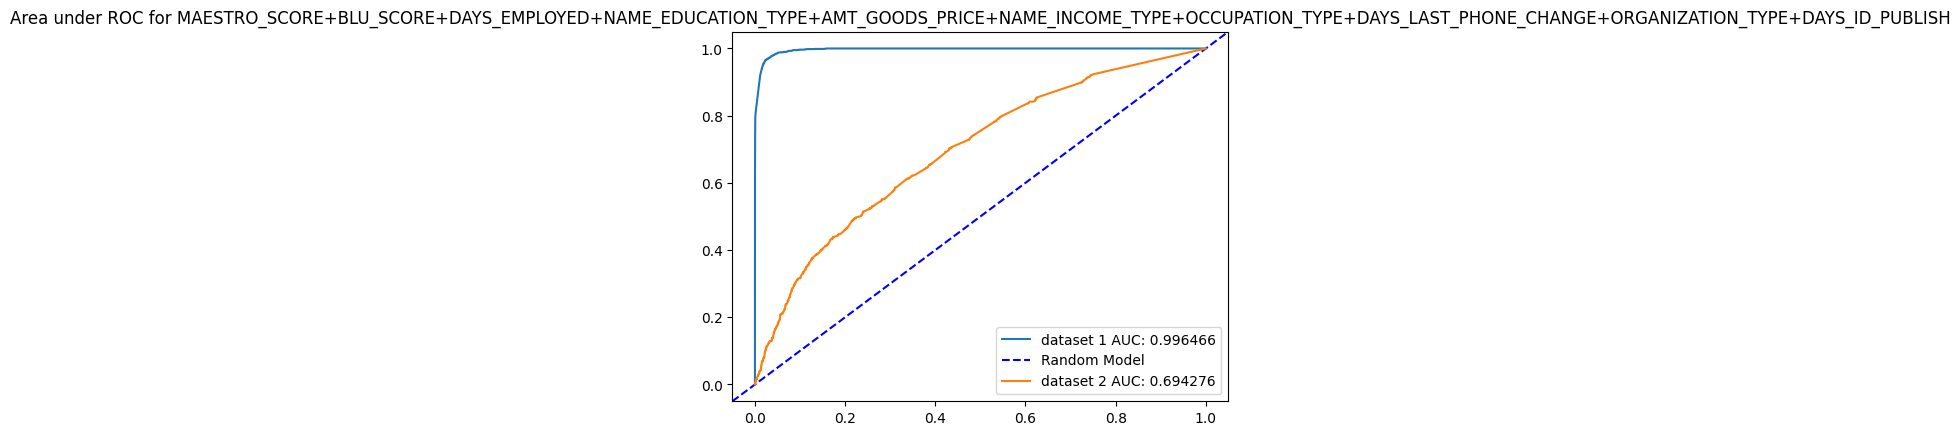

KS 2 sample test: KstestResult(statistic=0.9420677970595417, pvalue=0.0, statistic_location=0.21166666666666664, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.27609130080098987, pvalue=1.1447530425884098e-35, statistic_location=0.07266666666666666, statistic_sign=1)


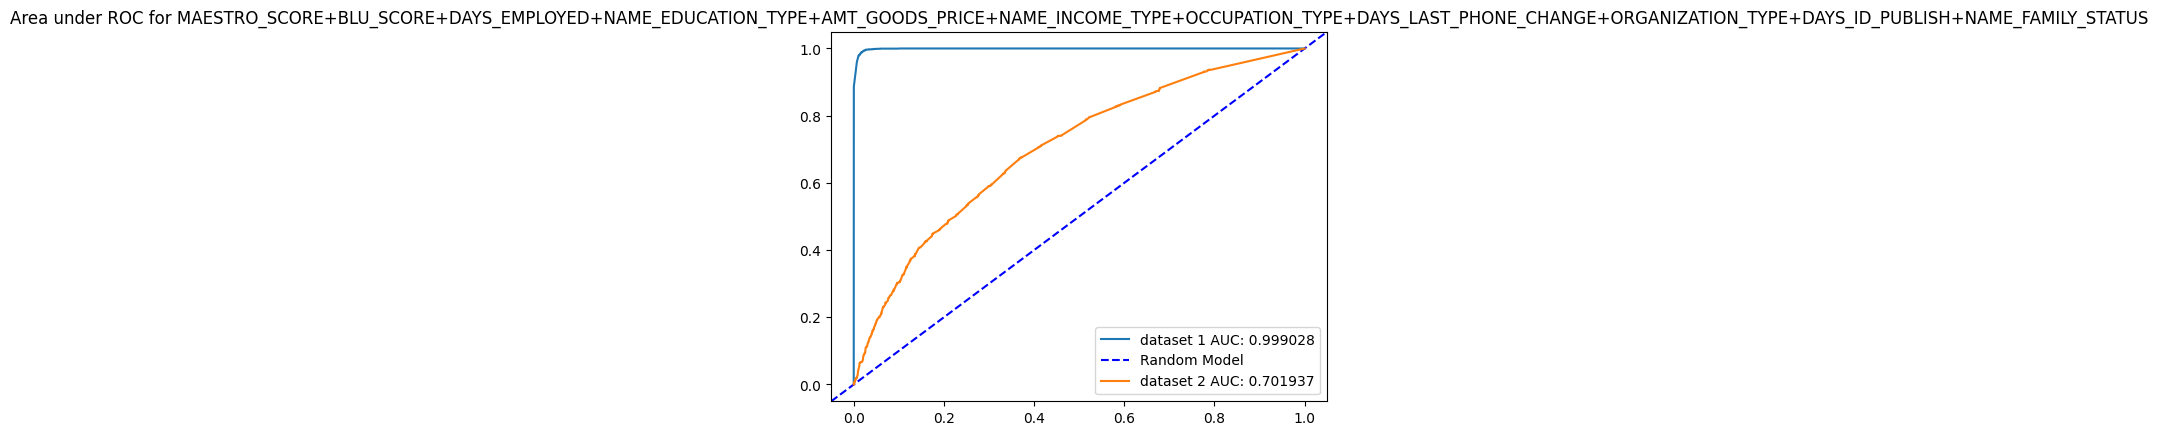

KS 2 sample test: KstestResult(statistic=0.971695328459225, pvalue=0.0, statistic_location=0.22083333333333333, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.30566523769634657, pvalue=8.936396545682504e-44, statistic_location=0.066, statistic_sign=1)


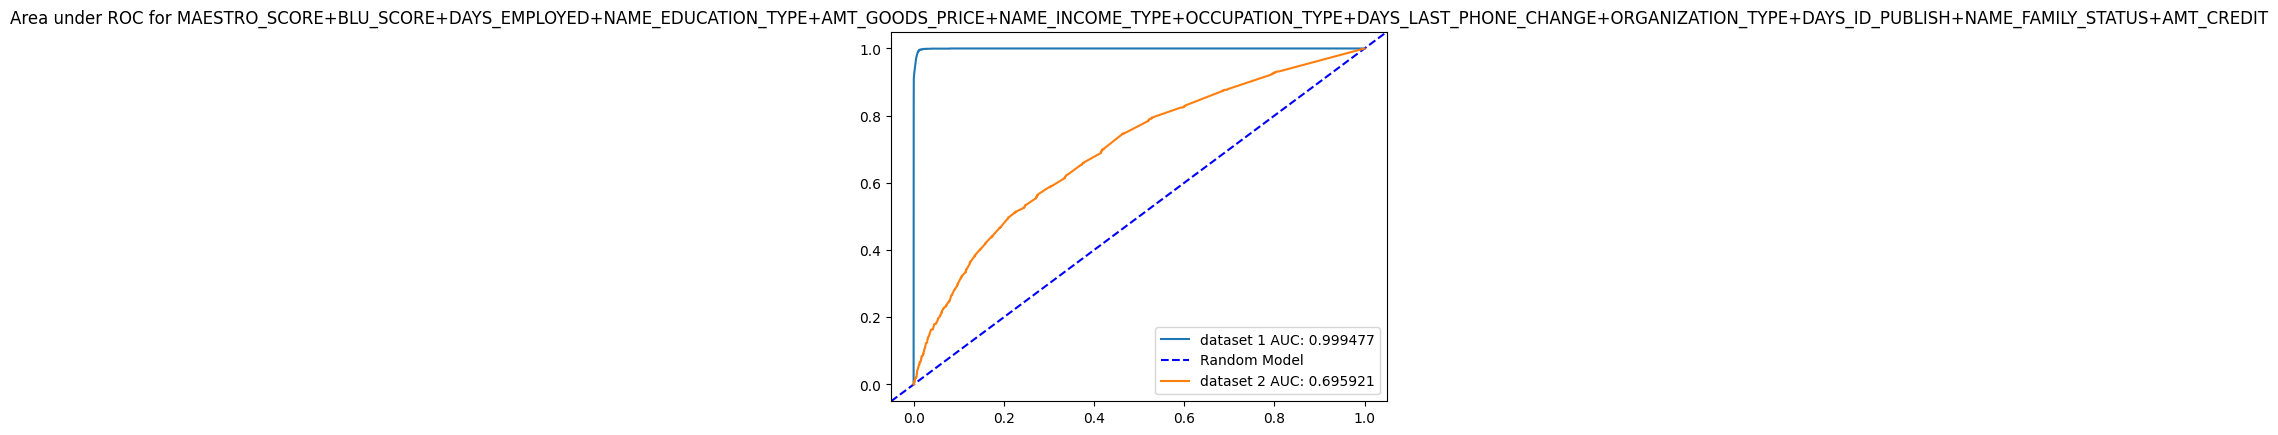

KS 2 sample test: KstestResult(statistic=0.9830104610732019, pvalue=0.0, statistic_location=0.22, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.2902041620813692, pvalue=1.995236491069667e-39, statistic_location=0.09078571428571429, statistic_sign=1)


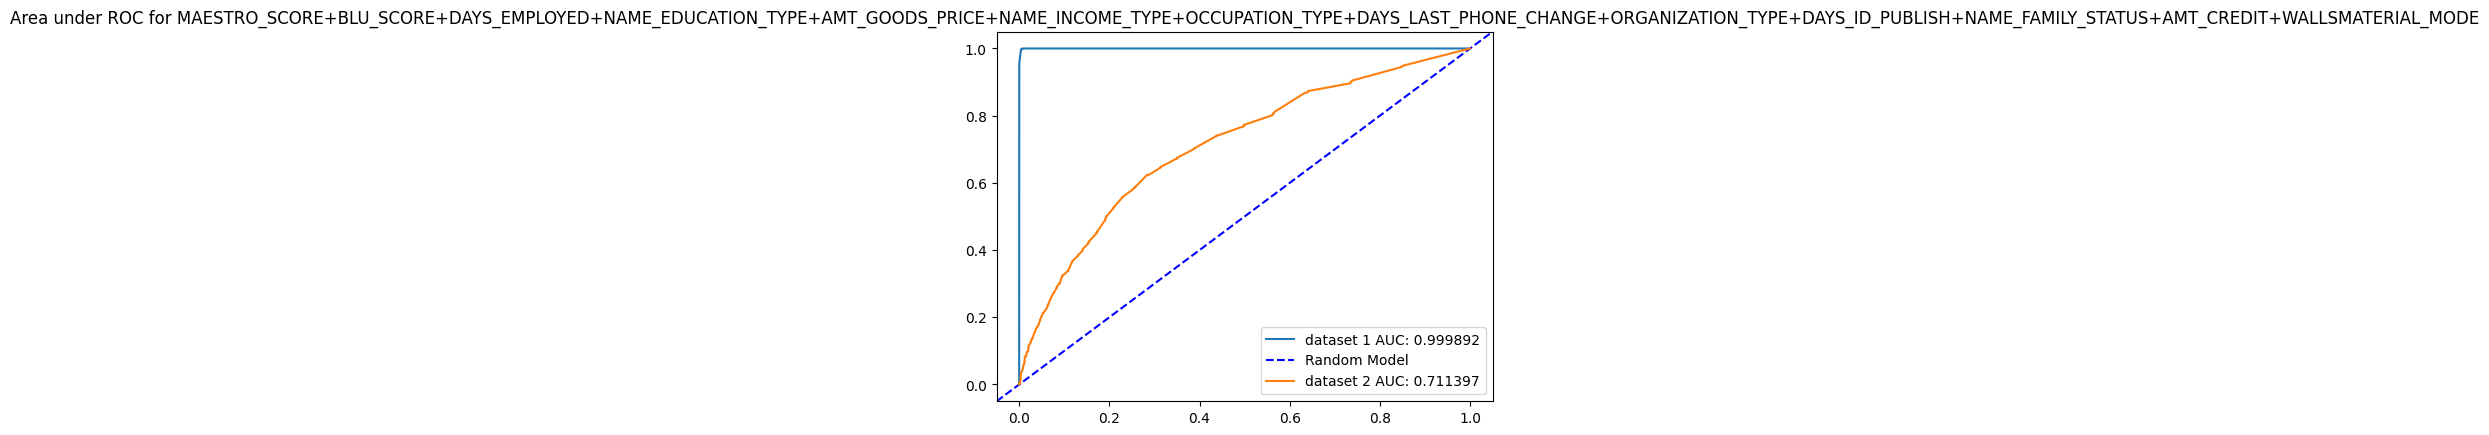

KS 2 sample test: KstestResult(statistic=0.9937749793776212, pvalue=0.0, statistic_location=0.28, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.34010095866936035, pvalue=2.3824514668304372e-54, statistic_location=0.09999999999999998, statistic_sign=1)


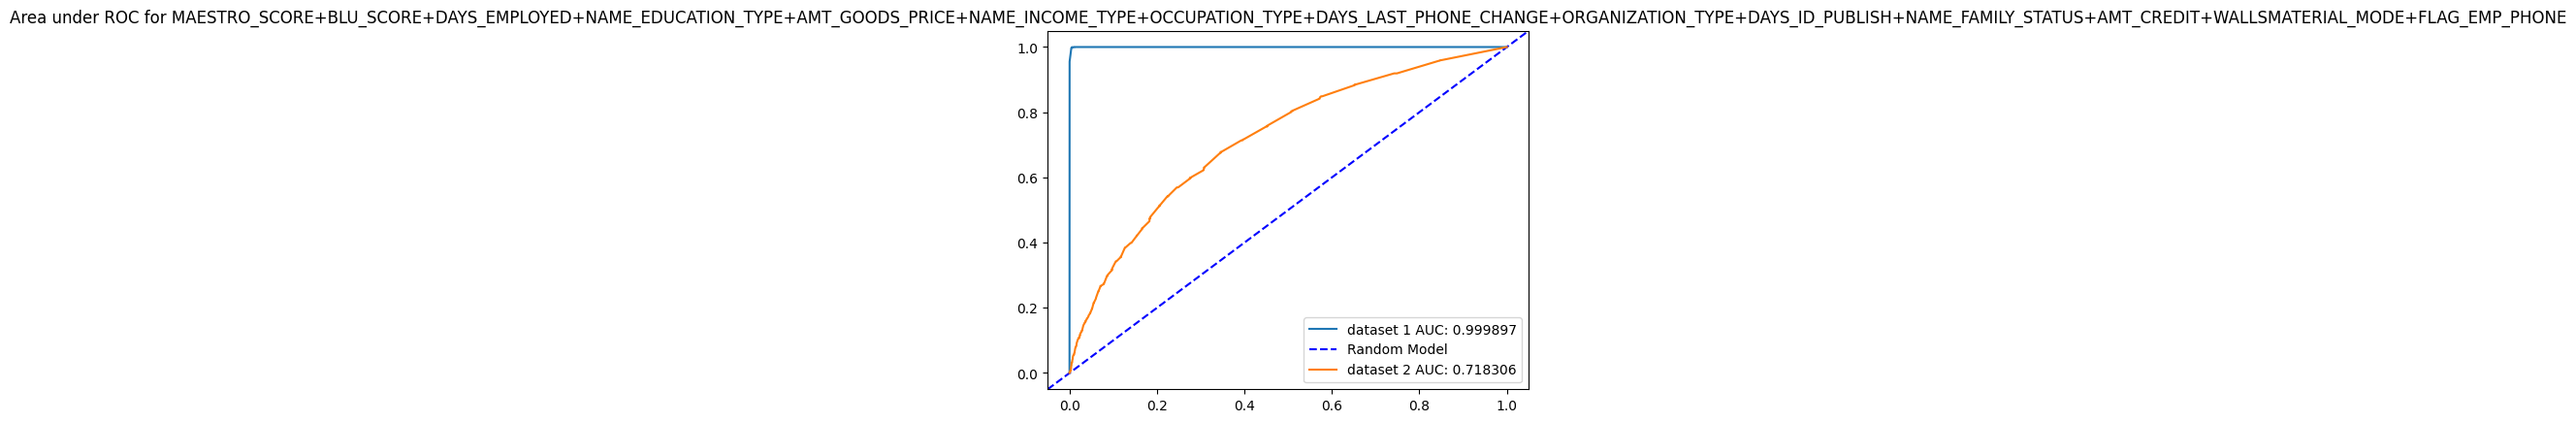

KS 2 sample test: KstestResult(statistic=0.9939307729511362, pvalue=0.0, statistic_location=0.28, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.332432972532015, pvalue=6.905610867035288e-52, statistic_location=0.07466666666666667, statistic_sign=1)


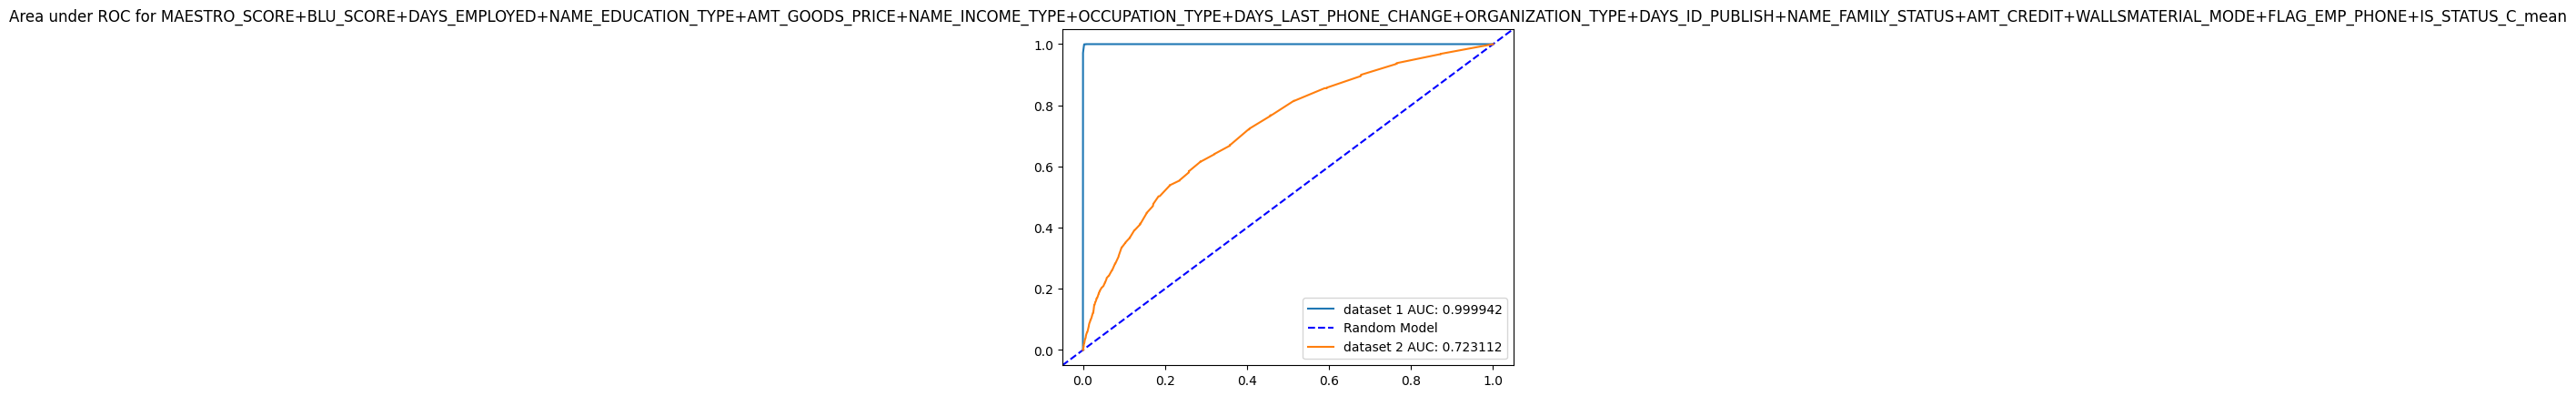

KS 2 sample test: KstestResult(statistic=0.9964839025708591, pvalue=0.0, statistic_location=0.28, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.33011158013457503, pvalue=3.7304376476219236e-51, statistic_location=0.0965, statistic_sign=1)


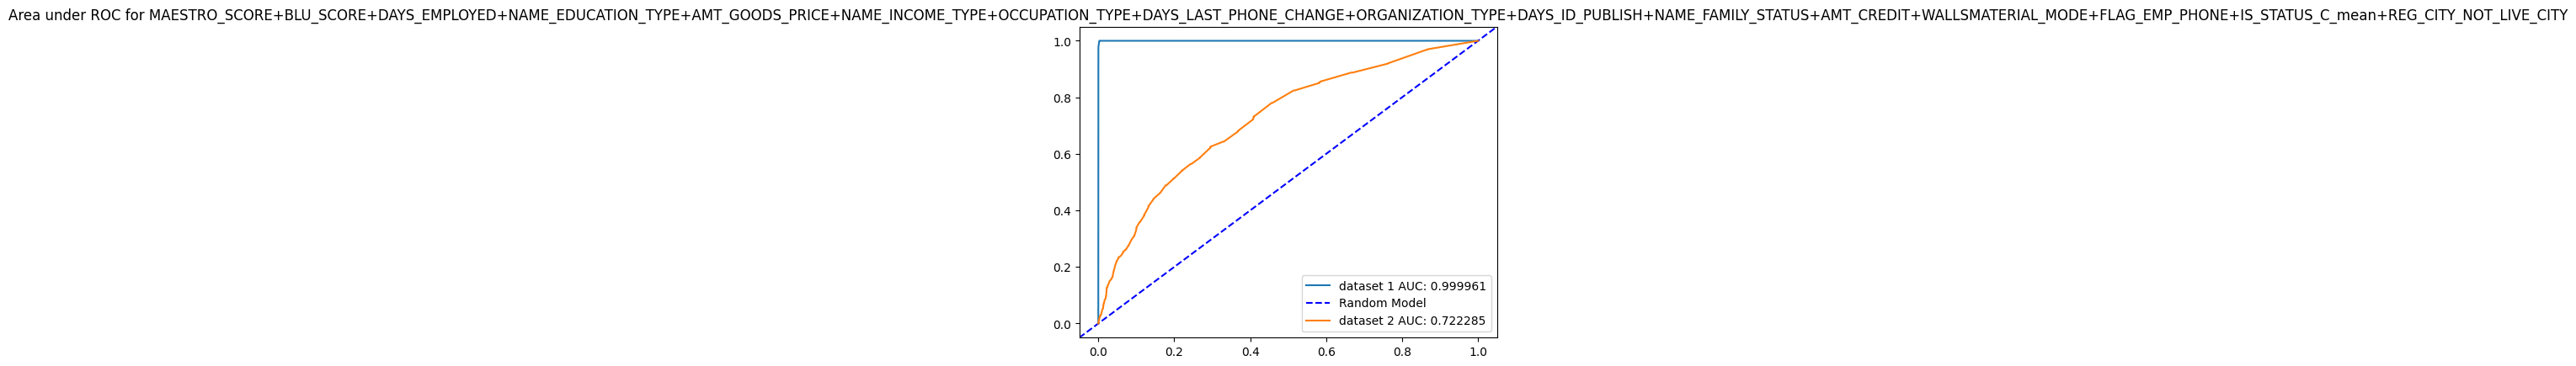

KS 2 sample test: KstestResult(statistic=0.9970009737098344, pvalue=0.0, statistic_location=0.27, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3298646584432436, pvalue=4.4622340202288176e-51, statistic_location=0.09333333333333334, statistic_sign=1)


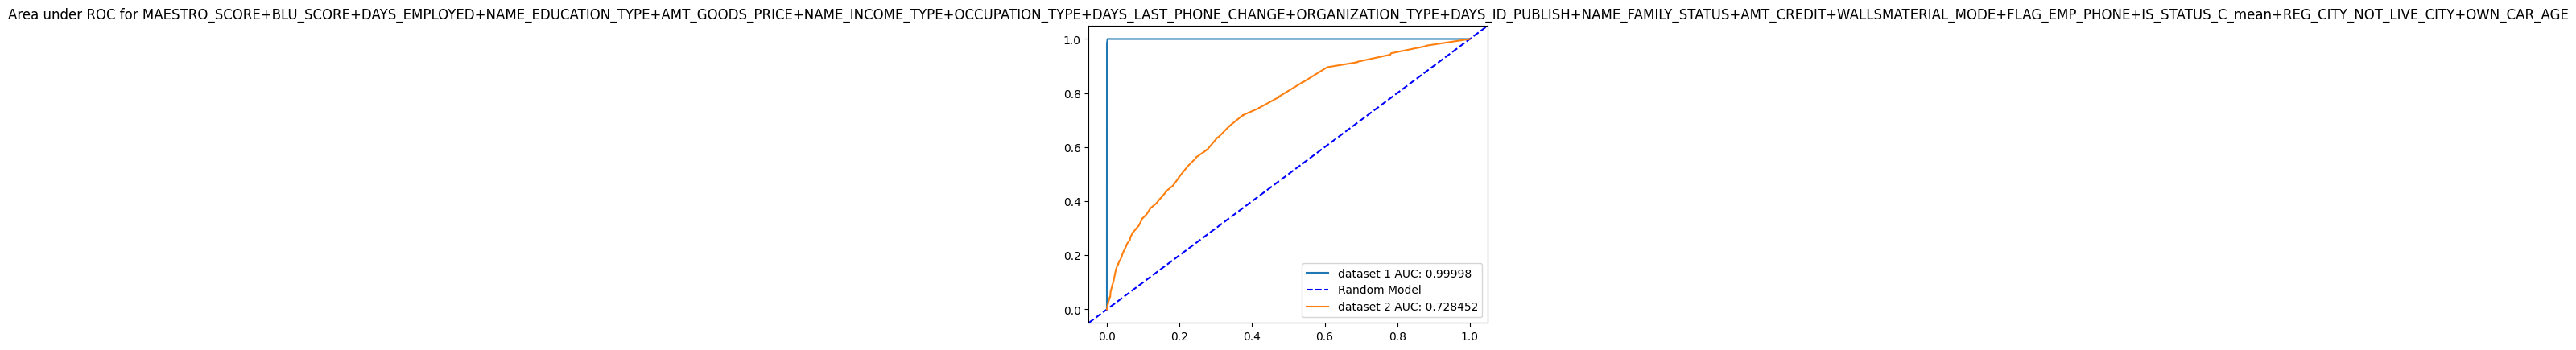

KS 2 sample test: KstestResult(statistic=0.9979746835443037, pvalue=0.0, statistic_location=0.28, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3436829656882874, pvalue=1.6097699936951134e-55, statistic_location=0.079, statistic_sign=1)


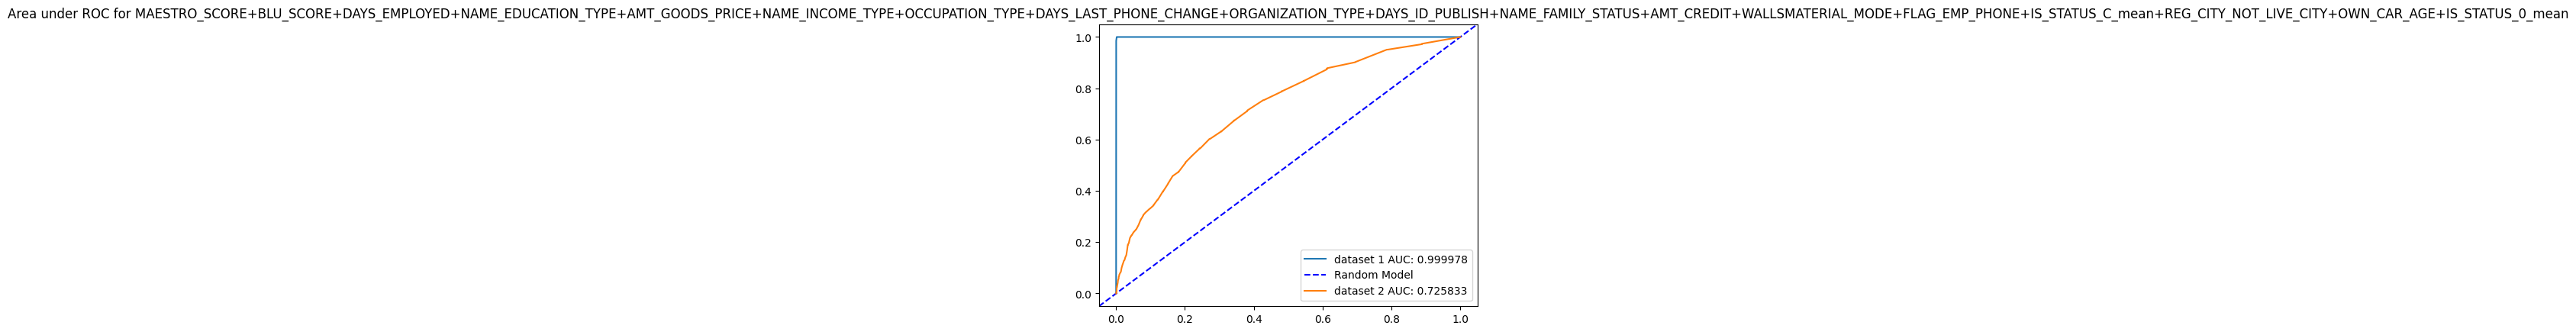

KS 2 sample test: KstestResult(statistic=0.997935735150925, pvalue=0.0, statistic_location=0.28, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.33265635180044784, pvalue=5.8661466437473685e-52, statistic_location=0.0875, statistic_sign=1)


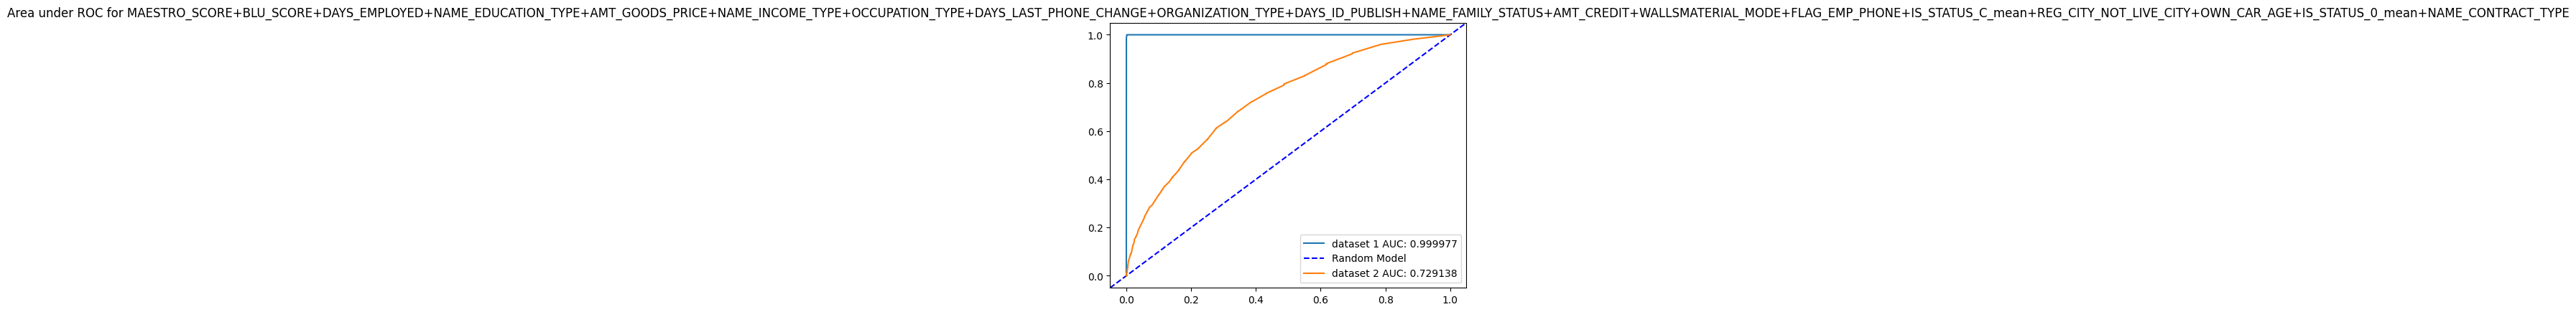

KS 2 sample test: KstestResult(statistic=0.9983252190847127, pvalue=0.0, statistic_location=0.29, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.33879572294400734, pvalue=6.322975746660073e-54, statistic_location=0.08933333333333333, statistic_sign=1)


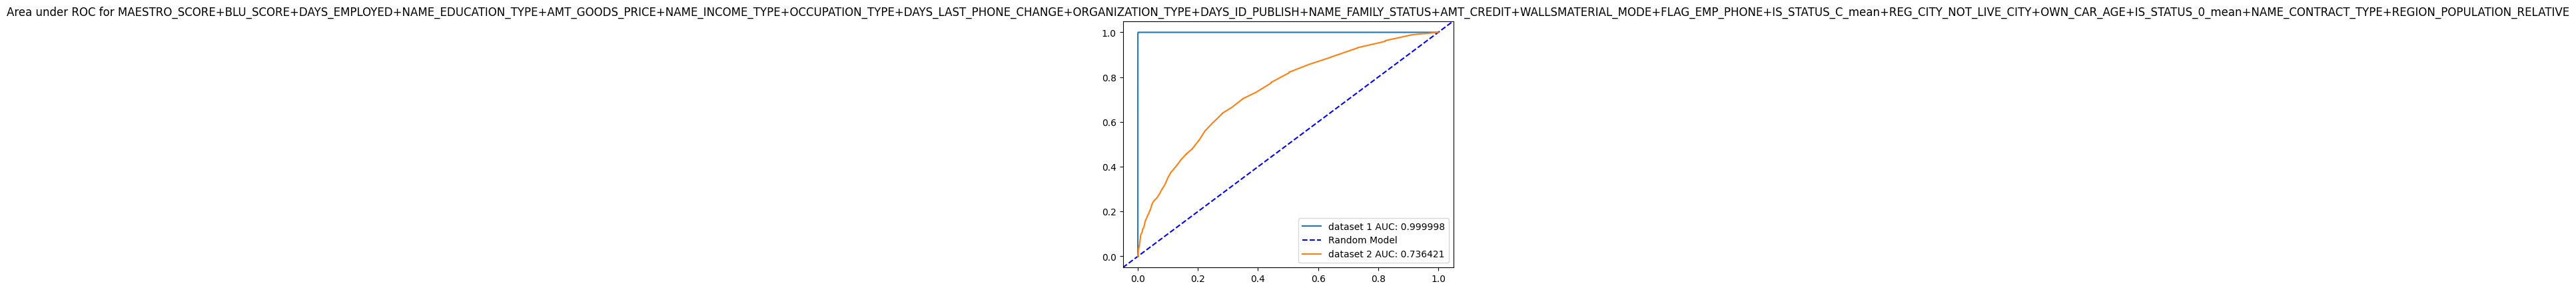

KS 2 sample test: KstestResult(statistic=0.999143135345667, pvalue=0.0, statistic_location=0.27, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3577432671408001, pvalue=2.993134421574177e-60, statistic_location=0.10066666666666668, statistic_sign=1)


In [40]:
top_RF_metrics = get_metrics(RF_models, df_train_train, df_train_validate)

For Random Forest we can try some alternatives, but again we note that the model results seemed very good on the training set but was unfortunately overfit on the training and showed a huge gap on the validating dataset, of course, we can try to scale the values between 0 and 1 and hypertune the parameters before we set on the final out of sample testing set. Due to the computational limit of my personal pc, we cannot test out on additive features for hyperparameter tuning.

In [45]:
def RF_fitter_grid (feature_list, dataset, n):
  # keep dict of model features (key) and model fit (value)
  best_model_maps = {}
  n_estimators = [5,20,40,100]
  max_features = ['auto', 'sqrt']
  max_depth =  [2,4,10,20]
  min_sample_split =  [2,4,6]
  min_sample_leaf = [1,2,5]
  bootstrap = [True, False]

  random_grid = {'n_estimators': n_estimators, 'max_features': max_features, "max_depth": max_depth, 'min_samples_split': min_sample_split, 'min_samples_leaf' : min_sample_leaf, 'bootstrap': bootstrap}

  rfc_gridsearch =  RandomForestClassifier()
  var = '+'.join( variable for variable in feature_list[0:n+1] )
  rfc_gridsearch = GridSearchCV(estimator = rfc_gridsearch, param_grid = random_grid,cv =4, verbose = 4 , n_jobs = 4 )
  rfc_gridsearch.fit(dataset[feature_list[0:n+1]] , dataset.IS_DEFAULT)
  best_model = RandomForestClassifier(**rfc_gridsearch.best_params_)
  best_model_maps[var] = best_model.fit(dataset[feature_list[0:n+1]] , dataset.IS_DEFAULT)

  return best_model_maps




def RF_preds(models, X_data):
  # use dict of models to create dict of model preds
  model_pred_map = {}
  for key in models:
    var_list = key.split('+')
    model_pred_map[key] = models[key].predict(X_data[var_list])
  return model_pred_map

In [51]:
RF_griddy = RF_fitter_grid(top_features, df_train_train, 20)

Fitting 4 folds for each of 576 candidates, totalling 2304 fits


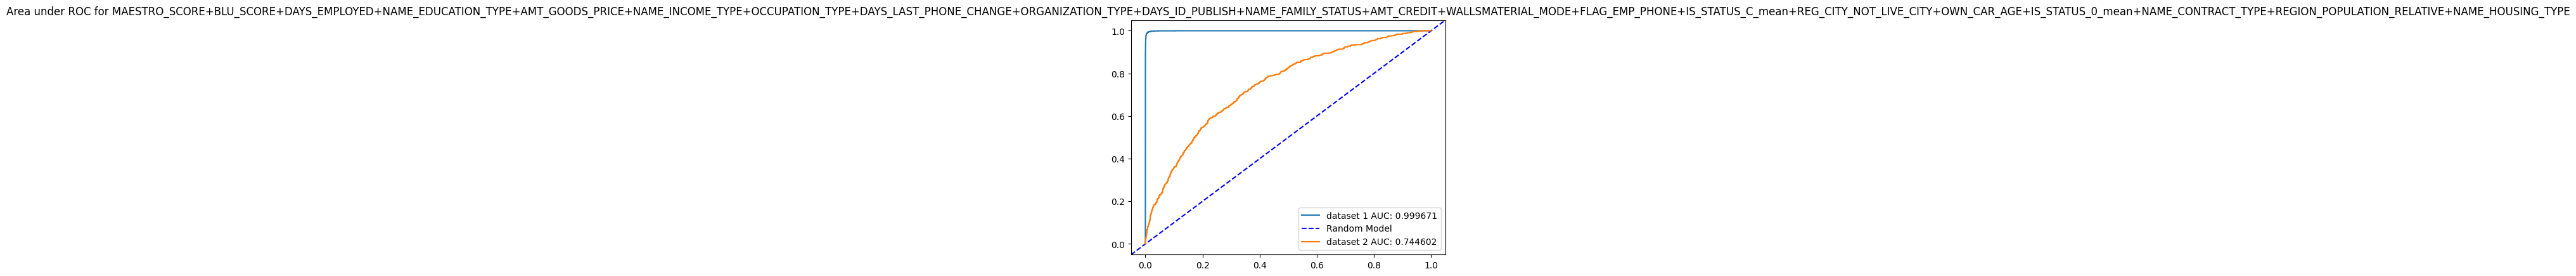

KS 2 sample test: KstestResult(statistic=0.9846382541814572, pvalue=0.0, statistic_location=0.23097029359529356, statistic_sign=1)
KS 2 sample test: KstestResult(statistic=0.3669593044582779, pvalue=1.8243693682568807e-63, statistic_location=0.08658601041456201, statistic_sign=1)


In [53]:
RF_fitted_gridded_metrics = get_metrics(RF_griddy, df_train_train,df_train_validate )

again we see gross overfitting.